# Reconstructing 3D buildings from Aerial LiDAR with Deep Learning
> * 🔬 Data Science
* 🥠 Deep Learning and Instance Segmentation

## Table of Contents
* [Introduction](#Introduction)
* [Part 1 - Data Preparation](#Part-1---Data-Preparation)
 * [Export training data](#Export-training-data)
* [Part 2 - Model Training](#Part-2---Model-Training)
 * [Prepare data](#Prepare-data)
 * [Visualize training data](#Visualize-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Save the model](#Save-the-model)
* [Next steps](#Next-steps)
* [Conclusion](#Conclusion)
* [References](#References)

# Introduction

The workflow traditionally used to reconstruct 3D building models from aerial LiDAR is relatively straight-forward: the LiDAR point-cloud is transformed into a Digital Surface Model (DSM) raster, then inspected by human editors for buildings present. If a building is found, one or more polygons describing the roof form of the building is manually digitized, e.g. if it is a large hip roof with two gable outlets, there will be three polygons (one hip and two gables on top) drawn by the editor. Once all the roofs are described that way, a set of ArcGIS Procedural rules is applied to extrude the building models using the manually digitized roof segments, with heights and ridge directions computed from the DSM.

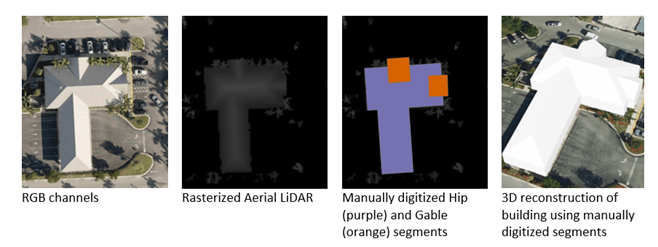

<center>Figure 1. 3D building reconstruction from Lidar example: a building with complex roof shape and its representation in visible spectrum (RGB), Aerial LiDAR, and corresponding roof segments digitized by a human editor. The last one is a 3D reconstruction of the same building using manually digitized masks and ArcGIS Procedural rules. </center>

The most time-consuming and expensive step in the above workflow is the manual search and digitization of the roof segment polygons from a DSM raster. In this notebook, we are going to focus on this challenging step and demonstrate how to detect instances of roof segments of various types using instance segmentation to make the process more efficient. The workflow consists of two major steps: (1) extract training data, (2) train a deep learning __instance segmentation__ model.

## Part 1 - Data Preparation

We started with two input data:
- A single-band raster layer with 2.25 square feet per pixel resolution converted from LiDAR point cloud (using the “[LAS Dataset to Raster](https://pro.arcgis.com/en/pro-app/tool-reference/conversion/las-dataset-to-raster.htm)” geoprocessing tool)
- A feature class that defines the location and label (i.e. flat, gable, hip, shed, mansard, vault, dome) of each roof segment.

We are using single band Lidar data which is essentially elevation to train our deep learning MaskRCNN model.

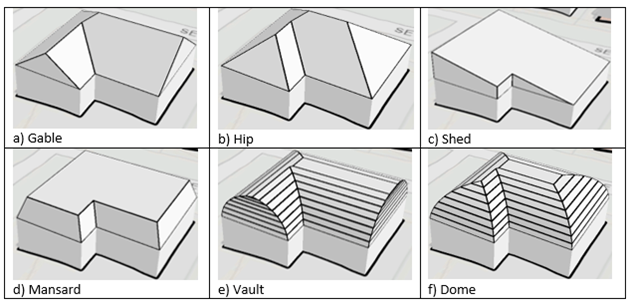

<center>Figure 2. Example of different roof types (flat not shown). </center>

### Export training data

Export training data using 'Export Training data for deep learning' tool, detailed documentation [here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm).

- Set nDSM imagery as 'Input Raster'.
- Set a location where you want to export the training data, it can be an existing folder or the tool will create that for you.
- Set the feature class layer as input to the 'Input Feature Class Or Classified Raster' parameter.
- 'Tile Size X' & 'Tile Size Y' can be set to 256.
- Select 'RCNN Masks' as the 'Meta Data Format' because we are training a 'MaskRCNN Model'.
- In 'Environments' tab set an optimum 'Cell Size'. For this example, as we have to perform the analysis on the LiDAR imagery, we used 0.8 cell size.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAr8AAAJPCAYAAAB1i7z3AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P1nWFxZmiaK9v17/tzn3nPdmZlnzpg7d6a7p8+c7prpnu6eme5pU9Vl0lSld1LKWxBOEk547xEIjwRIIIG8kAGEEQjvvTeBD0wE4YOIAN77fTsiUICQUlmZKKXMtbPeErGXX3vtd73r299e+w8gDnGIQxziEIc4xCEOcfxEji3iV6fXw7i6KiAgICDwHTE0NGRj1u9+7JS/gICAgMCrY3h42MaoQvwKCAj8hGAym7dg1WTaMd73ASF+BQQEBN4cCPErICDwk4NWp8PC4iJm5+YwL5dLf6s1mh3jOsKytiZh+3mzxbLjeTuE+BUQEBB4Mdj4sLa+jvWNjU0wr+4U9/uAEL+7gFWzCdgwY820c7iAgMAPBybY7p4e+Pn7Iy4uDv4BATh27Bju3rsnhe2UhsFEPESEOTA4uIWU+e/xiQl0dXdLFmTHNHYI8SsgICCwM1j4KldW0NDYiIrKSjx58gQ1T59ieGTkG5/IsdFhJ95+0Xk7fi/xu2YxwUzCTmswbkJv5AbsHP+nBBa+S7JFnLg5gdI56ivzzvEEBAR+GDAhdnV1ISs7W7L2Pnr0CEePHv1G8btBvHjr1i14eHhI4pnjMlj4spBOT0+XrBU7pX1d4pf5Z2NtKyyClwUEBN5gsFAdHRtDcHAw8vPzkZSUhP379yMnJ+elnMzp6urrca+4eIvrGp9nIX37zh3p7+3pGN9O/BKJrpuMGJ5ZQfTNYfy39GH8Q8Yw/jFzCH8WNYScKT0sRL7PpfsJwWQxY35gFv8jeQBXZDRhCvErIPBGgcm0vaMDObm5EjGWV1RI4rf4/v2XEi0TK4vlbBLNZz09JUsvC1+2HLMFeWl5+YVWitchfi3rZpjVGlQMKvHYjiEVxtXGn7xhgnl5unsKfxjdizyZCRC8LCDwxoB5mK28mVlZkktaS2ur9DTu6rVr3yh+6xsa4OrqKhkmmH85fn1dHdzd3VFUVPTC9N9K/LKQ62yW4WcpI/BrVMJAZMtid319lSaCedwa0cHkQLJMuHY45vMq4fZzrxpn+/lNOJx/1TjfeJ7w0vN0ATZs1nHHOFvi2s47YjPMIe72OAICAlbwSt/RP8wRL3I/YDAZdnR24lJOjuSy8Ngmfu8/ePBSomVwviyAWTiz6GWkpqZKPsMvsjAwdlX8Ek/AZERt5zz25w3j69synLozCdfiSXyY0o/Dj5egJvH3Ii78KYAt4orpZQSXzaBhkSZNwa0CAt87WHy+DDulYdjFb0ZmpsSvTS0tryR+GczJT2trJbHLll7++8yZM7hWWCiFv6jcVxa/ZiKP2eEZ/MeIPiQP6ijGVjK18CO2zdU0CWLLKjVCj1mlHgsaI1XQBJMtrpmEoWXViPkVPeYYaiOMfM5OSEYjVHqjJB4Vamsecs6D4tjz0BuM0BhXYTAYpDyUFJ/F4sbaKjRaA2ZteS/pV7FOdbPXVYpDdVumfKWyVQaoDBxGKwaKp9dRflTevNogiVhJwBLYfUHJdaE0cgrTSW4elIbCllTW89xOg0P9OQ6XqaO/tXzeVtd5KtNA/WEXx1wnx/zn2VJD/cN56DmdgIDAFjDh9fT24nxSEhISE3H+/HkJ8QkJSE1Lw9j4+Ba/XEcw0TYTubKVQU/3ZGlZGQ4dOiQR58tEsx1Mxp1dXTh9+jROnjiBWiJbzvNl5L6b4neduKO1fhw/SxtFer8W68TNzM8Mg0aL3lkdtDYuYljWKGzdiu3vJUjvK9jCpHD6vRlOcdcprYXKW3PIw1FI2t0ueL7Ynt6xXCr4eTFO/bdhDydwuzbTkni3n99SZ1udpDDK02584Wthj28va5XzgEXiWuZpnod4njJv5v28i4jUHod8OA23zz4PCQgIPAPrRvbdXVGpoFKrN6FQKkmXaXdMw2D+ZM5mVzTm5Na2Nkn8FhYVSe5mO6VxBPN2TU0NvL294ebmhlu3b0t1eRmfv7L4XTMbkXutD3+ePws5kcXLVs5r60Y0tMzjs/R+/GPWMP46fQjRnRpKw+RBgnZeheRbw/hZ+gjevTiM/5w6BPfHS1BQnvx4Sjs0gz+KH0BEtRyH80fwy4tD+OOQfpxrUUK/YRXZdZWj+IscGc6XyvCP2WPIHNRQuasY7JjDxxT/bzNH8JvsQfzH9Ak8HtdCT+UyMeq0ejytluGv0ofxy+wR/ENqP07WqajFNEENL+NIZj/+ns7/LZ0/9VQJHYliM00cDfUy/G3aIH5BYX+ZPo6aZQNMegOKy0ak+v8yawT/M2cSwyz8ZfP4WXwfssZXiTBXcf3OAP5T9gRiH8nw3sUR/FVMP05UL2GJ4nKdzCYjHpWP46+S+vFzrlPmKDyuDuDfp42jQWEWrhMCAtvA4oYfjzHJHSeSPEzilQWss7Oz9MKEgRagO6VjMmT3hOTkZERFR0tW29DQUMlnNyoqShLUL7Pgchj7prHFl/3SWEAz4bIl+WUWit0SvyzOtNNz+JPQHvj3aCl0q1FilYXqJn+QICThNjCyhEtNC8jrWMaQ2iqeWQyyAcOk1uBq6wJymxdwqW0JbUqjlIbTmzQ6VA4pIVMa0DS4hGzOo3UZw7To5zJ4Eb+yqEblhAazchUKWhZQPa0j0cnlrqJzbBmXKF/O++qQGgYSrWZbPdk4AqMeD7sXkUPhOa2LqJ2nyUsSsSYMOtR50FZnbvu6XoeybqprsxyXu5SY1holkb26osaNdsqH8irqV2GF8llVaVE2qMQYpef5a1SmQN2sHpPTCuRx+rZljGmtBg3uDza2GFQaFHdwPnJc6V7B5PwKSkdpMjcIASwg4Ag2NkzIZIiIjMSJEydw6tQpCSdPnsQ5Pz/09vW9UIwyn/NLbjGxsdL7FPwU7iDx+YULF7C4uPhSEcvgsqtJ/Hp6esLFxQU3b92SRPT3IH7ZUqvC1zG92E+CkMnIHsYrfMn1gQiSCZALG+qdws9CB1Ewp6ecLJD1T+Mv4kZQqiDSUqtw4kIPflu8gAWKy2Stli/i18HdONqswjqtsPUkfv/vPh34s2szmCCSAYiwu6bw7/z6EDtKBE/lN1SO4A/O9SC6RyPlwQQ9SHF+FtGPlBGrZZrYFFUVo/i3kcN4TGXDYsT1+0P40+Qx1CjpN8WxaNVonDFgeWYB/xjai9B+zs8C3TzVKW4AqeM6yKfk+FlgLy5OGKSwRbmGhKsRbc0y/NuwQdSucB3NmJlRYZEu4trEPP4wshepYzbxe6sPf+DXg7henpzWoBqfxc9CupEwQvlRWxobJvCnMYO4Om3N36JQYV9CB/5fCaOoWxbiV0BgJzBhssh9+OiRRLCniPQqq6okItwpvh3MbbLJSWmbM06bkZEh/T05NSVZKF5kweV8R0ZHEUDCNyEhQRLRnBf7ADPpsgB+Udm7JX4txC9Vj0fxxykTtPAmPrOdZ9HIVleG3VCxvq7H3fIpvJs5DL+qWXgUDuIfr81imMQg1lcxPrIIl6wBfHh3GpGVMzh9bwT/LWEcD2Z1MG8Qn04v4C9CO/B3+VPwKplGVPU0vkzrw1+lT6KP8yexON40gX8W2g+Xh1MIeDyL22Ma6hM9iu6N4je5YzhD56KqJvGLC4Nwur+AeWneMEGxuILIvEH8umgSIRWz8L87guNPaK6BAfcqntX5NNf5KtVZY4JZq0MS/86fQEjlLI4WThJf6qFaWIHXxT68e3MK4RUzOHZ9SjJKWEZn8e9okZAxTnxNc8Glgh78X8MG4PpgBhGUNxs+/qlwGoM6qhO1ZYV4+Gx6H/7uygRCKdzz+hj+LroD/4r6uke11TItICDwzDgQHBIiuZIdI/j4+EjvWLzIqMB8y1ZhdnHIzcuT+DgoKAjZFy9KlmDm1ZcZJJhz+eU2fhH5+vXrqCIRzX/fvHnz+xK/Crwf1oujjSqr+GVy1awgsHAUf5c+hD9P7MfxuhVOicjsPvxp3ixGFToMLGgxNbGE30Z24EiLFoOdU/jDiCHUE3mxqOMVNjZWUfxoGP8hdRIztGrXD07jn4X3IXfCKh6lOGtGxF/uxa/vLUiP9eofD+H/nSrDgMZKQmtEsFFZvfj5nQWSvHaLAlsGVPgsugcuTSqY9Cv4OLIHPl1qKtP22I3awSL55v1h/MuECXQuUZ3lWkzOqeCZ2om/u79ME+UC/tKnB0HdKiiNVqHL6TtaJ/HvfPtxZVoLDVtV6Dx3toXE7x9F9SLNJn4LrvfhP12ZwZyJLeYUz0wLidhefFlD/bWuw+nzPfi0fJlkMaWnOvEjxcHaUfyzRCF+BQReBr7fmDxv3LiB4m1v/L4MTJj8OK2+vl4iXPYTZoJ9WVqOf/v2bcTGxmJZoZDy4PKYuLOysiS8yPq7O+KXOHRDh8TLA/jTQrlkgODzJlqYzyxo0CJTo2NGg1GlASbilNHeGfxZ6AAeKJmr1oFVLdxS+uDSqsKaToOTyd3EQ0vQrVsonEBiOeUqcRdx+SK1E7OL+E+hnfjL63OY498UZ12txJ64bvyidFna3nGyZQJ/ENCH+H5e6FMedK67YRx/GDuEh4vEh3yOeE41OYf/HNKLuCG9JETTqJz/emUaEyTgOXyDzin0qxjrs9a5WGGvsw4eqX1wpTpPUh5/6NeHYjnnuwaTgZh/3Yjq2jH8i7ARjJms7TDqDNCSwDaNzeHfEy9fnKC8KP/coh78L3EjeCLVi9h3cQF/ReI4rE8nzTfZRf34y8vTGJfqRHkZ9QjI7MS/SpehT80uHVuvsYCAgFUAswU4hAQw++G2tbe/VLzawTzKxgwWuykpKdLf/HRvuxeCIzjfxqYm6YU3frmNzzEHswsEuz/cIAH8Ik5+dfFr0uBoVDc+fLREa3H7Ix/e5owqoFXBI6Mbf39fQQv1FRwmEv2X8UP4LH8UH1+x4oO8UeSOa1FVM4r/LUGGOSI2u3+Whci2q36CRPEwmi1mGAam8a+iB3BjhkjHRjC8Er9MBPnXV2ZB0w5qy4bx5/kzmLEJynXLCvbH9OKTahaUzyYwC3Wg/4UufPR4iSaEefz3qCHcnjUSl1nDJfFLk0Ac5f3/DB/Ax451zh1BcAtNDNQX16pk+I/BHfj3yaNIH1RBzSJYpUZU8Rj+9bl2/HWeDFepfeybtl385hf14S+uzm7Wdc2iwkESv58+obpalHiXFhWnqBx7vdmSPto4hn92XohfAYFvAgtWu+h9FeFrB6fhPXufVFdLf+8UZzuYkO3l2c+xlZV/v8jVgrFb4hcbWsTk9ONPLs9J701w3dZX9Siunca+gjH8TUwn/s2lGajNRhQWD+H/FjqIiCdziH4yi8TKGfw2uh1/eXMRw+Ny/J8hA7g5ayBOsvbhGvHRcPc0/iOlqdBQWbML+C/R3YgdIl6z8efauhkVpcP4WfYU5MTLsqZx/OsLY2hVMW9RXWhxH5fTh7+6LofJbnAgrFv08E/twe8eLkJrWsGnkb0I7NZs4W6sG3CN6xwyiHB7natm8EFMO/78+iIWF5T4NLQLf3djGvcntLQ4MVN5JkwPzuK/nOvGF4/nUT/PT9NobFBdVreJ36yrvfhv1+exRNfOTP1mMa/gM6rHkQbiYqrTB+E98CCRzYYOrg+/xNxSNYx/mSbEr4DAy8CidJA4r6m5+ZWEL4O5i+Oy2wO7pdmNCy/jdI7PZfBWZ/zbHpfT8RZo7D7xovJf2ed3ncijtHgA/zxVhl4dkYf9xqfCYFDDO7sX//SAxO+6BmdS6e9SfmRlXflLkFb8q2hsIHKMHkUfiV/7iwvrRC41lWP4D/FjGGbLL4nf/53E700WvxLJUhlrBsRRGf9wc16y7D4l8fufSfxO86M+qsOaRYOzyT14l8T5BolzO8muGbU4GdeNg08VWFqYIwE7gFyZ1d1gs/7remTfGMAfXZ6n9f/aljrzy3Hsy8Z/y6cViL9PYjeoB9ljesnSwvGGRxcRUDiEfxFBEylbVWTbxO/1Pvx5AYnfzbqqcIDE72c28ftOaA+JX6s1Wqoz9cFYkxC/AgK7DSbYVyXn74Ldcnvg9xwe3B/CHyaOY4SEKLs98JMyFqXMt/dKB/FH2SR+jXqk3+jHv04eR0bTArIa5cgkXGpZxNM5HYaGp/GvQ4dRucDi15q3mXhoenAe/zmoDzdUxGU28RszaNzkJPavrXg4jD9JnsAoi9/GcfxxBolDPb+Yxi+LaeCb1oe/vb9EXPhsEmNXh/MXe/CL23LMKeT4q4gB5DEvOxolTDqkcZ2TqM6NW+tcOaWDmRYbg5MKOKf34P9BnPyre3OQaaieBj3qBhfxYUwH/llkP76qWILeYn7O8svi96+L5iA3WcWvmQTvJyR+jzYQFxuX8bfBfQhmtzrbXMFzYDOJ3/9diF8BgW/E78OtLF75qRp/TGin8J3AZaxtPL+/+ovO2/HK4pdfSNAuk2g7340P7ssxLvni2kStRQvPrB78bfGydO5J2Qj+XcwYmkngSuEbq5hW6KExmqCZWcQvo7rh06mmEBbEBL0KzqksXJdhtvn8/i/+XThYaxPQlKdyeBb/hkRiCPvNEhlVbxG/1FAizeqKYfxx0qjNB9eabnJgCn9MxJo/ScRq1ME9uQt/d30O83RhOHzdaMCkljqiYwr/IWgAtxetlgL2M15U67GoMUKtN0AptWUdUKuwJ7oDBxs1dN4ovRBHDQRmFvBfgzsRPUa/J19N/H7KPm0bRiRf6cWfZk5hxPZ4bd2ggeeFLvx/hNuDgMCPArslfo1scZbJ8Sfh3fDtZFeDZwt/WAy4+XAQf0ziV0k8VFI2in97YQpadmtgcSwJZCsPLk4t4G9Ce5Ep02+KVF6MtzdP4P8bNYI2NniQ+P0z4m7/XuJIys/A3GfRI/5KH/5L/hy0lM9Y0zj+KF2GXkn8sgg34HLhAP5L3gxWNqziXDJmmDQ4ltCDPVUKrBoU+HlID7w7SWjaDABGEqQs3h89HsW/SZ6EZlud2b9YehmO86RyxkYW8D9DOuDZwfMDxaHzqySO25on8e+De3B5loT4xKuKXxUVvYJ3qE6nW0kI28Qv/1tO/SnEr4DA7oGttq/DIPHK4pdhJlJcmVPC//YQfpUtQ/DjGemlhvDicSLfHpxpU0nuCWbNCk5fIsI7PwLvqlkEP5DhRNk8pkhkbqyvoqN9Fh8k92HP/VmEVUzjeNEIPsifxbDtTV0did//LagL/zN3Ar6PphFeKpN2QjhQsggN5c9W5+pHQ/jT3GlM2sQvW2eNei3SC4fw95dG4VVG5ZbL8G7aCMKalDBQ3deIsCenl3Agvhc/vzaJoPJZeF2lOnYRYa5qceHeCP4kbBDulbMIeTSFkw+m0a40oH98DoeyrS9VuN8cx0e5MrQb9HjUPIXjV2TS+RMFo9hzfQbDFhLUFP8/hHYjadQqfi9f7cHPiPynbOKXXTT2RHTj00oW9yaoVAqcSOzHLwsmEFhBdbozgc8udOOfJ40J8Ssg8CPArolfgoU4sa5Whv9OHOLfqcYGcSgLWPZbzb/dh3+eOY2FVQvUJHD/e1APTtUroeMFPgnAtgkFuuQkZlf1SCaR+pcXJ9HDQpcEpFmjxIHEXnxWvkz8SeJzdhH/BwnMf0NxhtUUh7hroG0S/y64D0n8kjGVOdo4jj90EL9sNJkfn8ffhPcikOrGxg1qARpqJ/AfYkdQtmh1QSu8P4h/HzmCYjn9ZkG7pMQdEuLqaRLlVGenumd1bqc6d8v1mF9Ro2uKX6pew8byCj6K6oJnjwZDcjVkS5QPndeOzuPPSNTnzFvF7/+PxG22XfwW9OKvtonfjyN6caSexC+17fojrtMoqlaIx0lwczv+q18L/k3GpBC/AgJvOb6V+GUwmW3Qar6hexGX2xaRT7hCuNHPL4ORCLXFMZAQfdyxJIXltiyhfdEgbR3DebBflpxEdH4rpSUU9q1g1kiikMmE0moGpvGvYwdRSIRa3s3b6VCcITU0FMZ747KvsHxehSeTGqhXn1k62K8LqwbUDyxJaS4Tyqb1ku+aPY4krpVq3Omwll3QoZAsv9Lb0RY96rrtdV5E9ZQOq5RWtaLBIzrH+Ulb7fAjQG6DXIXbUjkLuNKtxDy1gR/nraq10pZAo7YtdWRTSlRPWl+Kk/rHZED7sBItRODcHt47UruixQOqU17LAu6NadHfPI5/wW4PYqszAYG3Hrspfu37kI+QuD15cRj/mD6Mf8oaxq8zh/BHMf3wal2RthtbNxvRMzKHn5MY/B/Zw/h52hD2Fs9hSEeczByk1qGgeAQ/S+GtG4fxPzMH4f5EAYXBKL0wx0+3/iKmG3vuzOJI7iB+kTGIP7wwhNh2lWRY4J1/xltl+MucKQzYxC/Xj/lttF+Or7IG8N8yhvFLyvfvL0+igviVn9hJhgujAbcejuEvkwfwcyr7H5IGEDFAgppEau/oHH7hUOc99+YwRvmOy+bw25gB/ILO/7fUYZypWoSahHVF0yR+GT+If6Lzf5k6gqQOJTQkuk0T8/jz8wO4MmkVv3k3BvBPd+RYcBC/+2kB4dpsff/CZNLh0u1R/DXXKXMYH9+YRlxRP/5VGol7sduDgMBbjW8tfq3gFxmIDB1Bq37HfQ/Zd8Nxw/Ltq2QWwo5p7R98YPGrZZ/fqH5cn6UwXu3b4tgFrD09v4DgeE4C5bO56TmB42wJJ0h7StrLJpLbLJvatWWTdVva7W3hTd6lfSC35MMEasuH41MdWPhyPOtm6o51pd8UzkLZmo/1RY3NMmDCrVuD+B8Fc1jm+m2mExAQeBuxq+KXQVzDH+nhHQ8UWsMmVvQkXCnMzj38ZM5A5zhsmaBhYWvjLTYesGBdsafXGaVzEq8RR7H4/S/RPYgbojQGa/oVPS3wKc4mtxlXoXf4oIYdbJ02ONRNTXG4LvZ09g/9qHXPyranfWGdKQ+Oz+ek+La6Gui8vQ1KOs/8K81NdF5HaTmc8+V/t9eVP55kP7dZJ1u5euL1hooh/OHFKYw6iHsBAYG3D7+n+N1FEIFpB6bwLyP7cG2axOWPfHXNAnlgZBHXJ3RW4buxis7uafwsoB+JfO5H3n4BgZ8Cdl38OoAFpSO+Kc4rhdnE73+O6kbkgFHipZel337Ofv5Faex4WZwXhb3s3E7nX/Z7+zm2ZrORYo3av2HWwC2pF3sqFVjb2MHwIiAg8NbgjRS/OtkCPrs2gcoFmyvETvF+JGAr8ti4HMeuTMCteAoe92T4/MYU7gxqsLr2vNVaQEDg7cPrFL+7gk3LbzeiSPz+2F2xNkxGVDRPw69egVG5FkMLK4i+MYz/foHf91jF2g5pBAQE3h68eeLXBn7k9FNZWXNb+ZGgRm+Fjs7xI0xhWRAQ+HHgrRe/7BO7osaVJjkaF1cdXMV+nDCRuF9YXEFm+QzCK2cRWTGDiGYFVqT3OnZOIyAg8PbgjRW/AgICAj8WvPXil0GCl99VYFetHcN/ZNj+rsf2904EBATeXgjxKyAgILDL+FGIXwEBAYEfCYT4FRAQENhlCPErICAg8OZAiF8BAQGBXYYQvwICAgJvDoT4FRAQENhlCPErICAg8OZAiF8BAQGBXYYQvwICAgJvDoT4FRAQENhlCPErICAg8ObgheJXbzDsmEBAQEBA4NVhMBoxMjJiY9bvfuxUhoCAgIDAq+OF4pcJe6cEAgICAgKvDn6KNj4xYWPW737sVIaAgICAwKuBjbtj4+M2RhXiV0BAQOB7hxC/AgICAm8OdCR+Jxw4WYhfAQEBge8ZQvwKCAgIvDn43sUvfw7SZDZL/zJ2iiMgICDwtsPOdYydwh0hxK+AgIDAm4PvTfyaLRasb2xIfhQrKhXUGo00KfC51VeYHAQEBATeBth5TU/8qFKrJbAQ5nMvEsI/tPjlejFHM4RRQkBA4McI5jY7z32TUeI7i197YSOjo7h79y7S09ORlpaGNPo3JycHVU+eYGVlBZa1tR3TCwgICLwNYK5jHpuansaDhw+RkZlp5TrCpUuXUFZWhoWFhR257ocQv3ZuZoME17mruxs9vb2YnJqSuJ0nByGEBQQE3mYwhzGXMc/JJicljuvu6cHMzIx07kUL/u8kfrlAjVaLBw8eIDIyEjdv3ZIIdnhkRNrTsr6hAZlZWYiPj0cvVUiQrYCAwNsI5i7mQ17MR0VF4erVq+jo6MAoLfp54d/U3IzLV65IYfw385wj171u8WsmAa7T6VBZVYXExEREx8QgNTUVKYSY2FjEJySgorJS4m9hmBAQEHgbwdzFHFZeUYEE4jTmtgvEccx1zHnnz59HFXEg8y+LYMe0v7f45clgcWkJ6RkZyMzMxOzcnJQ5P/rboLRr6+tSxTgeTwY8KZQ9fvzcpCCwyzCZsUYXZN3yin1uXsMGXUOzaYcwAYHfA6Y1YGOdVt87hL0NYA5j1wYWt8nJyZLgtXOdYmVFcvGycx1bHVhY3rh5cwt/vk7xy/WYmpqSeJknge7ubmipfDsnszWELSPM3Wy1lslkMG2bGAR2H9JcuMP5nSHmTYHvE2//eGIOniDuSiUO46dwPcRpBuI2uwbV0uKfuS8lJUUywvLTL0cB/J3Eb97ly7h27ZrUiUyefG5ufh7NLS1YWl6WfnNcJt1pKjiWVHl7R8cPZ2mQ6snW5x3CXjdsffaNdeF4tn781jDRBK2eRnF+Cu61y785H7MF+vE6pF68jF65BRbzDnG+E6xt2UL41D62UpnMr3gjcvxX6bcdYSt/l64/+7ZvbYf1GptpzDnGe13gtpqov3YKez0wwWIyoK/iMjLvNWLFuP5m3HvfAsxtPN5u37mDi5cuSVYG6/gzSaI3i0g1Ny9vk1SZ2xRKpWRtfVJdLXEfx31d4pev+bxcjpiYGJSUlEgTANeBz7PoZXB9+BzX6fHjx4iLj5ceF/5gvMzjZN06YT0DLcBflRO+V3BdqL92Gqc2Q8LWelqx9m3vcaMeKpUKGsMOYTvAoNNgRa2B3rhz+HcCzxPb27S+9q3u1VWaOyycZoewbwSVv6Vswtra97QYk67ZtrG18YLr+xqwal6je+/37KfvEQa9dvfG02sAc9UEcRZ7FTCHMZdJPEc8zN4HXV1dEudxPObs0rIyyRLM3Ghf6P9e4peJvq6+XjIz219sY7AvGVt42e+XJwA+Z0/DFevo7JTM0iyMmYAd89x1mNZgUfYgwdMZJ1zPwtvLC16eZ+Dhn4z60SUSYK9ToJAgWh3BxSB/lAwaseYgMlct61DP9uNilAdOe3rjtJsTDh48CveznvA844HYGw3QUvpXunnoRoNiGBf8j+F82eTmBP1CUNm67ls46eGD2sl1IvQd4vy+4LosDyItxA1HTp2W+t/b6yycPM8hp7gZKwbqk28cE7TAMgwgMyAQ5SM0gX+b+nH5qgnkRp3BISd3eFH5nmfP4Fx4ItrmaGx8R6G/Zjai+04c9h1xwlkvb8rfG2fPuuJswg1MLaxI4++1ER5PJqsLuHvhHC7cH6Yx9cOJmnWTDvW5vnA9fw9LBvxgk87vC75n2JobS8TJC3u7QOTz0zMz8PX1RUhoqMRv9jQSMROpMhfyJur8+3WIX+ZU5my2grArmuMLeDwh5ObmYnBwcJMHOIzrzRMDW4HZOvzaeZkXiAYlBjubUVnxGI/Ly6XJrLSyHqNyFYmF11kfKsukxHBnF2ZWqF4OY5XFnWZ5Gk01pSh9XI6KJ9Wora1BBdW37HEZmgbnXr3vLBtYl9Xg1MFPkdOsJR57eTo2DozcDsHHrlEYVJAw/D6NEiQOjcoZNDU8pbbY+p/GQ0XrEPTmjVfiWL5GaoUMfT2jEo9/qwUulW9YnkJDnbUvufyyslI09k2++jz3IlDeJs0iutsaNvN+TNeqrL4TizqaD9Ze71jn8aGSj6KjexhK/e9rwPnuMNF8IK9MwsdHfdA6z0+Fd473poL7kRf1zHOlpaWbPMdYJm3JLriBQUGbXM3n+e+HDx9Kxgo2APC5by1+uWDezYGtuL19fRKRckb8WDArOxtBVCg/RttJaPE5fnRYXFwsVXh7+K7CvA7LUgv8jx1EUafhuQtuXqc1Ia0INwckCwiqIxMTC9J1Wq2Z2SXA1jfr2x/jUh9wFvZjzVFME3FyXnwB7KtPqNrgf/ww7kmf+6dyHfOywYI1jNXmYv9eb7Qu6KyWEK4DFWRZ47U6pbStkKX6244tK1ubtWLT7YHTU7iZbgB7CnseEqitdrcHA+dLidep3myZsR+WbdZNs60ufKxR3DXK/zkxSflisRuhp07iUguJCAsNVuqjRVkL4k5+BZeoa5jWUb05Lo0xrrP9sNbPSNeBfiga4XP0GB6NSSFSv/HE5BB9W/1sYPGrHEK8x0lcqKbxuYNlgfPZcg0drTncXzv0ux3rFgMass/BKe4ulsws8qh9lnkUJwbjyDEXlPSrnt0TW9pHeW6rL/e5/Vh3GEd8jbncLf29k8WJxi5W55AffAShhX07i1/H8crjgepkDzM55M/1e+YCY7XQ8XiwVpFIh9KZpDHClp9n9Xa02pkoO6vbgxEGaTxSm6kv7M18zhJjG7PWw3rfrG98O0vU9wl+rFZdXb2Fs/hasvj18/NDeESEVEfHNPz7HvFcwdWr0m8m2t0Wv1xmdU0NLly4IFk7mKu5nuyT7O/vjyyaLJi7HUUa/81x2T2CLdU78faugnh5XdWLiOOfwy3iEgqvXUVB/hVcvnYf3VMKGvPMVQ5Pi2xt4vGyyvcYjWN7O6Xzz9379qcvtnCHtkt5UXrOQwqnQWdZaYL/4aN4MEwDcONZuWyxU8+PovR2HgoKr+F8oBPe//AwLlwukOpb2j5J6a2uL471YE6xl81lSflRvc0r06iuKEHPrN469vkch9vrwnnY6srtWx5pwqOaVixqqQyKb6J8uQz+1x5/+/3hGGatF/fV1jgsxA3dN/DF5wcQffEaCmm8FhVdhL+PF8Ki0tEtp3vdzuUO/SzlacuL7k6M1aTA9WwqZHrmrB3a7ngNHbBK5aubL+Ojzw8jPqeQyi/Alct5eNQ4CM2q1WDA1/lF+XAZ3Db7Nd7SPl5kTD2Fy/498EnKwzVqW2HhZURH+MHHJxK147ot/LmlHMpzMx8Gtf3ZOHLoRx6D0m+HcL6OjmltYAPbWOV5HHONw5CK56nn4zj22ZaxvKV87nvHMOvY2TL27OPJoU2bY5LOqSY78bCqDnNqzsvej6R1HMrfPla2jE0uz7EfXiO4bH73gl22tMRd/JvPc73YQMEa1FH8Mvj6sKGW33lgLuewby1+ORH7izFZsvqWLjoVzpYGT09PNDU1PT9wbODK9ZFgZh8MtoRw2p3i7QqIvCxLrQg6eRjXu7aKX7PJgJbbCQhKv4M5DV1cmvwtil6kRMfiboccy+3FSL1UgZ7exzgf7otzPt64cLMWylWrJYvja+ZHcCXRF34BgTjnHYHrNQOgUmjArEE/QhNS1jW6YPcRFxKIuLRcpIa74rMPPsTx0/4ITizChIpWI9v6w0IT/nhdHg7t90UbiV8WXur+CiRfvI6q8tuI8A9AbkkPjETSdddj4R8QgACa5KIuFGJMQ2KdRM+6SoYbWekkvti6vQ7tUBWSMm+hsakcSRE+8PUOQm5pOzREFFxX3fATnE8txLCaxKJZh84Huci+34Lae6kIDPCHn38sasZJyEnXmAQUtGi+cwlBPtT2c2EoKC/BleQMVA+tSAuHzfbQJIelboS7nkJOi1wSv3ye/UFXV1oReGAvEspGadStQ6eYwvWUc9SXQfDzDUDWnQaoaS5aHKlHWuBJfEL9dvJMAEKTb2HGuIbZ7jIkhPkgIDCQ6hCJsoFFaaxtli2VbxW/iWdOIbXmefHLwnJlqgeX4nxs1zAad5tHQbJWIgRVfzn1+w3q91tSv+eV9kLvsABi8dt4yR+nEu7ZxC+d58ZBh9ILbtjvVwCFkUiD66VZxv3MAJyjfPzDovG4TyGJXL4fuN6dD9Kor/3oWp5DVlkf9RGNXZMRbXcu4vKjLrQ/yUFIIF2Lcz4obJiSxKpjW6zidx5Xw44jvOh58WsiQaGa7kNuvA/O+Z1DUOIldNEkvE7XhOvXX8n5n0NgYACCwlLRsUD9Q9d73ahETVE2CirrcSctHL6Rl9A3u4Suh3m4+LANtXdTpDHiHxCHpzI1tYVErMk6hrIetIGH1IZyBFczs1DS0kPX2B++vv6ITb8FmZYFOJMU9ZFxHAXhIXQd6BpHJKO48h4ys4oxq6b6vUbO4OvBj8mio6OxrCAhRn0jkT6BLab8ngOL34jISEkY28M4Hoez6GQhyk/BeFu03RS/dnLnCaGtvV0qn+vCYjcpKUkyVrBVhNcUzOF2cBz+l/3l+Ene9nx3HXRfrqv6EON6CFfaSDltHrxAMkEhl0E2v0wLcfaPZbGqx/zsFGaXtdCrlzG3qIZer8TE6CAGh0Ywo2C3FNv8Q2OJLZfyqREKG8LQ8ASWtbSAk8JNMGgUmFtYhmplCWMjwxiTzWKi5QZcDhzG5SejGJ+cg8bhsTBP/vZl4cjjdBw4Fg2ZyfrbolNibnkFK8tzGOZ6LKml+Iq5MSp7WMI01ZWtbhJnGHQ0LlagpfxZQGipDvPLGvp3HiPDgxgakUGhZwFjHe96rRoKlYYWj9QPRj2WaFwqdUYszYxggNo2Pr0Ig8VmPOB+WjdDOT8lvXjOeS1Tevn8guRmsUWYEe/ru27iqFMIurTWtnDfG5XzuBZ+ACeC8jGpY2MG8ZZWAdnYkNSXw6OTWCE+YwGnXpzBk8tBOOoeg7q+KUzLldJ1VS9OSnEZstllyYCwXRSyYUnVfAWHXaIxaLQVTwcvljmcF9ZGtZz6xJrP2OQSVnlsc9pVAxQL81jS6LBA13hgZIr6hN16nrVtfaoWnidOo2SKSNl2mPUqVGZ54uCpSHQu0xih+CaKa9IvY3yUyxnG5JJmc45aJR5fo3E3OzmMgUGqw8witY+4gK6FXrtCgksBnVGL6fFBuhaUltrPnLu9rSx+x5+k4NTZJAw/J36thgXN0qR0zQZHxrGso3uT45BYNepUmJqw9oF0PSnMPjZ0NHaksbc0R2lHMEt11/PYXlJBq+axPUBjf5z6iXncmsagU2N5heJJ9xX14yLpHK0RSmm8Uhtl89DRnL05nmi+VC/O0timOkh5qbFA40mlNz7Xzt0G61J+ka2zq2uT55hzmYMXFhcRHBwsiV/mOj5v523mudbWVmTwUy4SzczJ30r8cgFsXbh67ZoUzhkPDAzA1dUVHh4ekihmtwc7mIy5MI5jnzAukPiVfC+oQtvz3zXQzWgVv0dwZ8DBssVWShIPivE6+B3aj7Sn/K1nDUqSz+BYwBXMksCdLE3Ab9/7FCF5tzEyq8b8UB3CXD5H6HUSJtTD6rlqnNt3CmkPmyGniW6iuxJ+h79CcsWYZMHSdxbhw/c/gXdaPgamFFhYVmJp+DG8jhDh181icXFZIsHtdX5O/NLNoWrKw3vvfgJ/EmLD0wosq/QwLPXg6p0augnlkM9NIc9vD1zj72KBiZlEfJjzMaTXzVB+JMXa8vHOr36JM0m3MSrXYLKjFF4HvkBGzZQUrm29gr1HA9CqoB8WHaozXPE373yOi+UDWFSsoOlaKA4c90OTnM2wZnSXnseRA0GoGprG8twACqNd8fP3vsDV1mXSsQ7X9wXiV2onTSlVyS44HlCABcp1dqAGd8o6sESCY6qvFoFHPkPco0HJEr048BBnDh9BYdM8FqkfTYYlVFWUobV7TKpfx70EHDrkjqrJre4kdvGbcMYFmY3zVIr1kKzgVLdlWQnO7nVFTkUHFlZWMNpGi7mDe5FdP0NjHlhpzMW71O8BF29ihPudiMNoJ1nCjuKXzpsp7ULHbRz7wgmV8lVsGIdx3sUFITllNFEvY7AmD07OQXg6zjOPBo8zgnHSMx2984tYGK1FsKszMsvH6UY2ozzJGe98cgAZJa0SsY3WFeDE4QMoaqOFhuMjvJeI31UTLVfmq+G11wXZj9uxRJNczdVInPDJwjgt/Da0E7h1rxyjshnIF5dQluKKQ0TWA0TWWF1AUYQL3tl7GDcaxil8GasGNarSXGiMfEF9NyRdg4aCIBw4GYiWBarHmhYVSadxKrkEK9QXWGjHuSO/xYcnQ1A3tISluXFke32B0yklUNB4taxO4kqgC9wirmN8aRmzvWXw3vMO3nNLwriSJ9vXJ36Zn9jlgV9yY+6aI+569OiRZNEtvn8fRdev48yZMzh79izu0+Kfz9+9d096bM+C1+77y1zHXLmb4pd5mF/oYMsGWz/spF9YVASXU6ekp21DwzR5Ew/b0d/fj3mKy8KZDRnsP8eua5xue/67hk3xexA5DVsXzFyPnuJ4fHngNC2mtNJktth1C8f2u+BmF4nFqjQcOBSAy7QoPB8fiwg/D5zyCUXtuIHuaZoQ11bwtDAXQefOIIraFuzpC/+YTPQpad4iYlY1X8U+4orEzGTERCcgI+8qsmPP4POPPoG7fxQSLj7EnI7vGcc6k0ih/3ofXcD+IxEYIkHBT7smS1Kw94QXktPP02IoCQ9aZNAph5Ea4YtoWnhEBgfCzc0XZYMk3qgh67JquB91RfGYjqYg4vn78fj0sBcycjKRmBALP1cn+CVdx6SWxBkJj6E70Tjkn4Np5nStDBl+x3EyNAXZ6fHS4sz96AnkPR2Blt37NkyYHSyBzwEnBETFIDYsGEGhJPaOh6JznurraJSwid8jJ+h+XX72xM5EpKddaMbpLw+hsGWGCjWhueQyIkMCERufAF/n4wjOfkhzjAkDlYUIctuHT788Cv/wRFx93EvjfR6XE4MRFRWN6MgIuB0/hevNk9CTaHQUS1bxm49DpyLQRQThKAjN68T3E93ICPZGQEQ4LeBicPbYaRQ09kHFWlY/h/wQD7hGRCMpNhpRF4owtMhumLb2SeK3DmdPuKN4RLvJHWzksZgnEX30a8Te7qbZh+qwMIz8qCD4h4UgLtwXp3xjUUcK1WoZXkDZpVQE+HsjJiYMZ718cLlylEYBTa8dN3Hi69PIvJ2HlMQYRIX4wdXjNO52Kqge2wwsLxS/vFjRYbytBjE+7giJobHs7wKfpHuY5YZSP/Q8vYWoYH+p7/3dTuFc4lXItCTKaWxMPDiPPSe9kZzGY+8CSttnsNRwEZ/uc0NKTjaSaDwFnnaDV9RFDK9YReB8ZSr2u5/HMK83jYu4HuGMQ+cScDEzUXpf4PRR0gyl3VDzeKJ5fGmyBsFHnHEuNJLGUwhCo87h0EFv1IzrsfEa3UeYk/mJWxSNeTag8m/eeIE5T76wIC0cAgMDce7cuc3zrDntxgvmO+ZzOXMy5fftxC+dLy8vx3UifiZN7sgbN26Q4DiEY8eO4eDBgzhw4MAm9u/fL4XV1tZKwpknAhbI29+823XwgF9uIyG1B6fD0pCdmYH01BRcvPkYU0oSJTSUB+4nYZ9LDBrrbsPjhA8Rrk5q70RJPD476IGaKWIeWpGyw8Dg/QTsP07kt2rE4wQ3HA28DtYHZhrwJKfQdSMWBz2yME8ZGDsL8fGeQ7jRoaYYbP3bwNpiM/xPHMWdPhrcLxg8O4vfHPx270k87NNJeUnETCtDnpz5cTIfsroMHHaOxZCSfq/0I9rdGVkNs5K41bTm48sjXta2SPFp4Ic74Xj8Y0moaduu4ZBTKNrt4jf9DA5E3MAyLQLWaMIwrzTCg9qSW0cC0jiC4P17kfJ4SOonajosJKxcDhzFtdYlSvBq4pct0t3XAnHgzAUMkwa0uk4QcXH1oENZ6hmciiuBnvSrRV4Pn+Mn8GCIfkj9xqtSajtF5jrA1IeQo4eQ/XRuW/ksfkl4eh3BUb9YZGZlIi01DVdu1EMBLe6EnoBz9AMqzX4NV9F0ORRHfPJBMh7qxkt4f68THvXb+33rNXuR+F2lYjXDFXDffwi3RlUYepgMF+8cyKXKclYKXA04hYjibixP1cDPyQ/Vk1yG9Ri6EU6LMFoUUF88ST6GL32zMEV9xG4GazDgUawznCNvYoEu3qZ7wgvFL/XVhhrlyd7wSXmCTUOLohvBNDkV9CxQXzLZWfuTD/10CZwPeKBilFjSrMDNqIP4JOQ2NDR8+P6FSYvKFA8cjLoFJZ3jMWJS1MPtq8O43MCLDD2qUr3hkVpmE78dCHQ+iMTKSWnhKd13jxPxxbEYTBCZy2pz8fUeX5oIraJiY8OCvvuR2OueTOKXLSGvj2i5fWxFZX9Yrjov+pnf9n39Nfbt2ydx29GjRyXe49+MrymM+Y7FJQvK2Lg4iXxfh/gdHRuTuJV3oGCuZcsIGyWOHz8uGSbc3d23wIUWYfdJxHNa9oPjvdn7SBAzp2/Pf9fgIH6zquXQ6zTWD4dotNCv0hhfX8HdGDc4JzyCQSNDiucRhF9vJ4YFpitT8OHHnyO1tEf6jQ2KG3sCx8NuYYV+DldewOGv/VEvt1mUTZO00DoAj4ynNOqYCwvw3odf4PyDNit30LGx1AjfE854LONfO7mj7SR+1zHzOAn/+MF+5Nfz0ytKSfOERjGJARnPCnzo8DDhOI6G34aCK0ti4vRxd9y3iV/Zoxj88tNDuNliXZibZ5/i7L4vkck8S3f68N1YHAnIxTTxMLRTyAr4Gh8RX8o0UnT03w0lARRBwp7SKgcQe/IgYu50SO3EmgIPY53wmxNh6HlF8Ss9LtfIkXVmDwKLWmBc4/E7CSXdo3yYJh/Dde8+FLQrpN8Tlclw9c/GvHQh1mFUz6J3jOYA6aCxWOiLr90vYEzFZTwr3y5+DzqFoXXBCJ3G+tEYndGEVc0U0k4fhP+lmk2ummm7iANfncGTCeJI0wKuhR/Hr46HWOc6KmfLk6EXiF+GhbjyUexxuMTdhZIWC49TfHAm9j54hiY1h9aroTgZWEizIzBOQvG4UyL6Ndz2DchbC+F0PAztGqp71x0c/Px3CMx/Ai0Pog0zGvL9sI/aOqFj67CtLoQXiV/uA8NiB8KdXHDxqZUjNlZnke7thIT7vXQNVzE9NQE5CVc+1hebcO7gl0h5wouSNUyVJuIfPjyIa422tPTfcm0mfvPxHlx6IvkHYkPRRfPi54h5yOOTdFhVOg6eTraJ3yXcij6Cd0+Go2/J2o9T1cnYc8AHjXMWbOinkX76EAJzbNdhQ4O6TC/8ar8nLTRfr/hlruonbmUByzzFHMeWXj9/fuIYID2JO0WL/ZMnT0q/pXMUFkRxePHPLl5skGAB/e3FL5FqXV0d8vPzpXBW3ixoOXMm1JLSUmmSYJ8MO9iXbGaWxBdVlv/lR4Fsnn7tlt/lVgQd24/46w1obWlCY2MDmnuGodDyzU7hxllc9tuH37y7B7E36YanQcAWgrFHiTjmno5xEgRmzosYxdh3jyY+XzROjyPtzEH4XeuiQWAV8yx4lpoLcPjAGdSSclol8XvoZABaaGBJ1kiqi3mhSRK/t3tZODnU0wE7iV9lQy4OnApHF5Gc1bJpgmnVgOXpIRSmBOKMjy/cT+7BHo8kjFCc7eJX3VJAq+xIdKlIdhBRrJE4qbnojyORdyQr9lbxqyXhQqSQXg4VtUnyY10dR6zrUaSReDFP3qfJxRUlA0QZ0g3AorAXkUdO4lrLtxG/G+i65o+DnqkYo5uRH5VPd1UhIdwHXue8cXzvR3BJqYCBtdZ8LXyOHcf9AbPUbzw5aTVKdDzMgpcPiTpfV3z52V7k1svpeuwgfj1PICDnEZpbW9DQ2Ii2nmkYdP2IctqPiLtDm3XmazhXk4mDR/zQSs3TNObggEsEumlWdbRO2PEy8asdLof7QfYjnMb9RHd8/MVx+NLK1MfXF+d8PXHsaxKDD7owSOV98dsv4eHtR+G+EjyOHYRbRAFmjeuoSPSAdxpdC7qs/DjKTKQ5fp8WWd4ZoDlUInSpPi8SvzTG13WDiHfeSwsgD/hR/j6+5+Dn7Y79Xx1HYceiNDGqFXMovxKFM96+8Dx9BJ8f9MSTMQPNqku4HuEC/6sttBDZkBYAGyYNyi9442xmleTWII0R4xiiTh1DRiUTi2Gb+G1H0CkXXO1WSGPATGN8ur2IFmthGF1WoZEnDt/LWNKxbyMLDTPGGi/C1S0Jo69Z/DI/sSWB3QGYu3hS5j3M+bEg/9va1iZdR37pjYUnn2ewuwOLSbY88OM5tki8DvHLL9exfzJbnHkxzHVnqzSLcx8fH2liYIuIHT7e3tILIz+4+FX3I/bUXnx9/CzVi8ak11n4J+aib54dx4izRqvg63wSUecjcNovW3oMT8MPk49JgJ4IQTfdn+t0T64yxTQV4OAhb7QoF1Bw7ijc0p8Si5MYM9L1pLxmai7i8LEo9NM9qmu+gi+PnkEdaYgN5mC6P1ZnauB9/CQeDtECeEde3ln8TpXG43PXKAyQFrSn4/rAosd4fzta2htxI8ULx/yuYJEF7OTTLeJ3tDgOh/wuYYbUhYXuofX1aWScOYZzBe0UeWOb+JUh89wpxJSM0nWm+4TmnaVR5mKab2RqzDbn4KuvA9C7ZJTuZ/abXhi4gVMkEjteUfyyQcWiW0Deuf3wzqsDdbl0LUwKGVqamtHaWgxfWuRdZCMDzSKDpQk45ZshiXHmoVXqE+pUzI12oqmlBWVF0TjiHINBIkd2Z7GXz8JP03YVn376BVy8aFz6esPzTDjutU1gfvQOCd3TqJvUUh8RL1Od1gyLuOR1ApH3uqlYJa6GHIL7pSbJPeK5hcrLxK/ZiMpkF5yIvIkpeTO89x5BRnE9OtpbqL7tqL8ahc8OBqGTRHy2x2H4pD5AR0erFNZRfhXHvziIwiE9VN23ceKACypm6ZrxGCQO1I1Uwf3AEdweVG8pc2fxy+9/GNF1Px6Hj4aispnGSnMz2lsakeN/FCcTiqGw9f2aeobOU9+3lSLs5AHEPbC6CU48jMbn7nEYormJ3XyY7xeqM3HA4zyGaV5YIx5b21hEYfApmkefUBpsE78LuB7uhoAiWlSSvmOLtWahBs57nVDco4Bq5Db2f3Gaxpb1OkjXbLYMHoc8Uf0DiN+BwUHJlYs5bpgELe/iEBISgtDQUEkI86LeyckJYWFh0jkOY2v25OTkdxO/XDiTO08IPBnwBMjnOkiB8xv0/KELds5mAuXzdtjjtdCNwG4Q/Hu79WxXweLX5vZwq4/Xw2zdIhBxSNZTFqS6CWR7fY3ffnYQCbfbscqPxG3i96hbCkZJwNnFr6HvLo4TmbQvTSDj7CGE3RrYFFt28XvkoBfqSYCudtLkToKyTUF14AH/HcXvQdcY9NjEq5lWrQP3z2P/cU9cLe+BhkTYUP1FGgDxtBqmZu4gfg86h6NTaV2Bk1xHXV4gjsXefaH4lYQLC09J2Ewh8ewxpFdNwjT1EO7HvFA7RROY1AZa6WraEHD4xLcQvyxiNSgMJ6LPaSCpo8WjBFfs80hE3cAsjOsKlKX54nR8KfTbxO8G9Y96uhkR7odwNv4OplQ6aHU9iD1+DJdq53cQv+z2cAoZdbPS+JauP3M0id+YUwcRXzKx5RrO1WTh4NFAtGtJ/DbkUL/HolfN/W7L0wEvEr9swR6pzMRh93hM65ZRnOCGwxF3saLRSf6Y0qfAdXoaZyaMVCXjq6N0baZU0GnVUpiK4rFvEpN1WYIHPFPKoKTJ0C5+R4tjcdQvF5NsiX0V8asfQpzLAQRc67BunyTVQQ2t3kDXfw2z7PN4/AQSrtZimQTRwmQZPA+dRaVN/BaFuyOoqBWGLeLXC2cySJTbx4hBhniauDOr2Hy2k/g9hfzOJav4pcl7tuMmjruz+FWjqcAfHtH3oKBJnvvQskECtDoVJ0j8jr1m8cvt4/7hx8q8VSNzmh3cFN61hl+uYPBhD2Oe47HFLhPs9sU8uds+vyzU2cLMll+uK9eB68IfsnBzc5PcMfjR3wIJcjY82GHncG4n+wVzHq/bKGH3+b3czK4/xEvcj9KcwXFMdMaA0pij+Ou/+i1SSgeII9ZJ7ACyxyk47paOCRJfVl7egHnoEU6c8EeTbATJp/cj5Gaf5E/PZfE9PV9H/HmQBNUioG/NxyGXSHRLXGqty+8nftcgK0nCYd8sTNBtIok/ymt5pA5ZyYmIjIlFxqVMhHsewpGga1jaUfzG44j/JUzxbUbXw7KupIXmKfgVtFLkncSvC+JLh6gfSPzS/a3k/FxI/I6tYPhRNI7SgniKuMpM8w37a84N3oL7txC/kuVXPY80r/0ksvroXtSiuawAMaFhiE/LQFZmNI7t2YecOjlVaJv4pTppZ7pw7WIqIiIikXoxGwmhLtjvmoCh5efFL/v8HnKJgvQwkziI07Ool1WnYC/VuWued/ahNCzI9cvI99sPz5w6WFaVKAh1Q/idbklsfxvxy/1SHHMcPrRolw8/wMFPvoJfbBqyszIlfZKekYlr92qwIO9G6LGvcMw3bjOMdxnIzr2J/mULlJ234Hw4DB0GmottZW7Mt+Cckwuu961sLZPG4U7id53m2drL/vhkjyuS0rKQmUllSHW4hNLmYehWSRw/KUJseARiU1KRfTERp77+Cokl7KLJLjMJ0tiZlBZO3KdW8XuQxO8Q3VJWnaBFSfJZuKdXUZqdxK+V142kMVj86pa64OfijOLuJcjr03HEJYbaa939g9+BUc6V07zg9drFL3MV8xbvpMOcxVxlncf5KSJN8SsrNOYipMU+H/YwBo8rFr124+u3Fr9cOPtaJFMGbOHlTPmckeLyvpKnTxOx1NXtmI6tC1wwv23H6bbH2VUQGdnF780efuT/TJjzxd5Y16PhSjC+9EhCfWU+jux3QsWYRurQ8ZJ4fHn4NBp4kSs9qjWiIS8EBz2vQEVUXHnhDFxDb0qPx9do4HF4c34YDpzNBT9F0Lez5TcEbctUB0n8koheaMC5o4dxp58Ug8NbxY54ofh1ibaKX663eRqXfA/DN59WwtKxhr57EfjCJeGFlt/t4rc2NwDHYl5V/E6SgDyGtEoZNgw98N9/GJfrpqkgujEoiaL9Kr76aj8K2ed3i/h8Jn7z2hdJuFIfUF+xv5WsNgdHj/iidtqAdWUjzn59CFc7bM/zLLRijTyOE4mPSXBRHeaewuvIMTwYltbCGK4k4e8Uj3Fb9HV5LdwOHnih+H3+hTfqgw0dHkQ740zcI8mqukaEvAEdajL9iFSKpHMr9Sx+Y9Ar9bstTwfYxa9L4gNQ10qLKr5eRkUfYt2OIdb2CLL7bjz2Ho7ChJmImW5GviH5BR12N1gercSpL46heND6uFASAbbFGZdZnnQUBwJzMEMT5DrdPxtYRJ7PSZy7WA+a0p6NIQfxG3FjULru1rHO/a3Hw1gXHA+6IbXrWR34HlCjPOMsjobdg4HS0P+g6MzHngNnNi2/LH4DC7dbfreL3wnEnf524veYWyiGV4y0AEjHoePRGFGz9YvauGZEVZozPvK4gInXLH4Z3MYrV67gzp07Uh/xwp7P89/8xIv9y/hFS0c+k/iQ/r18+bLkG8xxd3u3By6TeZkn5oaGhk1eZtcLrgdbetkqzed5wrCD4/D1Z6MEW1P43Pa8dxWb4vd5n18Gi1zVSCV8nU4gMPwcXIJp/OvYLYrF7wUcPBmGHnaVonuE+Wuh8QqOHIvBsIUtv8cQdLWLxjwt/tjyS+EzT7Nx6Ggk+mkK0LXYfU1too/qYpyphtexkygZpnp9S/F7yCcDpAVIbNA4XZ9Dgf9xnKHF6oKabc507z+Mh/O5yy+w/D4Tv9b0CrrXnF8qfuNKHMSvrAYep87g6bgaU01ZcKbF4oTGylX8Mu90fSb2k5B8NZ9fXnAAcpq3jh7zQgMRjmLoDlyPeOB204wUho1xJDgdt7qXUf8O0Bzp4puJSV6/ELOUp3jhRHA+JhZZXQFz3VdxyjkGAzuK3+d9fpkP53qvw+mwH9rkxAUssKhf1kioXfQ6jsi7bPlVoCDYDWG3u76V+OWpyDhD/U/zyPX2JZgUNXD+6gSKe5gRnx0bNF7WLeM4TwuzkBsDtrPPDjZsLHfcwokDbngyzy/FUXsob+1IOc1BnnROSyL7WVtfZvntLI7Fl84p1oWRw8EuDCtTlSQ0TyC3cox6muslx0XPk4i/P0K/rOL3sN/FHcXv4Kb45feYvln8GjbFb6ckfu91L9O1vw6X46HoXqLZmq4dW9kVvUU4fNDrtfv82sGL/Mampi28y9zFT9vCw8Ml8cu85piGf/MWvbwrGXPlt37hjcGFsP8EK2xW0ptESxnyRMEkyo/67ETKYTzv8bfv2RLCInh7nrsOGvGWpWb4HvgSyQ/6MTo8KJnP+weGMbeiw3hzAY5/eAiX23klq0RxtAv2uNNKlgbUVPl5fPD+RwjKuIvukSl0Vt8mAXYAuUQE1J/QKZoResQZsQWPMSSTobO+GAFOp0nYzkskrW0twN5DfhK5WF0VaNI3zeNKqDMCLpZjXDYLleH5tybZq3P06UXs+fwMWhbo5qUbS1mbja+OhUluC2ssXte1eEqi/SiJg7bRMQw23YfP/vfxnlMchln8KvsQdvIo0viFN/qpbsrDniNBaCeFxulpeKAm2xsHwm9axW/LFew5bH/hTYuK86fhnPTIQfzKEO2yH0mP2ZfIgHpasX5AYrqmfQgTXbVICj6Bdz7ej6K2bS+8ceUXuxB0/CCi7zRheGQYw3QNnt5JgZNzGEp7+IU8EsTGaWT7ncC55GIMy8bQWJyBfe//HIdZ/JJgtKzO4mKgE0LyqjA5u4CZwVKcPuyCgsoOTAx34FrCWfz61x8gu5au4/YX7pSDiHE5ivNVEw7il8cnEbD8KfwOOCP5ZhVG6Bq2Vd+A70kvlIwvS77HitosfHU8XLISbXmRTgKv3g1oyPLGvnOZaBueoPtjBEOtDxF81guxl6tJGFp9vU20oo5xP4azcTfQOzaK0YEO3C1+gI5xZkMlHqb54OuTcagfGJLerG2ouou79XSD0gKpKtUJ73x0COn3GjA8MYmawjicOOmNpzPbXu6TxO8cLgcexJmkUgyOjNJYH0Df0AiNdRM0oyVw2XccCdcqMTQ+htHuOly+U4klrQFDT7Jw5EgAqrqHMdpVg8Sz+/DLz11QOcridxFXqe99CpocxK8aZQnuOHWh1EH8jiPSeT9SKtgyYUC5fQwxCcjb4EuTTi4tgCTxSwu8mdZC7D/pjz5+Q3OxB3HeR3Ai7iZGxsbQW3EVx79+H5+dTf1BxC8LV34/ga2/zBfs9sXnmduY49iVwN/ffwsJcxz+0A+/QLZEZCyJX+LG3RS/DCZ3dsXgvdTZysvXh8vmCYHP8aTAfO0ocPlvpVIp1ZXrzPEd89x1bIrf7bs90O1LfLBmnEGO91EcTSyBeom47MhnCC/qlFwYpiov4ONPPsfl2jlpfgEbArwPwjW1WhIJQxUXcGRfIBoWbPmukmg8exzeuXUSFz4TXTbRR/eNabFVeiJ3s5e9G3d4lP4q4pfbpBtBgss+hN0clIrGyhCS3D7DpyGF0i5BuyV+a8Y0ME4/xZkDh5BWbfX3hI440/dL/OZE+At9frfu9mDGZF8lgk+5IKO0l35tQFaXha8PsSsF9/Q6ZBVZUt9fsll+x6ozcPJMIiakrl5GYegJnEq0Ci2Y5bgRcgTvskHmFcUvWxeN6imbr+lTmqWsx3TLRRza54faafb5lSM/5JvE7/O7PSimWpHo447w3CpoaIxZjCu46n8QLjF3aea3HuskCPuG56Q5qb0wAHtpQdXDLzpIgRoMjfA+xCQCO+/g0OfvIOb2gDQmNza0eHjeBQf8C7HCbjQkRu31sYtfF+8USag6HqrxGnju2Y+Mp1afcb7mikXe6USL5f6bOLTXA08n+OJvYKGpCF9/+gFiHSy/uyV+73bR/KfoRtDh/VZXEzo2VpdwM+oIfnng7Gv3+WUwZ/GuYux9wC5eds7i88x1YcRz3t7eW8QvcyE/qeMP+rQRR/I9+623OrODC+Q3n9mSy2/UcUHso8fnuSB7PDsBs+Jm34zX/jaxHURsZs0E7l5KRUx0jDQZxMTGIDLyPB61jaPmRgKy7tVDSQPIRDekZa4TGRmZqKO7ebI0GU7eaahqvI9k6tjw8BSUdEzSYLfecLzVlGahH1eTohAZFYWwC7lomVihm4TaSQNJP9GEnPxijKmpDrabgW9u9VQz0qMjEJVxD5Pq57c6431w5cN1yLl4C+MreonkNCO1uHT1kfQWsDUvIpO1OTzKSEZUdBTik26gZaAGhVfLMMsO+poZPCosQPXIslRP3VgDcgoeYIK3dONrs2bEUO1d5JW0SUSkG2+U6iq9+W/Wo7/yJgore6AhQuethlaNiygtuozKPjmtxtexYVGh6cEVRHO/JOahsbcCISedcKtLs/WmoP5fU03j4bVM6iNr//ObwKl5DzGlp0mO2sp9uUpjQ00iOY/aEh4Zi0s3KtFYdxc3SrulPWJ5Ky7leD1SoyIQk/UAcrMBI/X3kChdl1SUtLeghNr7dEi5hWS5/HXNHMqKClAx+Ly/OfvFKac7cTkxUrqG4WkF6J6hNtiuoXrY2u9Tm/2+FWaTEeMNd0gkPRtbUdFpqBtfIWFkvTc4Hj8ONWiHcS2O2k9xIiLica2kE6oNmnj5BR8oUF2QhWh+S5oEV1LGI0xTXdepnWUJnvC/eBeP71xGbGQE1TMPHQv8ad2tbZEsJKsKND0sQBznw/WJiUZYQhrKe/gFmnUsTjQgKyKK6hBNdUhFaaeMiI9tZCtovJkrvaEdFZWLuqEm3Lp8E31yvjH4WhfiTtMYLUT4HiYhYNKRQL2Boie90PIYoXauEpmW0Bh50r9A3Gx8NoZIcayv0D1YUIB6GT+y4r0rzVieaEHetWJMKw00HmkCVA2h4EKC9GgrKb8MTSRiXD3TMaGixdFzC4/dBwvb+oYG6eW1cdtHK7idvIi/e/cuHpWUbPIe/8u7KLDQdPSffR3il8F1uEr9W1hYKNWFxzmDeZffvXB0a+B7if/mTzHzOxz29I757TpYKKr7EO20B0fOhCGO7gkeq5F0X9xvHkV1vi/2kehqnuWXktcwXXUJX+x1QemYHvNP0rH/oBvi0pPofohFsJcv/KPS0aswSoswdh2ovJwMT/eziI6PQ1BYBC5kF2NWz9y6gZXmK9jvFI5Ou/il+pgtOtQXRuK4kxcSLz168W4PD5NJDIY9E7+PEnHAK91m+eX8VzHSkA/3A64Ip3s9ISYR4UEncNS/wOb2ULNlt4fRe7E4eO7iFvFbGHYSvvlW8bt1t4cJZPg4I+bRVvHr5uSBqmF2/DRgoDoHR465E0dEIzb6PM6n+OPQiTB0zj0vfg09t/DV53vgGRZL/U9cER6KsOgk3KwegpEWp9yXRt0ELod744xnIGIi4oiXYuH09X7pCRs1AKvKIaQGeeC0dzgKq/oxO/4Y5w6fQjDxYVx4PN07Z3DwVBwGl6j3tovfpst0HcK2iF+GeZ0EC82dcR4e8OdH/jQufELjUdM2Aeo1EvVzuBLkgpBbnS+1/Hoc/ApOfhHWttG8ER4eg5z77VDzvUHjne8BxXQ9It3d4XUuhOrKu3PEoahlgupK97p6DFcS/Kl/fRCdEIfokEhcuNsAfvdP0XkbJ/cfR2QGjcGwGIQHBsH7XDTqp1eI67fNMcTTstpM7PlkH/wjE6SxHh0VidTidmq3Dn0NV+H6tTNCSSfFRNI8lHgZbXNamocXcDvZH+5ufhSf+j4tHm4H9yLhIS9uSPwWx+Ggb7ZkqNsUv08ysN8tYYv4fXT+NFzSKikNid8tuz0s0GLFFQGFLVvEr6/TSdxqJw7fMGGCBPfJE24IDY+iPkxEcmYYDh/ypsXW6xe/zFHsssCGVuYu5lg717EbF/v3sp+vnXv5PIN3vrl69aqUnvF7i18pMRE6vy3MYoGVOH9Xmc87ki6r7WtExGxZ4I9i8Lmd8nstoJuYrXjbD97OhO4TSehs3kBEytJjD8LoQ37hLRNTtvh8bP+4AO9Pum4LY7JyfNxhzYsG1TbRxELIWh22nG8N24xDA5lu4WdpzSQ4iWy25uXYLiYQLs+ap/WjAnQD2Alnh7qwKOa36reH8wCjnyRyHRcrbC2mMrj9ND7484hs1LUfCw25OHYiHN1amlC21JFgq4vj8XxbrH1pj7ZBwsNCBfDb05vhXCnpYMLj8fasAux2sk6dsUX42mErf/ujVTt4QfLCa0hl7FRXR/CEuv3Y2VL5rH18sOvBM+Km/nUcpFwmnbdI4vc0fGjlLhlXbMeLv4rHTwW218d63Qx0zZ6NPevxbDxvTWcfSyz4ea9V7mrHD28wnh8j1M9SWVaSehZOfGIfjw79Yq2LtW+ZQ/QO1x9YxcM4d/hmVoC0r9QXz8p5PZDIlsY6v7wbGRGBiooK6cUJaTst4joWPxyH99ll31omX2m/cwqz5/E6xS/7vfHTt3wSwezbxpZoBh/2iYIFPVuHecvKJN76Z2FhS31fH3ixpMXi3AxGR6wvDDIGBnlf3BUszE5I//LiVRqbq1rMzExigZTH5OMUnDydgSHtEsZ4+7Yh3n+U4tjHMqXhfYFnJ3h/1kEMjE1BvcqPp3ns8T6/SszML0LDOwvY60P9t2pQYYLrMj67ZZ9fO5hXNaolzMwt2PbppbmQf8uXpV0KrPGshgX5xJj0Vb0RmRwa3Qrm5Qrr3qp6Nebm5qW9ejk/3qt1hsJ0FGYtwwjF4jzkSo2Uv3ZlEbML1nCTtM/vPBZUOqkcjm/g/OblUHF+Eo+ZsTgrk5748NaMstoMuJ5Nwgj75G5ZQFJ6qhfvJjBs20uX+573SybG2+wXXqTq1UsYH+KnpaOQq9RQLMixrOb9+llgmKBRzGNocAgTcwqYSDAtz8jo9yAGR2egNqghn1uEdvs+w1T+jtfBBnZ/0Cl472Trk9pxWuzzB6c4nn2fX7lSK+XjmM4K7meNtC/0s7YNQTavpOXL1jlQKkcpxyiVM8gYmYaGuIrDmJ9MNCYmKY8BqR48zvgdCXZ7uIlTR8LRpqI+pvr1D45gTqGn+2zne4n3352aGMeQrT7S2JhZojDiRRb7dB34HNdzYkYBIxuFiGcMOiVklKZ/YASzChVWlhawuGL9zsLm2NvsA1qYq5epT5dofFr7lMfTypIcc8tWH3/HcH5h3j7WNvvRoJW2BVNqSdNR+WvUYwr5FAbpPhucXIK88xpcnWkxJXk3bm3j6wBzFXPbeeI5FrTMZcxxzG/8dIsX+fw3n2Nu4zj8opvdT5jz+L3FL4M7kTNiURufkCD5Ad++fVv6XObDR4+kAtnaW0Ak7GiefpvAPmcjxTG0Mk3BOIuAHeL8NEGTDBFCRWEcMm/WoL29De0VdxDs44rEBwNEJlsFksB3A4vfh9HO8Egug4qJe4c4bzv4a0/6yQYkp2XicU0zWlpbUXstAcd8IvF0RE0ic6cJ7vWAuY7J1L6dWAIR6c2bN6XdEpjveOtHtgxfvHRJIl+71cGO1yV+GcyzTPJFRUWStesJiXa2WPMEwcYI2eQkqqqqJIPENRK/SocJ4YcBPwEgoboNm1+ccqwbXQcO40UY+/wec0klXiZxb09D4VvytsW3gn2cHcN48bLD+xbSeVv87WE2WL+c5RDOv6meW+M7tovLtsZxDNsUYDukZwvcZnu2hW8Jk8DtpHCKY1iZQ0dPL1bs/qPqcZz3Oobwog4YSMY816YtfWTF5l65DrC22RZOaXjMONZBulYOaZ9r+4v682VhBG6TvdwtBgkpbOe6PsMOY2tbP9uxpZxt9XFsO4PbvUqreBa/ToeC0aZnv2Rb2Mvqsy0fCZvxt9WV6mNPt2Pf29Nx2PY27XCO2/eiNM/3I9fFasDkjzL19HRigV9IpGPDMIec4JPwyayFdqfx9JrAdeOFPn9Fk90Z2DjB3MZak/mPd79hnmNe5j3ZVXSO+8+e/juJXwZPCpwhm5u7urqk7ydfv3EDt+/cQSUVzITPleSO3yn9mw4eFIsDtbj9oAlLL7lBf4rgR9AzfdW4RGIgLSMdKSnZKO+allbEop++X5ho5T749CFKGkegdXxC8WMCEbLFuITGR0XSHsy89VZ69g0MrVheaK1/3WAu0+l00oKfX/BlAcxgazBbcvi6SBPGtnSvU/wy7IaJjs5O5ObmSpZgdqPhHR0Sz59Hbl6e5B/McXaq75sONkpMlqfBySMD4+u23R4EwC5aaxoZriScw+kzfggKDoK/+2nE3ajBDKnhnVy2BH4/SOK38zZcj4WjXUc6aIc4bz2Yk/Vy3E0PgJv7OWk8BXicRuSVR5hQUJt/4PEk8RyBuSyHeI6tu/zkjcF7AecRz7Eutcd1TPudxa8ddsuI/XEl/8smZ0el/baCfYD58bsQdM+D+8bxYN/dneIJfHfwO3tb3Qt+jNjm9kHHD+Hn+02wP1Lj41W47nWLX4bdMMG+yWwJYasvg60lzO1vOzfzBzFWVFrJtWan8J8qJDcKzYr0FSvekWR+YRkGfuH7ZRZJgd8LBgNvWcmfCd45/McAHk96rQoLtvE0J1+Cjlafb8p4svMccxpz23aeY67eLnwZ35v4FRAQEBDYGT+E+HUEk/927BTvrcKPpR27gO3XWhhudgm2/t0x7EeFN388bamfDTvFs0OIXwEBAYFdxg8tfgUEBAQEnkGIXwEBAYFdhhC/AgICAm8OhPgVEBAQ2GUI8SsgICDw5kCIXwEBAYFdhhC/AgICAm8OhPgVEBAQ2GUI8SsgICDw5kCIXwEBAYFdhhC/AgICAm8OhPgVEBAQ2GUI8SsgICDw5kCIXwEBAYFdhhC/AgICAm8OhPgVEBAQ2GUI8SsgICDw5kCIXwEBAYFdhhC/AgICAm8OhPgVEBAQ2GUI8SsgICDw5kCIXwEBAYFdhhC/AgICAm8OhPgVEBAQ2GUI8SsgICDw5kCIXwEBAYFdhhC/AgICAm8OhPgVEBAQeAWYTKtYM5uwbrFijWCmczvF3Q4hfgUEBATeHAjx+wbDvL6B9XXLjmECAgKvB6sEFr0qnRF9c2rUTyhRO65E+7QKM0odLBRmMpl2TGuHEL9vN0wWC0x0nXcKExAQeP1YNZFGonuSDRBsmLCDz/G/HL5TOju+u/g1m2FeW6MCzUQO1r/fJJJYNVGdqF47he0WTBbqD4u1PxjfdBF2AqfrrriKW9UD0K9RHjvEeaNA/fxNAkBA4G0Dk6ie/mXBG/1kGt6lkwiqmEH4k1n4lk3Br2wS93qXsKgxSKS7Ux6M1y5+6X5c27BFlo7134uH3nZY1m3Ntx3rJGJ3ivcyrJr0WJydxeyCEnrBcQICPziYa1V6A2rHlIivnYFPiQyehMDyKVxpl2NKod0UwzulZ3wn8WsiYplqvI4zTvvhcsYLZ8+6wSuiCDK1HqtvgABeXTVCpVjADJGWYYfw7x1EjGajBmXZfjh2ygNe3p4443EO+U9IwJIg/jYC1kzxH6efQVBODXT4dml/CGhWlrCg1FAf7BwuIPC2gcWijjgwv00uCd77QyoMLK1iRGHC0LJJ+rthSoeEunmEV01jfFkLi3nnvF6r+CXha1QvoLX6PoqKruN6USFulrZixWR5ZTeNXYN5DesbJMR3Cvuewfw/1FyC27dv4cb1IhReu4GargnoqB9evXwL1tZHEPP5RzjkUwg5NmDeMd6bBjP18wbWLK/X8CMgsNvgJ21Dcg1ia2YQWjmDgs5lVE9o0TJjwMMhNZIa5Agun8bd3kUSuMYXCuDvJH7NG8BoeSr2fHIAZZP8aHAKGSe+wonwQsxZQKTxbNm9QX9LhEPEzGfX1vj/bTcnEeLmQTestbImknwbdANLp6RjfY3Ie9OcQSTk0CiTwxJ/fY3Fopn+0qE8zQPvn86FgYrgTmMRbJLKth6cp5HauWreWi+LxUTnntVrY/0VBCiJX4tegYLos0h+1IfVdTMM1MFSP7IlhvrAsln/dan+q2aLdTJwaMsaNdhC/WKm82vrFludqa+oDlJ/2OrC5+zHBrfDlt5CbbBQH1j7zdoWaxutZdm7amOD0vD1sGVj7TdrHhx3s6ZS3rb0VLbFnoCtSRSXe6mjMAznLtZJfcgWYPNmH1vbYq+bgMDbAB7XBuMq8tuJSIlg+0noynVrqJFpEVk9C7cHMsn6W0/id1ZjwRUi4LCqKSzQwn8nsn2d4nfVsgHjTBsCXE8g7sodPK64j3jfMwhNuoc5usfXGMRFzCf2uq6SIJQ4hxbdzDkSv0h/W+PZrdrMARZ2AbCFSfc2cQhzDv92tH7zUzdreuv5VSIKzVgdsq8+hoI5SrKiElcQIUl5Ec9Y+YfPEdcTrGVQPOZWW15rr/gkzGzU4fLZd/CpcxhulpTj4YMSNA9MQ0+8buE22fLf7AduB/3evH6235Y1NYZaWtDeNwUtzRP8dJPryhy7yW22uFvy2zy/rSxb/bgPrflY03FefB3s8cxS/zjmY4u32X7mWWve1jxsaUzE/boJ5KckorB+kkbLuq08e95br5OAwNsC1nD98xqcK5vE9V4lZCtmzGnXJPGb37WMx6MaTKosaCIhHFZFwrhDLt0rO/HFdxa/Y5Xp2P/FEZRPr7KawtBtf7x3IgR9cgtkddcQEBSMoMAgJOeVYI6i6BWDuByTjAePbiI89jwetE5iZbgC4aHBCAkOQmTCZQysELGaFvAg4wJy8wqQkhIB/3MhKKjsQd/TIoQGByA4NAc9Kzq62Um8rZsw3nwHkQFBCPAPxcWbzVCT6BquyMbJfR/jN58cRHBiNtqm9NSqVQzUFCE8IJDihuPKw06SyIByqhXZUakoKStCUFQKqgflUIzXID4oCIGBwUi+WI55Iio7ce0IJmgSv9divZFeMSL1IYtFnlC08lHcf3AXjRW3ERUagMDYKxhUrkI13oTsomIsaq1+gyaDBmUFF/CofQbtFXm42UAXh0R0d8V13L5fipz0OCTlVGGZ8p6svSb1WVBwMC7c74CZiZXSP32Uj6qaJ8hMCMa5kGRU9M5KAnV5uA6Xbt5H7d0salMAYm80Qbc4hqKMSPj6hiGvuA2qDaoviWr1RBPS40Pg7xeKK4+7oKNrrRhtwK2SCjQ8yEFQUADC0x5gcc2Esfo7OHf0M3x+8BRCUm5jVruCjrIrCPUPgH9oIkraJmESvssCbxFYHLRMriC0YhpdcqNEsB3zRnxdNAJ3Er63+5XwKZvCsTvjkhV4Um1GUv08rncuSIvV7WT7esUviR0SvyHnQlE3w5xH8acf4/ShU6iSGTA90IHGhgY0tw5CYeRFvhnqpRlMTM5jarQbjc2DUJr0mB3tQ1NDPRqbejCvIlFP/KdensHItBzzY12ob2hC/5yGMleiv7OJfndAtqCm8ilP4jyzZg4dLY1oaGzH1IoeRp0STYVR2Hs8AA+buzG9pJG4e2a4A/X1jeganIKO6m4y6DA9OYlF+RTaWlrRP7FEdVxBX2sT5dWIzsEZ6ByF4QtgXtUh3+cjuCY+gErqBTZuWGDQKTDSN4z52Qm0tjajpW1I6geNchb93b2YV9NCn/PXL2Owpx8yuQKLszLIZpZIOOsxNTyEyclp9PV2oGt4DoZ1WuAbltFDeTVS/dp6h6A2WY0OWtUChvpGMT83hqbmJrR3jUFN/W0yGzAvG8Xw0DgG+tvQ0NRG/Ur5q2aozY1Up0Es6bge1utp0i2gq5n7sgX9YwtYZYOJQYWxgSHMzkyio6OFrmc/FrRGmEj0j7dcx9FPPoBTTBH6RmdgIOGrlo+htbGB8qCyZhUwCgEs8BaBF5TzxCPR1dMkfBWYJ05moRtVPYevr4/gzEMZDt0cRfiTGcyoLegm3g4on0LtuELSVtvz+37E75fHULMkpUBJ3FF84Z2KMYUF7SV30b28gvmJKrj/5lPEP+yFcrkNZ9//G3zonIjmsWkoNAb0ld1H44wcSmUfYvZ9gdMJJVBsyJF04J/wu1Mx6BidwuMML/zTL97FqZRHkE91IN71AE4mlpKUXYPscSZO+EajZUJDpFyO0+/vwfmyXuh10yiKdsb7zucxNCmHZtWAwXvncTIoGd3TWkz13sOpd/fhYtME5CNlOPbLv8Ee30vonl3CytgTuB0+gJjbXVAtzKC5vBoTbBnZoR82weLXoERRrAeCsx+go6cTrR39mFOtQjvbDf+jv4ZXVjlmF8dxK94bJ2IewrzcgzB3X9wbXpSszrr5p/B39kX97DpKUk4i8Hon9SutbC6cxK+OhKC6dxzLSg16ytLg5hyBWhld6KkepIecReqDXqxbDMj1eR/7gy5hYGoGTfeScMAlETItIG+9gQOfvY/zxZ2QL3QjyWU/9joFkjiegqy7DGddzqJiRAUdLQSiaSFR1jcL7Xwv0oPDqX4qLHbdw7GvP8T5ux2UvgcpZ50QUNAMk34FZek+OJ14F5PKFUy0X0Wgbwq6ZtUY6uxCS3c/9GtvvuuGgACDBYfWYETc0xkUdisxr1unBd0a7g6s4PCtMZSNqKFa3ZCsDV+RGH46qZPEcc+CET6lkxhZZPeHrWT7g4hf32BUy1TSkx3zShNCXQJQ2dSMi6nJSMu+hIiznkgobZMWxhOPk/DlkdNIzs7CxbxyTM0PoCjrPJIzLiE+wB9Blx9JRoLxygzsO3YSaVkXkZ4eAVf3MOTkXkLWxUzEBfnCPSIX04YNGJYmcCM1AtFpGciOC0dQ4m30zw4TH7vhs31OiMkqQodMgf6qfERHR1N+6Yj2D8eNtjmsrS7iUuBh4ul4KiMXpS1dqL11HgEhqcjMTEfU+ULMsqFgh7Y7wi5+XRLuQ8mdRgt7tsIqp+tx5v1f4VhQAi5dTILbvkPwz6vB/EglXD99H1GlI9ITrIXmHHzy4T5cbx/FNZ/9OB5wHUv0X8aJj/H5/jOITM/ArephqBcGkJ/sA3ffeFykdgS67UNwfgOUNEbmum7jyK/egUd8Gi5lROPIZ4eR8KCT5i0NbgUdxodfnEJy3iXEnTmI3+1zQ0RKOi5mJMB9/0H4Xq2XrOVrimHkpwQgIDIbmemhOPKpJ4p7aQGg60fAJ7/GAe9IZOekwevIIbiff4BF9RKqi6Lx1YcfYL9HCIoq2rEwVo9Qr9MIjr6A1KgkXH7YgBVq5Tf1oYDAmwLm5Vvdi0ispUU6iV7m3IoxDT64Moj05gUs6Ndxb1CFz68No3ZSCznx9pNxLcIrpyDf4Yncdxe/VZn4+uMPEXAhD7kXArHPKRQVHVMwUfo13SKeFufiYnYmnD97B745T7Gw0AHvDz5EfEmfFMfEj9fXTOiuKEBO3hX4HfkQR/xzMWVYRMqRT3A6+RHUFG+h9y6O/+Zz5Hct0i8zqlLPYt/hJEyuy5Ds9DX2uEWioCAfl3Oy4Pbl3+NQ3CNa7a7icepp/PZ0DtRsmDb0IfTAlzjoFYerHPdiKk5++j/hkt2AmaFKOL/7KS61zEiTgVleA6dPP4R7eAZKWseINOncts57DpL4XcHNGCcc9QxHStoFJKZfQ/sUCcrZToRHBKFtxki5A7qe2zh1JgXjtILvLgyDV2o5OGT0YRz8cxtgob8fpboh7FYX/WVBZZoP/C/WQLLjGKZw0d8dyRVjkosEY6YtH74+GRgnoZ0f54prLQscE+vyDoSeDULFrAHythtw8o7BhMYsuTQ05/rAJeK2dWLQyXE5LgTXmmUYfBSPvYe9kH75KvKv5iHUdQ+Cr/dB3nkPXrEZkNOg48lhqjwFp8JuQEF/t10NwbnsGumaznc8gK+rK9LutUsWY7a27NhfAgJvIJgk5So9Ah5PoWHaKmyn1RbJ9aFlRo8xpYmIdg33iWgP3BhFN4neGQ0twlVmBFdMo3JYIW2F5pjn6xe/7QjxOYd77eNYUo7iVqI/PJNKoNZosaJRQanRY7b+Mo65JmOcbuapsmTsOxGFLg0zD/GyluKplVBqDVD2l8LdKRjNqjVMVmfjsJMfOpaZJU0o8v4Ch0KKJA7AUheCvP1RM76EztsJ8AjJweiyDjrlCNK9T+Jypx763ltwC7wEZvH1xVYEnHTF9dYZ6A1qdBRfwLnYAiyoVbjsexQ+BVYexOoI4pycUdC+LAl5k0YB7Q7t3g4Wv9cCP8ZvvzgMT18fnPWLw+PeeWgWmuBFc1DIXTYsAK1FYfj0o0AMrylwM8KZxOQ1qIiNyxPdsM81BdMk+4t8DsI5+CZJ32VkO3+EvV5ZkPFqgOLVZPvh4/1hGNIyq9Jc1XMLh3/3Na73yCEfuI/j73yO9KZpClnFowQ3fHUkBSRdcS/kCD4/EYkhysc8S/PNOz+HW3atlEfHrUh89mkQhtbUqM30xxdu5zEq10CzMolst9/hK/98TCvGEfbFB/DMq5XmrMGyJHz2jhsaaKxC1wf/I18j+M6glN/wvWD8w+dn0UwLNZ5P9HoNdKvC8ivwdoANZxq9UbL6PhhSYV63RpxrIX7WI7d9Ce1zBiwa1tFIv/cTJ7P4ZYMFu0X4PZ7G03Hl85z83S2/Gdj36RdIv/8UtbV16JpSSsJKP9uI8FPuCIi/hMr6KgTsfxe+ubUkftvh9bsvkV4zTFRAt6FqGJfC/ODhGYNHLc1IPfMZjgTkYdqwgAuHv4Bf1hPJ4jDXdQvH3jmMu2P8wN+IipSz2H8sFVP6QUQc/wpHw66gubEe1U9r0djcisHpZayZVShJ8SDxewkqUpbrilZ47fsCbvFFFLdOitvU0oaxBTXmBx7B6d39KOqbg5l93tYMmO9vRnbIcbxHRBZ8/j5mSKi/kttDnA8yK8epnnzwdmUbUMnakJAQia45k/QWtmW4FK5O8egmtagfLYXX6TgMLBKxBUSgYpLk6PoaHm6KXzMqsvwReq1F6jOoRpDsGYCrvXNg/zzT2hrkQ7cQcDpeegnnRrIH7nStUMlUkKIPMe6BKJ7USOLXOSyFJher/1j37WicTXkMDcfTy3EjLQGFTePoLorC8cBMVLU04mnNU9Q3tWBITiKg9TbCUvMk8cs+vcu1uXDyuYw5qlJLfjB8s6pJnK/TpGOAbLCZxLQ3TgVE4nH3PDVH+P0KvB1gv8lJhU5ya7AL2ykSFNNEtkyoc1oL6khEsMtDcoPcGmYL59+3e0jabRvvr1388mLbfT9OevojONAPcdeeQGWyQDEzhDspkfAJCkKIpxP2HiTeodt/8nEK3KJuQUmLcXb5UCkmUZ57Af5BAQjz88BXn/qiVk2TyZNMOMXmQ2ey+rvW5AQiJL9JWrhDNYa02POoGqS0qd744sRZhIaHIjgkRHLNut2hgLK9CC5+mZgykxQkkbj3KxK5YaEIoXCuZ8zlUiwtyZET6Ysr9TKSaVa3sf7yS/Dx8kF0Wi7qxxalred2arsj7JZfp+gbdI2MUKvV0JvMUM3U4+xvv0RW7Rix1Qbab8Vi78e+6CQFOVN2AXsOeqB1fBjRpw4i+GYfNWwFBd6H4BzC4pctv1/BK7XC6kqxOov80GP4PPiO5APMfa9fGELo/t8gumQQswMPSPwewj37vHXBE/uPJkNGs9pdmluOeeVjnkJ08hb4fPAFUp+MSEK2614C9n7ki27tFC77H8V7XzohPDQEwcHUlwE+SCqqwtzSMEI++xzx93ukRcJgRQb2v+eKpyqaVBTt8D28F0HXuymEuHq6Cak+bvj0t7+BS+wdjM0qYRScLPCWgK2+yxoDfEsn0TRDC3fiYTvvsgjm9y4mSOjG187D/cEEhhUm6TxbiM/X2Tn5exe/7PZwFE/knGLD+jICqbvZx/H4zWdH8HiMTptkCN/3roP45Zt8SLIS6nrvkXh+Dyk1TCV65Pt+hcP+/OjMKn7PZVY5iN+DuD3C/hU28UskMgklbgUcw17fK5iVlCGgVSixuKShxirx4Lwr3nPOAs1fdMzh0ukDOBx+G0tWAwfUi0TIagOJRxa/+3Ctd5baRZOHco5WF1xD4vT6TLz7yX4U9+skK/X2ftjEjuLXeqhJ/MbHR6Bz1ip+zVSei3MCuo0mbJj0eJTtj9ikNIRm38OK0foyhaP4rczyQ2hBs3WSMa9Qu9xxNvExtPyb6LKFBKtv3F0s0wUtPO+B251sz6WClnsR7R6E4imtVfyGXsC8mupJ4rfrZiTOJpdtit/rKXG42jyFqcY8uLrHYEAyCQOaJSW05nUSv7cQkkLilzqTxe9iTQ6cqN9Z/HZdDYNnajXVlK7pygKWpIqZ0Hg5BGdiqV7U39sfOwgIvIlg8TtF4pe3MmO/sVmb+GUw6T6d1OLgDfYtm8Wo0kaytvA4It97fTsQ7Q/m8yuZJ7HBb7+a5CgM94Zf9hOJe429t+B8Mg7961bx6xp5EwriBazpUJsbhlMhRdK7BZhrgM9xf9SsWKziN/oyNMxRFhOqLwUg+EqDlZdWRpHK4nd4GjXZAfC7VG1drNsOflq02HwVzn5ZmKUf5tESuJ30Rys/2rMdvGBf08whO9wHebXjsGysUZv45Weqln4ZDbRgP+6WgAGF+RufxD1zeyimdlHe62vSU7IVFr80B6XXsHvDOtpuxmDvJ+fQYSQpvNyIM0dOIi33CjzdzqFRvkp9t/y8+E15TJKYK7yEu3Gu+NQtFytcBp3SzDTB88MPkV43gblBFr/P5q3yZDbaXKB5yy5+rfypm2+CN4nflKohausGOu/Gk/g9hx7TAm6FO2GP7w3pmj07NmBQdiPw088QU9wl8e5geTr2ve+KWkn8tsH74B6beF+HiSdrmi0GGsuR6P419gRfwbyBeFxwssBbABa/S6TT2K2sY96whZPZ6DBKfBD3dB6Hbo6hakKzxWCR3ryIoi4SqNsNEt9V/Fp3e9iPx1MkqOzb/PBWMnPdRJgfSY//01JTcOKjX8L7Ers9tOHMu58guWpQIsZ19SwyA/bjsxPeSE3PgveB93HwXA6mDHIk7f8YXumVksCb7byBQ//0NW4OM4kYUJ7kjq8OxGOUfmlH6+Dv8hWOcVkpsfAPi8PjNlbjZgyUpuPLT/YgKL0AvXMmqAYrcIbIy9k3CmkXonEuLAkNIyosjTzEsV9+hYIeEr+UcrX3Ns4GRiEx6QJCzxyCX8YDTKu+gSxsbg9FkcdwwCMISReSkRAfixu1I1DIuhAbG4oOu/gdfIiTx2PRReKX956cbruOA58dxY0WGUxE0vxG9f0Lzgi+wY/mzCjP8EHQFbawrEk7W6xMdSMn1At+CYlISgxHYNwltMtU2DCqcCXOBTc77OK3BxGn/HGXfWBai3A8KHFT/HZeD4P7+ZJN8VuYFI28+kmsWbR4eCEAZ4OCcD4pBsHxV2iSt5B4vonA5EuYt4vfJxeJvPMwQyUpeh7i7HEnxFwpQWNVDny9I3EhKQHhfsG42jAOvfnbbC8kIPDDgRdpvGtDUPmUZOFltweJSAksdCNJ9H5SMPScBWJCZUZgxTSeju3wiO21it8NGKdb4HfmHCrGFJKFlncL2DAp8DDJC+fSH2FoqAdXo1zx4adh6Kf8ZCWJOB5SiGXihQ2LEW3Xo+ARnoPOoVGUXgrC737piqeadUxUpOJQ2KVN8VuV6Y1zl+ps4ncY58OjUTKshGK4Cn5HXVBQ34mh4XbcvlGGaR0J1okqnDkZiPu9o1hWKnA7xhXn4ovQNTGM2iePUdMyShwqR0aQB7KrxySLpkXZg8IbJejsH8P40yJ4nA5Dg9wMyzeJX6MOeWfewdc+6WgeGMVAfx+GZxaxPFUL119+gOQnQyQLN9BSGIZP3juLNoOJBLIRNVmn8ff/4+9x8vx96cW1tfUl5Hl8hSN+hZL4vXDwI7glloCfcTKPzrfchuuRfYi71YSxkUHcSnCBU0guJmjimu++gQP/+CWuD7GjhxGl8S74Yl+8ZPm95XcA+91zMEshOlpguP/6d0gsH5AWCe03I/HJbzzQZlrHQmMhDu39EqEFVRgfG8CTitt4UD4Mvb4Pvu//FmG326U5q780GZ/94jiqV2hmVfUj/NiXOBpSgGH5IiZqC5FPc+7U+BCuhu/D0ZjbWKD6CfEr8DaAxa9Ca5Bc0WqntJuczJjTrSGvYxm/uzyIewMrW8L4hbgI4uvinQwS30X8MqFqV+QYH5dBoaMKOoTxNmEr86Po7e1Gz/AMZqdHMbWwQjesGlOj45hf0VJ6ikvxtMvTGOzrRueADLMz45ARQelW9ZifGMc0pTGYzdCplzExIsMSdcAqiWzF/BTGZfPQkuDkx2KaRRmV1YPOzi70jkxiRW+iDjPDxOURYXT3D9OEZpQsqivz4+jpofIobv/YNBG5GXqtArKRCSxq9JSO0tLv4YFedHZ1obtvEMt6IvsX7OHpCN5bcmluHH1Ul65uKqOrEyMzy9Dr6ILNz0Kt5wtJF0GrhGxyHmpOw78NKiImGZa5fdQvfG5ZPoWZZY00GSvk05hZVEkCm8vh7dqMqhn0dHdRGT2YVBitrgVGAxapb3iVxHnw7g+zU7NY1hmhVy9BNiuHzmjNX7U0i8l5BQwcj/p7UT6PhRWdtAXPqn4ZI/1d6KA+GpiUQ79qofTLmJEvUHqqA6XRryxCNk3Xiv5eNekwM9qLrv4JLC3PY5Cuewf13eDEPAxUVyF8Bd4W2MdqdvMc8tqXt4hf9iG71q2Q9pJkFyO2LHAYi+K2OYP00YtpBe9Cs41oX6f4pYWmcXkC9+/ex8AC8YfNRYAtwrrZbuRnxCI84RKePq3C9ZtVmKHzi31VKCxphZq32yJOXlVM4v6VJITFpOBRRTXu3izBoMaExcEaXC1tIA7gHQtMGKwrxv2GURhJBK5r5XhSVo6eWZVkqZ3rKkVKQhRiY6KRU9pBnM5bVWrReu8iIuMvomFUAbN+CY8uxyAqOgYJmQXonjXQAl6Jp4/uoH54ASbK16KbxsMrGZRPDGJj01E3riTO/+ZH9ibi4ub7GYhPiEd8fDziYqKQcbceCwtjuJ1+EdVD8yQa6Zq2leJS5l3IiNcs1HeK8TqkRmejbmxR2uHCZFGj8XYert3n3XBUqC64iFuVvdDYtoRjQ4BqqArxcbFUv1ikXrqLSb3165zLU+3Iv5CHtnkVLBtG9FXdRG5+FRZhQMeDAuTfaoBiY524lOqUlo2q/jmq0xomOx7jUvptjBtWpa3JZI23EEd5x8XGID49D+1TNMb0MyjOzEJpxyRMJJln+6uRk1qEIf7gCtVptuMBEmMjkXWvAWOtpdb0dC1Scm9ibIUWFa8wnwkIvAng+0xP90JK/RwKexRYIMG7ycmECw0LOHF3XLIK25/Ecdio0ixti9Yzp6bxvo2Tv5P4ZUj7HhIJ7LCCtO5jaLViskC17i1o3ZvQcesJae9Ix3gSsZEgk9LYSI6ELKezl8NpeH9Dex784pyUhy2fzfpQOfZ9Ge3neL/DLXGleNb8N+tFvzfjSOdt+b0CtuRPkNpN+fL5TRHI5e3w27GcVfpt34+R22f/ezPcoc2OYVzOs3wcypXKeDZp8BZHW9JRfo7tt/ab/XpYz/GX5+zxt+ZnXYRwf3Ice1q2Om22UUDgLQET5ciiBmFV06ifembh5ZfaSoZVkgDmLc6s1uA1yccspmYO5cPLz5Es43WKXwl0b/Ij/ud4i+5xtizyUyG2Wq4T+D0GFsa8LePW9NZ4LL74vQXe6Ya3MNuQXBGs8aT9x+2PEykN5ylxCi2w+V0E+7GxudUhCUx2waB8pXjEN5ux6DyfM3AcKk/a39eWL7fFfmyefwVYniWTDmmPdJO1D9aYy6R6sv2X+sqWhtvIh2WT66x1tu6vTn9TGO997shr3H/2g11M7P3OHM1VkPY0prL4k/UbvE0ZCW3zZp4Ul9r4sjo57um+2Xf8IQv6Je2VzwYNvjYcZkvDTwCk2FSG4972dEJYfAXeOvCYb5lSSVuZ9S+uSn6+zMns19s8o0f5mAYjCvOm8GXDRFGPEumNcyR0jc/pkO8ufgUEBAR+pHjQvwSf0inJqssfuZAR0bIv8McFg5KVgbfTmaBzKY0LOF87C5XO8BzJMl67+BUQEBD4EYGNl7wFZV7bPBLr5qUX3PipHP8bXTOLrwqH0TyrkwwV8/p1lA5rpM8djy9pdlzsCfErICAgsAOkJ0XEgcV9S5IFOK99Sdrq7P7gCoq6FdLfxYMqyQf4YvO8tD2a+U34vLGAgIDAjxD8RIV5lvdgT66fR+O0TnJz4E8c86eO+xeN0lO4G71KhFbNSO9fvOgpx3cSv1wR/vrYTwU7Pc4UEBD48YKtuOwfPyRXI7V+Ft4lkwgsnyYxTH+XTiKkYgr140rJIvGci4EDhPh9/VhbMwEbxN0CO2LTNVBA4C0Cuz8otGyUWIRvqUwSvRnNC9L7GWwR9iKOTmuYxTC/70DcvdOTOMbvLX43LCY0yJT4T+db8Rcp7T96/EliK9IbpyURvFN/CAgI/HjBC1/DqhETyzp0z6rROaPCoFwjfaGSfVC/SUgI8ft6wderYmQZOS2zuNw2J7ANOa2zkgXtZQs2AYE3FTxu2aI7s6LH/YFl6clbRtMcCtoX0CJbgZ796yn8RcKX8XuLX97Kp5HE758lteGvUjt+9Pg/z7cho3FGiF8BgZ8oWOCy1WGNuI/BAutVxYMQv68XGxsWvJPdhT9wrsAfuFcJbMP/5VQFWiaf/xKhgMDbBOZk5mE2xjJ4PL/qy5zC7eFbQLg9CAgI/D4Q4vf1gifFGaUOIwsajC4KbAfvZMKfi32ZZUxA4McM8cKbgICAwC5DiN/XD95rmQ0WAjtDCF+BnzKE+BUQEBDYZQjxKyAgIPDmQIhfAQEBgV2GEL8CAgICbw6E+BUQEBDYZQjxKyAgIPDmQIhfAQEBgV2GEL8CAgICbw6E+BUQEBDYZQjxKyAgIPDmQIhfAQEBgV2GEL8CAgICbw6E+BUQEBDYZQjxKyAgIPDmQIhfAQEBge8Jq7y37Nqa9K/jeSF+BQQEBN4cCPErICAg8D2ABa9SqURPdzfUGs0WASzEr4CAgMCbg90Xv2YzzBbzzmG7gFWLRbK82GEy7xxPQEBA4PvE2vo6RkZHERkZifn5eeKeZ7wnxK+AgIDAm4PdFb8mM7QrC5icW4Rhp/DfF5Tv2sY6TKat5yXLi1yGgf5edHV3o6t/GAuaVVi+lQA2wby+AYtl62NLAQEBgReBuUe+sICLly7h/PnzuHbtmrT4tocL8SsgICDw5mBXxa95AxgrT8XRiFxojBYSrbbvifO/Do8E7ef5nBXP8nCMJ/1tssCinkNdfRtmNYYtAthMk01J0lHscfFHSkoSgkM8EZzyCAq9RYr3LP+twnbzHMG8qsNIZzPaJ5ZgWrNbbnZIx79taTfPCQgI/CSxvrGBGzduICEhAcnJyUhNTZXErl0AC/ErICAg8OZg98VvZQZORl+WxK/BoJcswGrlMhQqreQSwQJST+c5vkalwJJiBTqjGSazicrX06RhsOVnhJ4mED2JX9NEDbx9YlA9JqcGkACVwqk8iwUPUt0QWTwo1X99uRfhnt6437NIk5MFeq0Gy8vLWF7RkHilslnsUjla9QqVq4RaZ4RFM4sbSSFIuNcONeW5arbAbNJDqeC6qWCgdCykuS16qp9KSmevo4CAwE8NLHAHh4aQlpYmCd8LFy4gKSlJ+j01PS2FC/ErICAg8ObgNYnfKzBsmNB4NRyh57ORHO4Pp8NOyKuXwULl1Of7IyQ5BxlxgXB390Bg2n0s04Qx3XkHSXG3MWemSKvTuBZ5AQ+6hkjguuKTT/fg+LlIPOqcw4bNQrtd/K7OtCIiIgYNk3pAP4M7GeHw9PSCi6sXUotbYFxfg6KnDCEB3jjjehqJ16pR9zAdJ/Z9gb3H3JBQ3Im1VQ3qbyTD09cbPq4eSLjeAi1MaLoagcgLyQhxi8GD7imsrluea7+AgMCPG7yA1hOJ3r9/H9HR0ZLl1w7+XVlZKcVhohXiV0BAQODNwGsVv7U5fjjhm4lZUrzzDZdwxjcPcirnacYpHAjMwpSafqxOIiPIC7lVw5B13UFcRBFmJfE7ictBsbg3uASs9CAsPA1dCiPWN10TqDwSzGUpJ3HAIxjpaalIy8xDaX0f1JYNGBRyjE6SSKWsTONVVHYChhbncT8hHOllJJY3VjE7NwfDqg6PcxKRXW3tlNHKKwhNuIWldfphGMV5bx88ntWgMc8fZ8MLME0Zrgv/YAGBnyRY2CqUStTV1aGpqek51NfXQ6vVCvErICAg8AbhNYtff1x4OAzSotDLKuDnGosePVCX64Xkx+MkQNewDiNab6YgOb8OQ133EB953Sp+TVO4EhxP4ncRWOpASGgKWuUayW1hszzLGh6lnMLZC3fR03EPwS5+qJlax/o6hZtXMd3yAGEBXvA944wvj0eSeFaj//FleJ46jss1U9Cukio3KfEwOw4ZlSNU6AruxHng84Mu8PX1hbevF06dPI77Qzo0XQ5A0oMhWNaExVdA4KcMFsC808OLIFl+3xi3B5O0C8UmqG47x/uhYIKF++175NUt7aX5wu4mJyAg8NPFaxe/aY9GYFoHtOOl8HEhAaoGanM9kUDnsWHBxoYOT/MScOFmM0a67iIx6hbm2DfCOImcwBjcZssvi9+wFLQ9J36tbg8R9/ql+o+UZMIzugjL9Pdo9SWcOhGLtgUd1uZaEUpCunFWA6oiDPPNiD1tdbdQrWpQcikemVWjVB8FbkT4I7GkF3oSzxqtDkYS2Gsk0GtzAqgtwzBRmY5tFhAQ+OmBBe7LsNvil4XdTue47GfnTNDrNVAoFjE/N4vpmTksqfUkNi1viCA0w7w2iVxvL0RkVhBvr8O0Y7xvAaMeK8olyOfnMDM7S5iHUvuSdzRMZunlxe+62495bZ3mMjE3CAi8qdh98VuRhmORl2GACU8v+uLCgyGr+B0rgZdTODo1QF2WMw76pWBcBejm6hB66hweDCiwOPwQXmej0bu8iqW+ezj5nhNujiqB5Q4EnY5AxbRSWslvlkdC9P4FZ4Tc7KLab8CsHESKnwfyakfRcTsF4emPoaWQobJUfLEvAO1T0xjs7cAknVwevIewiFRMK/UoSwlD7L1OmCmPvpIsnD4dh24V5W9eQXtdOxTretReOmdtixC/AgI/abCw5W3OXgTm0d1ye7CLWy7Hfs5+fmFxcQuHMx9P1ufj0Cfv4KR3MEKCz+DYyRjUDc3DsGZ9+dgxj9cP3hN+BjeiIpFSUAvlxtp3Er8myzrU010IPvxL7HHyRkhIMAID41E1othxsSDt6qOVo7WhEQMzK1sMK68OE0wmPaYH21HbMQY9/d45noCAwA+JXRW/LHInG64hKOseDOsmtN46j4LqCZjWNqCbeor4sEwMkPBsvOIN34QMJPidgfOZs0h/0AMLrZzX1pSoLkrGmROnEZ+Sg7SELFSNLmIdGlTnRcPJMxDF7VtfeHtSEIa0skFsrFuwtmFCf/kl+IRdwZisB1mRZ+F82h9ZF/MQl5KPgYV51N1Igvspd5wNikJ5zwLJ3TVMtNyDv9tJRNxqpzqY0HgtGh5nKA4h8kqtJORbbyWh4Mm4tBvE9nYLCAj8NMAiU6PVYmxsDOPj4zuCX4jbLfHLIq6xqQnBwcFoaWnZdLXgfc5DQkLwpLp6U+ix+JXV5uHQ5/tRPsPPvPS4F3wYez3TMK6H5GrAHyRaXTVKu/KsmsySWxeLYp4L+DdzrFUkm6S/WSDa5wnH81IeRhagFquBgvrJ7JAX/948x7vnSOc4PVteQfy9JsXljxZZP5JkTbNZvu1vaecdrhu1UQqT8rBCEr9THfDf+x6SqiatHUeHxVYfqW4UX0rL58xU5swTHP7kc8Q+5PdArNxubYNjOdb+lHYCstXHwKJXimcBzMu4G++EX7lkQ2Vg6/uzOgkICLwZ2FXxK2E7WTDp8XkbkbLIrc7xREr5OL85ZiNYuxXCTnD86JDSrvE387ee31IWQSJLhxU7k5GZ6rCZL5MenZNIXcrX6ve2SYCch/S3jbQ4/mYdrH5j1jgObREQEPhJgjlEq9NiWjaOmcmJHWHYRfHLPFjf0IATJ07Azd0drW1t6Ovvh8fp0zh69CiqWfxSHCnupvjdh0fjBmywJfhhGN494o+26Tnk+7sjIjoJQZHBSLvdAYNFi96qHJxx9oCX5xl4eJ3Do36VxI0WwvJIOfxc3eHp5YkzboloVRlIWRow2ngN3m6e8PR0pTqloXtFjzWzCk330uDh7I4z7l6Iyy7DEozoLc+Fh5Mbzp72RHjiPcxDjbsRZxCUUgYlxbji54bQmAuIiQ+E06FTiC+qwwrNGfzhooGyVJx0doW391kEhPjhqLM/SroXSDhbOXqL+H3yTPyu6Rdx67wL9py7hEUTsNx1Dy6UT+adChQmuOK937yHLw85IfFmAwzUaWpZDWL8zlE7PXDiUAAe9s3BAh0qMoLg5RWNlKxouB47gXPxdzBL/dL/MAmHvvwAv/5gD7wi09AyqcWaeClaQOCNwq6KX54YmJxfBt5EoS7fHxlVXIn1HeMICAgIvAg7cc/rAi+AZ1Z0OF83gwsNsztCqTNK1t/d8vnlBXldfT2cnJzg4eEBV1dXnDx5cnObNYZUVwfL7+NZymR9GQWBB3Ew6DLmdAtIOfoO3j8SiY55PQWa0XMrFp/tdUPFmEaygrbdCMane33QOKeDdqwSHvsOIOxuh+Qju9g/gEmTDtPVuTh0yh8dC1zLZeS57sXxyJuY7L2DTz4/gjvdKkkgTwyPYWm8BHs//xo5DRzZjMn+QSxtLOOyx9dwDr1DqReQdvS3+Oh0KmTaVYxVpeHjd5xQNaeGvP0WDn+2FxfrpymtEc35gfjFB4dwq3XOwWLL4rcTgft/iZOhqbh27SoKbj/BnN6Ehe57cPrkS6Q96cTtSGecCLmFZTbazj2F0559SCrlF54BrawO55xPIr+R67iB5txgfP6VLzr1epREHce7X3qhZlID/fgjHHjnK2TVjFI8DR4mu+N3Z3Kk/e2F5VdA4M3Drolfq0WEyHBmBpNTUy/FxNgIRicmdwwTEBAQeBGk7Qm/jydUvyfYAjm2rMepsjm4l8/viCWtUbL+7uYLb/whjZqnTyXRe+zYMVRWVUnn7cKXIfn81l3BwY9+jeOewQj0ccbBc5kYnFLRImIKiQc/hW9WFXjHSZhncDnwKL4OvgcTf0p+jf1n2+Dz2e+QUT+C9rsRePfrKMjUJumJ2SoJTawt4VasK9775BhCQ4IRFBwC90MfYL9fBgZHGnH2y89x2Pk0LhR3SC5xFmUzfL/+AgdOuCHueh10ZpKXG0vIO7MfLuF3JfGbcuRL+GVVg+X4fM9dnHjnEB7IZtFwNQC/O5qMeUpkprI1w8X48rPjuLmD+A3Y/2ucPn8NjyvKUVrdDrnGiHV2wyuKwEcffYz9HuFomeYX/zZgmquxit8SFr9r6Cs7j9/95kt4+wchOCQUfu6H8Mm+46icNKA0xhlHz+RhnmIaljvh/9FnSCztI4ms3RS/aqNwexAQeBOxa+KXLTIsfO/evYvGxsaXQ9oTc4fzAgICAi8A763L/MKLbEeR9zrB4ndcoYf74zmcrZjfEa9D/HL7mXNZAD958kSyBm/vE0n8suX3sz240TmLhYUFKHWrWCPhbDJOIuHgF/C/WG0Vv6YZ5AaQ+A0tpnRW8auZ6YDP5+8j/ekw2m6H490DMZiyiV8Oh2URN6Kd8YnHJcwtL2Nufh6LyyvQ8pc9LRuwqKdwPyscR7/cg1NhVzHJu/jo5KjIj8PJvXtwzPsixkzLuHr2wBbx65NeKb2oPNd1G8fePYxHE9OovuSFL87mYdHA1v8NaPpv4iMSv89bfrf6/G7AuvUc73DRfTsS773zG3zhEoquee4HB/FbyhZcEr8lcXjvMx80Ds9icVGO+QUF1Ho9VtdVKI50xhFq6wzFNCy249xHnyOxrP+Z+PXMg1ZYfgUE3kjsmvhl8uVPezY0NNAqm50beFW/ISAgIPCdwYeR+KmiogJqDX+u/Kctfu1g3n2RK4jk9vA0Fwc+/ZoEpBFr0jsQHGaWxG/8/s9wLvuJJH55O8eOokh8+vVZ1E4b6MwGOu9FYP9BfzQvrGKxtxjHPt2D+FLrtpLK0VHMWPQYeJCMT79wxp3eRem8ankMHW2TUM91o2vOJJ2buh+Cdw6RoOzoQ98c23QBRXUS3t/jhGrZEgo995M4tro9XDj0ObzTKqzit/MWjvz6IIplyxgsT8enH3yJ4kFOr0XNBU/87YdHcadt/jnxe27PO0goH5dc7NhCvkZtWewvgfuXR5FZ/hQZZ77EydhHWKEIptlqHP/kC8Tc7eVqYXm4HG5ffInQO52UivplbQEtNf1UogbF4SdxyO0i2PHCsNgG3w8+RQKJX3Z7uJ/ogveOpWLRtC7eDREQeAOx6+KXLTT2yUoc4hCHOL6vg1+KZb9WIX5fDWYSd9ONhXA94oxymUGquzWMxO/qNNJdjyIyv46k2zpM/IKwdhn1hVE4ePI0fL084ekVhsox3l6S9981YLruCg4fd4K3txfO+mdjULOKNYMKT/L8sefwKZzz9YaHjy9u1Mth6LkBJzdP+Ph4w93FCQUNcuj7H8LjjCel94G781Fkl4/CYFnB9aBT8E18BAUWccnjGMJyayTxO9/7AKe/dMXDCQXV3YCavHM45uxG6QNw4UIYPvr8JG60zm4Rv5qZXsS4foT91AYfX194UVnZDxqQH/o1joZexwpNTbONRTh8kMqvHid1rEFpug/2HjyO+JuNMJB4HXuSgyNHj1L7feHp6YLoglaYoUPpeWqLfwHYfdqw1IXwA0eQUTVAYZRn8224H9kHt/BUtIoX3gQE3jgI8SsOcYjjrTy+WfzSORM/dmYx9Cycd23h8zvCId6r4G0Sv98W3G+8LZhOp5W2c9MZra4V9q3GLLyLj0EnhWn1trmCRTOl0ett53V6KS6H2fPhuLwDBVud9ZvnDHTOvpvPN4N39Vlft0jptQYzNL1F+PwrJzzoXQFsuz04wl4fe1k88XFdV+l681xlNNrP8W9r/bU6/hgGu3XQuDDobel11m3gtuW/HZznKi0QtBRfb9w5joCAwA8HIX7FIQ5xvJXHy8WviQSnGjrNLJZmHmKy2xuyDhdMdp3G/GgmNKpxaDUzhOlN6LT88hzltSWfl+PHLH7fVLBIXhzuRF1HL1Sr6zBrZCgIPYUjQZcxawTMwsdWQEDgGyDErzjEIY638niZ+F01A8skesfbjmOqxw/K+Sro1NPQKPoxO5QgnZvuDdoCWYcrFPKnWDWtbcnrZRDi9/WDd4pY6K1EhO8JnPbyhfcZF7jEXce80kDzzs5pBAQEBBzx2sXvhkGBexl+OBcQjOBAP/gmXcOkitjMvISHV87jnH+g9LWikKAAhMSnY0BpS/gKh2GiHomRAQgIDEJwUCACIxNQPaixhVqPnocpCArkOIG4cL9bOjf+JBfxaYWYYWcth0O/2IzzsbkYWFi1nXl2LHQ9QGzoOQRSWYGUV3CAH/xSrmNaxa8wv8JBfcJfYuJjqqEIWSXWutiPxc4HSL9bL71ksf1YXRjCneJiyK3viohDHD/J42Xi10S34YLsGuYGE2HQLcNEiondHVbNJGyNOhLCU9BpZqDXzkkw6BYxMxCF5dlyKa1jXi+DEL8/EOha8seKeJ6RPlpk2fmjRwICAgI74bWL33XlBMJ8nXCvZYbIahnVlyPgGfcABoqi16iwvKyAkiaz8ZIkuMc/sG6784qHqrUAzrFXsahYwYpqBVPDZfDf44KM6kEK3UBLYTzOJt3BslIFxfIy2htbYaSQ7ise+NXvvsbN9hUpH/vRcekUfnkkDHVj/LrF1mPNpINaq8Pokzwc8Y3G6KwSSrVW2ivylY7ZagQk3pXaZxq6AxeXRIxbtTAdOjxI8EbsHeub1NsP/UQDouLjMKaynRCHOH6Cx6uIX/l4HnHRhg10rxFIK8FMv/WaOagVvRI0ygFM94VAPnYRavrbQAL5Vfx/hfgVEBAQePvw+sXvygSiQs7iyYjVbLnafxeuoTnS13U2D8sscuIi8Hh0q9XWfqzI2tHc1YP6ewVIS7+M5gmFdF7VXojTaQ+lLW3sh6b7LpzckzG3toL7sV5IlTYv33r03AqEs6s3YrLvY1NPqnoR5+UBp5BY1I0+L37th7KThGt4KhSsoqXDguGn15Galo7cqyWYs1mTl4eqkZGejouXizE4PYPHmZ74bJ8LYgseYmJxGrkBp1DUaStnqZsWCMFonNFAPvAEl9LSkJp1BXV90meTYJA1IS7pPMaF+BXHj/zo6+tDeHg4vLy84OPjAz8/Pzx8SPf4Ou9IYHoF8ZsLo1GLFXk1FLOPCCWEUixO3sJ46yEM1vyc8I8Shp7+Uvo92vQldNp5ypNfgNvKa9shxK+AgIDA24cfQPzKEB3oinvNUzBq5KjKS0ZGKW8M/uxQdRUjJOUaFNZtIZ87ZLWXcPSro7hW04PqawlwDciEnM5r2otwOvXBFvEL0zASPPzxeG4Nytbr8HBzx5XqcRipfvaj82YoEvJv40J4FOqmrKJ8ojQFEdm3SLDGoXrkxeJXweI3LGVT/MoqryA64yZ6x0ZQl5+EyMsN0Kq7kOgbgbttA+h4cBNPpjSYqsrCsdOxqOgdhY4m2e6iSARerJX6Yam7GFHnL0OuMaHt8Q1UdY2iu/YWfPxi0btM8nq6RYhfcfwkjuXlZQQEBOB//V//V/zBH/wB9u7di66uLins1Sy/l6GU12Ck/gMM1b1DeNeK2ncw+PSf6N/fbMFgzS8w1RdEYpXyXH1+14DtEOJXQEBA4O3D6xe/6hnEn/4Yzl6B8Drjgui8Gmz1qNXgfkYirj0dt/1+/pDV5iAwvhCqNfqxOoB4j0g0agBtxw7iF7PI8wnAwxHeqJ3iTNXjvPcpHPaKQtWQ1c2hoygIqU8G0VaQiLSSIcAsQ0poEpqHBpGVGvtq4pcbsT6GJNdTiC0oQ11dLUpuXICXTzT6JvoQefIcSsenwVWWjslynI0swrKtaxTDlUiIzsECRWihdBl3rBM8zCoMdjagtuw2Ar2DUDyognmuVYhfcfykjvv37yMpKUny7bQf3yx+CyEfy8HMQLQkaodqf70NW4WvJH6f/kISza/60psQvwICAgJvH34Yt4dQL9TIzKwckegThcoJnS0UsCz3IzU2Cq1syn3BMVFzCedzyyClMg4iwcMHZdOArnMH8atsR/C5OLQtP7P0Yl2HjrI0OHmmY47EZvf1AJx/PIn16XJERV5DT3s5LuTdx8qKHJkpMa8mfjn7uVq4HXFH8o1buHPrFm7evImK5l5oaSKW1d9AXKgfwuMeYI4TTjzG2YhrsH4HiQ6tDNlJsXjSN4priYF4PE59ZhpDfng0ErJyUXzrMs55BePBkBrmWSF+xSGObxa/RZgdiMJo814StjuL3S14+iuMNHyClaVWrJo3tuT3IgjxKyDw/YK/wicg8H3gRV+7ZPwgbg9RwWc2fX577iXC98J92DcumG0sRESc9UWwFx0sfhMuOYpfX5TN2MRvRqmD+FWiLCsUsVdawPYi3lzdbDe9WjoQdtQNNaQ++24EIPERf8vdgMdxbjjhFYXC+imKs4D05OhXE7/somFgFwsfPBq2+UDwy29coEkvWbfXzUvI9zuO9HoFMFkG96ACLFlj0mFG/bV0xMVGICisEP9/9v7qSbLkQPOGZ23N9mZt4a/Yi7G92Ju92Pcz+17bGY00o9HMCEbckkrdLXV3cSUzQyQzMzMzMzNEMkRmZCREZDDj87qfiEiqLOjuoqzyR3q68pAfPyf8uP/cjx932otZTq7Hx7sUJ3SzSoDEwAC0bDD4ZWKiehX8ig9qsTfzJbbG/u122L1h2g1ib/ZrqJUHsE+McT1Pu80MfpmZ34wN5BlWazQYHx/H2NgYM/P38ujoKDY2N29Na9TvHn5lewgLeIr+LQdQajYQ+fgbZPTZuzkM5XgiunGd+/tF2hvMRmxOOzflJfRriH7sgQ4hoF2oxF/dg1BVU4e62lqUZ6aAV9iMQzppOwHhxqIMZGWWor6xEQVR4Ygp6gX9pG6+3BexrZs0NChWKvH1g2isUbLWHiE1MQL9m7d/eEd1Pl+L+8FJl31+h8vh5+aF/MYGlJbko65vBxZhJ2JSy9HQWI6UhCTMEFCHYhkRj12R2DyAI5m9c7N+vQ2f/+IHCG0h4E2kOxhHrJ8/squb0VCSim++8kQrgV/j0TSi4tloD0yftl4Jv4d1XDcGO9ze7PLwvOlHb3T8X72B5nvXw3uRGfwyM78ZU/iVKxTo6OjAwcEBjo+PIRKJmJm/tWna2dvb474P0Wi1t6a3dw6/MGmxvcnHucbZBGvD2dYylrZOuBZbsWAVR0raTmuXlc6JTuPhsMFkhEpygN1DMdeaC6sau6vrEBP4tKpOMD8xhL6+fvT19mF8Zg+X38xZIdtfw3BvL/r6e9E/tAQFHS2dSCnawN6ZveuFxaCEaOvMHrZZj/29HRJXIyx01qAr8TA6mpBNimOsbO1z8+ZzslkgWhsh5yfnGR7HgZJcu1mGxdFB9Pb0Ym5f7vi4z4bT9Wn0jszhVOXokmFSgr88D5Hqonkap1sz6CHXMrO8j6MjAU7Ivja9HLu7e9Be6cnBxPSp6dXw24B1OooDbfl9DW8QAD7ezuQmyLga1svM4JeZ+c2Ywq9MLsfg4CBMhB+YmL6PaPmwubn5AcHvt5IZm0PVCPP0hl9AAPz9/RAYEYdZrh/AO5T1AOURIfDz9+eGWvLz9kRm8ww3NjETE9P70cvgl5veWK+GVntOLH1ts+mNmZnfj53wOzAwwOCX6XuLNlLSbg93FH6ZmJiYbtfL4ZearqPDlX0b3xbOi83gl5n5zZjBL9ObFINfJiamj1Ivm+TiXfnuwa8RRrOZ+wraaQPt0nXrvszM784MfpnepN4b/NJMVUjgl47Puby8jJWVFWZmZuY34tXVVSwsLKC5uRkqtZorOG/Lh9627xT8knuk0yhwfLiHza0t4k1s7R5CrjVyrejP7W8yw2qz3L7tVTaaYLHRWfhu2cbMfItfCL8kHamk51Dpnd/CvJ6MchEHN/uCA/IMvjmYtuhVOBYeQ2uxN+pZjXIcCg4hVRugOj/G6bn6xlwDL5bVqIVMZZ+D4KroOU5Eh1z8D46Oobn8DOpWWU06KFQaboApJrveG/zShKxQKrG2tgY+MzMz81swzdy+Tz71fX2X4NdA2EG+3IyHjx8iPCoW0THRSMyoxKbcBNNNSCXwqpfsYXRmEwrDC+D4RSbHmtRnmJ1dwpFC+94qJsx3yy+CX5t2DQH3/oCEmrnXhkrJ1izSYvwRFxcPXnQcMhumHFu+v9TCBZRllWNHT0jTpkRPZiCe+aVhiC/CUncJanv5Vz60f5lsUMxXwzWt+XLyKyqbDYKuRPzxoReSEhMQFvAMseXjoKe7XTacLzYhIqMMCtZgfqH3Br/UNDHfNvAwMzMz85vybXnPu/Jdg1/ZYiPcU2uhc5a2pKA16nWkgNBz+bWBgKvBoINab4J6sRYPAgqwr9aSssDelU2nVUOuUEKto8sEamkZQY7TaTVQKFXQcd0qrLAcTSEoIBaDu2Ky7vb4MDNf9Yvgd68/HYGRSQiJSsXelQkAaHdKEz3OZHaMoGSXzXaG0mB3pA5y00nBZrVCfS4GFyLXBdNKwqfnM92AabKeVAINBrL+2gYrjPQ8z60nwUlnEPkkGnPq28nUYqbPkwEmRyuxXVYu3zBabZAv1MIjo/U5+N3pSkVgjX2WV6OMjzBfNwzuOe8JuW767JFnzcI19dogXWxGJAHyS/gl18LFmeRR3DWTvayW69frWE9lJX/fxe6pFpL/07RiJT8MtfNvqvcKv8zMzMwfs+88/BJpRXOI8QhAh4CQheEIxXGhSK5oRXH4X/DzX9/D05h8rIi0UOxNITXSG+4enggIy8bcmRFK0STSeKHITE+H95PHCCBhHylU6Mx4ht/85g/4yicCLfMi2Cz0Y8Lb48XMTH07/J6iKDQKw/uHaEmKRcOiyL7aqsV8XTKeePoi0DMUA6LLfgE2mwpdiZ6IrpjBxaihVATuRkuDkJBfhez4ILi4eiGhagz2TgdmbA6UIyDAG76unkioGOPmAIBFg4nyOLj6+cHP8zFKppRQ8DuRWNIMjVKKtiwv/OZnn+EhLxOLh2qMloWgbtE+AL9yf5o8G97w8vJGCI88Q1I7qK73lSDI9ym8A2OQGhOIJ5kd1+D9En6XuUWDZBNJMWGYE9uPP5xqQliQN3zcPBCV24lzspa+0eHgl94GK41zPFx8feHv5wmvpDpIjKQS0ZOO4LJxGiR0p4MIcA3DPD1YJ0J5UQqmD1+vvfpDEYV1OpHF3/7t3+K//Jf/gv/23/4bfvCDH3BjRFMx+GVmZmZ+S7573R5a8IQUmqmZOcjOykJpCwEEUvCvd6YjIqMb8z2FCE1pwTkpZ82bHXCPqobESv7WHaA4NASNK3TuSWCxPhVRJf04Fs3A74svUDF7Bqt6F0ne/mhZJyWqch3RvHTMnKphYeDL/Bq+DX7N210ISSoD5cajwVyElY7ZWy9PhhD4NAFb9G/pIQTqa22nMIjmkRVDwC80DR1zh9wxFJZ6Ur7C11GVHAzalJtIDPBD67IEyo0+xEQV45CQsM12gqKwQLTsqXDQmw3voAqc2QPFIUn+4rl6hGdVQUUCtelWkOiZgTUjiSAJvyPLDeWzBH5JGGVh4Whfowhtw3xjGuIrRnB+soho73ACsvRgPXpyfXAvqp6GfikSzn53Mv7iEY6S4kKkBLsjrcWed2gPp5AUlgY+fQxtCtQnhqJsTkyAvI3AbwU38ZegtwhhvGqccaxsxHBhJHglczAKu+AVUMjNGCvqDMdvHoaglRxrkiwgNz4D+3Qa2jsm+ptWVFTgv/7X/4r/9J/+EzdBilMMfpmZmZnfku9cy+9SE1xC4zEwNoWJiQnM8gVQG82wGBQoD/oM//YoHLN7Cu41rH6tFW6RFTghC1p+Pf78m3tw8w9CQIA/PJ58iaDcLgh2JpEYnYg1OTnAcoq6qFDkDpLrlK0iKjIVE0cKxyva2+PEzOz0dfilTZgmjBREIiyvG2KFDrLNbni7hGGegp9VhELfRwjMrMIObb28RSajApt95Xjy7ClS2ukMrjb05Xkhb9xxgM2A0eIkFLUuYaomEr+79wgBwcEIDA6Ey8O/om5iG9W8YBRN21sS7bJBMl+PyOxqO/yql5HgkYZVB/x2Znugcl4N214z7v3mz/AMCkFQUCC8nv4VEcV92BhtQHxqN7SOsFTzlfBIf77P715XMp7FV2BlaREzEx1ISszAnECFw95k/Pr3X8M/OISLp+v9PyN7SALFageJUyUMBjkqI8NRNmufJZaeQ7rfg4SQCoj0xygI8ceYWI72hBSUNxajqGIUm+Pl4OWP2Sf2uoOiAJyfn4+wsDDHGrsY/DIzMzO/Jd/Jbg8pNaAfv1ttVlgsZrLNBLNOgnreI3zmHonJPRXMpCzn4JdXycGvar4Kj1wzsKHVQ6VQQKnWwmix4nxvEMnRSViTkUiZT1Ad5Y/Mnj1AykcULw2TDH6ZX9NX4ddM0hZUAqT7foknPmGIjAhHRGQEXL75AindTrDTYL4zF0+/8EGvkOukcIts0B52w/9ZNEm7wHCBJ3JGxfYtNg26cxJQ2ruC8eIYhJVPQk/2NxDuoV10baYTlIQEo2ThiNvfrteE37VaPPHIxQHZx0zCM1KYJ9t3mlPhk9J5Ab+K2XK4pzXd3ue3etGxrMdIYQxSamew2poO37Ru0K7PRhIu/eaBhsP1+aXwq5OiPIwA+xX4Pd/tQhyBXwlZGq9PQ1F1NbLyuyHaHENueTlqs6NRs2Sf4fZj0gcCv0aYaUIhYVK/39dg1+Nitb58KB/amd5Cx8K8ZRv9sMPMMnZm5k/Wdwl+6Wzu0oV6PEsoh0xr/xCH5ocmqx4LjQmIyOrDQncefONrcELg2LjWQgrwLGybLDDJdpDs+hB5fZswkKL6eG8TG7vHkBwMISEy3v4alsBvZYQv0rsJ/Mr4iPSMRPeBFCYz6/bA/GpfhV/60ZJ4sQ7+Qdk4uNIV9XQsG8+C8iAUbmDhkCKkBd3JbsgZ5Dom2GWWYHRqGSqtHQxPZ0vg4Z4CAYHKwdSv8DCmEnJS+BtEgwhxicD4sYGcqxm+zyIwJ6Ptn2ZsL65BaTZipSkVXoH5ENJwNXvYPrVBPFeHsMxKB/wuIc41BSsO+G3PdEUZ7fZgOESK2yMUj9hbjc+P9rF/JIXqYBwhXoHknOQBI/DdluqC30XUcftciISz3ZEMv/IZ+6J2D+nBgWheOIP2YBTBj30wcEBh1QYBfx1nWiukS00IzyiDhkSD35wGr4A8HHKQo0Vfbjgymja4sI6WG+Dyiz8hqW+bXOYxsjNC4PqXEKw8P9randcHAL8mWAns7i70o7OzCx3dA1g9UMBipS0Ot+3vMMlwKZjeuu11TI+33TyegKpOjc35IfT0dKOrswPDM3xItbcP9E7BV3kmwOr2PtT665BL9z/d52NdKGMtG8zMn6jvVsuvDYrNfgR5P4G7pze8vbwQEJmI3tFRxEXGYv7MQFhCgILwYFRPnRD6PUZlpBseRmZj5VgH2fYE4gMewM3TE57hyVwLsep4CoVZBdii3R5MYrRlJqB8ZB9WaDBaFo/HpKBvmjtiH7wxv9LX4Jekl5HSCKQ1LnGNVE6ZFXzEh0VhdHoIqSGBJA27I6q4Byrn93FENpsMHdmx8Hb1hJ+fL7zdkzEtJqBMoHKowB1BiblIDPTEE+8AlA+Ripr9IKx15MDb2xU+3h4IzesG142YVAyHi0Lh5u0JH89AdGzpuP7BmZXt0JDtNu0GCqJKsWWyw+9wZRRaVuxDUsjJ85IY+BAe3l7w4WVg/pB2qrViva8Y/m5P4UGeoYrSXMRUDl4fhYFcsWi0EI+eunDxd/fxQ2b7smMfG/ZHKhHo/ZTE1QMBafVc/2UVea4zK5qh4j5402G5KQ1uPt7kWjyRWDMBneMmGk5XEevrhyEB7R1sxVx9EgKzBuwbPzK9Z/g1wWyTor84C/4BoSiurUVJQQ754cLQvyOGiQCwwWSyD5lD9yeJnw6nYyDgqjucQ033AtQEgOlA6XQ9tXNWIjq7Ez2GDldy2/GGowXUdM1BZSHHO+JDz6WTCZHm/0eEppWjqqIMTQMzEJNUTMO7nPmIhEHOSdPz4XgpAlJLISH70HU0DLoPHTZkqCQYvKZVkh4pyF85nsaBO6c9Ply8ie33hJmZ+WPxXYJfznQM3ltaYmlFn8tHST7I5X/cvvY8zfnWy0D+dua1FFSonXmccx+6v30fx7G3NCowM9/mq/B7OdrDGxSB0/58TxRNvqCTMNNHpfcKvxQeBWMFePw0CktnekeowE5vAVx5WThS6aGSSiCRq7mMVq9T4uxUCoVGie2OVHzpnUVqS8dc/zKZTAKVQor9Hfq6TQiFjmauBijo8TLn8SrH8Srs9WTgS890zB6IyLLODq4k49edHyAn0R+jB/ZeNhRiKfiazEaIRXvY2NjA5v4RVHoz1w9HOFmJ0MwKDn5NFiu0MhG2NjewIzjBYAUPca1rJBA61pz9+PWNTQhE56SgsECvVUIiFeNUKCQF3wlU5DzOQoKZmfnu+87BLzPzB+p3Ab8DBT4omaS9X5k+dr0/+DWaYTOLURfrh5S2dQLCNsd6gpQmAXK83VGzIsRQXjxym1e42UuMJ2OIdM/BtGAJxeHf4Nd/eojQ/CbsH52gJPIvCEnKRlpKDHw8vBBTOQIztBgqTEBW3QK05HiTeBI8t0xMClZQxnuAX/3xAUJy67B9qoaZwO01+BXY4ddqoS21ZuyN1iM00BcR8bHwCwpEcvUI9FZA5IDfcx2gOtlEbqQHgqKiEBeVAB/fp0hop31pbBDMtCEmIhi8qEiE+Megc0sG5dk0knzvI5SXiayCPpySczlboZmZme++GfwyM78Zv3X4JbIY9TcmnGD6WPX+4NdE4FKxiwzvYJQuHXJdHOzbaIvqKSqDnqBwXIDhgkTktaw64HccEa4ZWCPQaV5tgEdCK/dVpEVzjsyAPyKy1j69oeV0GmFugRg8OMVYSTJy6hcd8DsFnmsals0Eajda4B7bxA1U7fwojcKvXn6MTL/f4ZFXMIIDI1HasQyFYQtZHsFoW6cd18ixknnwPHkYO9bheKaawG8lFFYTJkvjEJU/aB8UW3uExICvENe6SU68gyzvQDTz6SfPVqy0piE0oxmHokXwXJ6hdc0+6DUDX2bmj8sMfpmZ34yd8Ds4OPjW4Jfp0xF9y7753uBXvY8cvwAUz1yHXxuOUeb/DMXTB9fh93QCPLcM8Am8audr4BrTgHOrFUblGQoTvdC1qaFNteR4MerDw9GwckDgN+UK/E4jmsDvktEG/XI9XKNqcUb7oDnixLX8Sg+RHeOOxikBTkUinMl1kE6X4ZFnEfdFp8lgIuGfoyU6ElUzEgK/NQjNqoZac4bKiDhUz9uvxWS2YKwqAnEdO7Cu1+Gz3/4Z7gH+8PP1g5f7E8SWD0AomEUKLwYrEgLspJC8dn+YmZnvvBn8MjO/GVP4lSsU3EQFh4eHODk5wfHxMTPztzZNOwKS3y4tL7+PPr9GWCxajBTxEFg0wM1jTRO3yUrCPRhFgE8E5sUSDOQmoKB9DfQ7SMvhIPxc0rBK4FczXw3X2CbIbFaYVGfIiXFF8xJtWSUy7CHLJwztgiOMFicjt2mZa421ikYQ8Cz5En6j6yC50tXgottDgi8GduhULmSbxQrFQjWeEejeIZVNC4V22wmqwqLQyJfZW36zq6FRHqMo2B95Y/swc+NjWtBb4Ie49m2YN5vgQqB7l75NsdkIPFPZID8cQ3JkDJbEDH6ZmT9GM/hlZn4zpnyg1mgwNjaGUWbm7+mR0VGu28NtaY36rX7wpjcRCFUuIc7bE+mN05BKz3F8sIFs/2dIapsD7QCx0JCEZ5FlOJYdYyAvBJ/9jgc+BeTFWjxyS8OSXEXCkCLH+2dwS2nBkUyOuZYUuPoVQmQyYaUtHc/CinAkPSGgHY7f/yoMSwSeDSuNeOySjHmpAlqtnmsC50Z7IPCbEe2B3k0NbBYj96GcQSVCns9DJNaM40Qtx+Z4FcIi87CnoX1+yxGYVgq5EVjrzIJbYAbWzqSQ8Afw6K+fIaplAzBJUOj3EDHlQxCpzsGfn8LsigDS43EkhERikcEvM/NHaQa/zMxv1nTiBmbmN2E6+tZtaYz67cIvsdFsgVa2g7LYQPgHBsInJAo1Y3v2ySWMtPvAMVozYuHjFY3a9haUFXRg32CCSX+K5tQgeCVXYPtAhMp0D6TkFCMuxAce0VmY2ZMReKUjMJygIyeeHM9DdSs9vg27eiPMBjHaMkLgmVCC9WPV5QdvilO01xVgQaiFhayjcTSYrdBLdlGVGQ4fPz8EJ+Zh4ZCOgwecrQ2grLUfcp0VFqsSQ2WJCPDzQVBWPfpaylDvmPpQfbqFkgQf+Pj7Iyg+B3OHWmjP+WisrMGOzAYTg19m5o/ODH6ZmZmZ757fOvxyJtDJTRdIwqS2XBtnkoCqo6sA7UpwOeMaWU8jQbYYVWcoiHND54ZzGhIKk3Zwfenx9Jw2KzdO8GVcyHraj/jm+JNX40i7WpD96HpuhjeLc6xL2m3Dfi66j5kcQAFa99zxJM40fLqODqXmPAczM/NH5U8Bfu1jnzMzvxvflgZfx1fnAWBmpqZp4ra0Qv1W4Zf24bmtKfpbmYCqWSdHfWEUhne5nr2378fMzPxJ+ra85135Y4Zf5wdIdOipoaEhZua3ajrKA+2reVtafJUp6GxubaG/v//WsJk/PdP0xOfzX8ixbw1+acapUCqxvrGB9fX1723acXnjlvXMzMyfrrdIgffG3lB9B3/M8EtbTcRiMbq7u7mvpyUSCbfMzPymTdMWHeGBjvSgJc/KbenxZaaV4OmZGczPz7N0ysylAaFQiJWVlXc/2gOtidGTt7S0YHFxEUtLS8zMzMxvxMvLy5ibm0NTUxNUajVX2b4tH3rb/tjh94wUJCMjI1yXMiamtyn6jPT19X1n+J2dncXe7q4jNKZPXe9tnF+acR4S+J2cnOT6wDIxMTG9SdFpyelrTqVKxfXlvy0fetv+FOB3eHiYwS/TW9ebgN9dBr9MDr23Gd4Y/DIxMb1N0Zo9g9/v7xe1mjP4ZXqX+jbwezPNMvhluikGv0xMTB+lXh9+TTCYbMTkGGK98bt/UX7Tdx1+aR5/LpXeCsAMfpnepV4Xful2sURybR2DX6abYvDLxMT0UeqV8Esgl8KuViuDXDwD6XE/ZKejUCsPrsHwNRtfPDTObb7L8GuxWrmRHBoaG2ElefTN7d8Ofm3cWOcry8vYOpQ71hGZjTjeXsXSyhoO5eQGX5MNKvEx1EbHIpFJfobN1SWsbAuhurJee3qA1eUl8A8kMFodK4lsRh2EmytYWl7F3rGCW2fSnIG/soKV1XWcaF4cb5tRiUPRGQykeLKoTrC6ukK8SsznPtQ+kmjsQ1dqxdhZX8Ly+j6U2uvhWfUaSM9l3LCaTN9PrwO/tJJGt6elpWGZ/MY0DdP13xZ+LeoTbPJJOtsUQmu8/PFUol0uDa8fybmhS6/KIBdDejVRWvQ4E/BJ2uOTtKJ3rCQyKnCwRdIkfxvnKvuArU7ZSH4hE0tguJKGqSxaJamEKnFrarWYcUKeoeXlFWwdnIMeatPLsM5fxcoKH0LFZZyMihNsrPGxSu7N8voOpJrLZ04nFmJthaTjtT0o9Nfj9TGKwS8TE9NHqZfBr8FogUq+CbGgGkJ+GA6WvXG0Hkf+jsDBogfO9ssgPqgjrr2w5LABKsU+Cev1Afguwy/9aPAPn32GqqoqLkwKEE47x8h8XfjV7E+D5/4EMdnZCA4MR/cOBWATZlpzEBwUiQw6kREvD1sSOpE92SI7QG9tMtwfPUS/fZ4gmJQ7yI8PRWJiEiIiw5BcM87BgOpwEnEhQSSMFPgHhaFyeNt+AIyYbsxEdFQCMjJz0Dy2w8HqRkMmwjMykZEWgoikWpxe4ZKr2m2IxWdfhWGdbLeQc2RnZiArKxv5mcl4+pc/I659g+xlQHdRPCITYsELDkB4US90juJMujWE7ChX+MRVQHKT65m+tW6DXwq7V9MlhV06/Km/vz8ePHjApU+aVum214Vfm/YM1VG+CExKRnRoGNI7Zrn14o0+RAQEISs7Bd6BPLTNi7j1sBqxNlyOsGd/Rkr3oX0dSWk7/RXw9/FCAgHxkLgsbCoIltpMGCtNgG9YGBLi4hCZ3wCpI22oBNMoSfaDR0gq9rX2dTSck5VOJAc/RGBWBzSOtReyWcDvLUZURBwyM7NQ1bNCnipA2FWM8PR0ZGVGICSqAAIVtzNWW+LxV+8o5GdnIrWoDvxj+9wIatECcuN4SE1NQ0ZRM3Zl9ufwY9aHB78GGZrSffDY1Qt+fn7w8XZFeH4PzhV3IPewGKBQap6rEVKJN/tRXNAJmWOZyqaVoDzmAZ55+MLL1R0xuS04cVbSDBpMVyfA1dsbPl5eCI+pxBFZvdEUDbegDGzZJ5jjdD5fj7j6ae7vteZYuAWkYZNL7HZJF5uQ1DqOjZ5qVHauOiYHuZRZo0RHlj88yLm8vLzJQ9MMMW3ueInO5huR1TAM08t3e7UITBTEeOCZuzf8fP3g7e2GxKppqK+0oGyPVCHcjxQiXp5wS6jmMgvlZh+CXJ6h5+BKTZvKsoPMwBBUzKxhND8LvdtXbgSRmt8OHw8XePv4wpdkTJ6BYWgaOyJp0LHDC2Q1aqEgkPLdLteAgYJIhGX24mY5qxSsITfiKTx9fODmGYSCtnlSZNt1MFKEyIpBxxLTt9XL4NdIHgLxQQ325x9xkKvTSMj+Jhj0OsjPxnC6m0ecf+m9QgjmH+Nc1M2B89WwXua7CL8UFo5EIjx9+hQ//OEPERoairb2djQ1N3OmLcGDQ0NcoUFfL78afs0YzvJCepuAWzqdKCIw0EUKl2XwXGIxraJPlRkjBCLTahe5fabLMxCZFQ2fR24Y5HjChrXWXPIMdYHL+uSriPVKwLJMgr6MeKR2rNK1MOz2IMAzh8srpfPVCM5sBGWOq1Keiu15oEWL4pD7KJ2WcuuvynA4i3DeM3L+BKw7505yyCheRV5KFjZI1iLj1yIoMBdH9MFWbyDeyw/tG4RctHvICotAXIYv/COqcP7yugHTa+gm/FKGOD4+RntHBxqbmri02dzSgibi+/fv4//+3/+LhIQEbn/65uL14NcG4XgJIhNrIKOsKp1EpFca9vRiNPB4KJyyw618qR5+/hVcea5b6UZIWDgB44cElO3bbaZjFIe6oWONpjQ9hgpjkdu5AZ18AckhkViSkNXWI5RERqNjg4RiOUV5NA+xOcHw9cuEwFFQ2CQrSAgKRWyyJ4KTu3DBxJxsUG92IjipBKc3WFV1Rt+AWDm2aol9iOReIVlrxSBhipyxM/tODtmMUlTnxaBh1gHzn4g+PPjViJCZHInedfsrKpLM0JcTgyduSVjT3sjFPjQdj8A7shSnt7wxsEo3kJWaiiXRJcRb5AfIjPPHhJBcv+Uc1byniOAyfzVaMkMRHFOLE7qj1Yzz7SlskFuyUumBn/32HqKLRy5A6nQkF245A9zfS5Ve+Plv/4SowiE48+yzsXy4F4xCu9MDXip5qK8+KMZ95Aa5IDxv0PFgWTCSHwa/tBqIX3K7RSP5CM1vxZU3Qt9NZ8sIj0/G6onzak5QG+EPN3If6SN6OlMFV/807CvtkTne2oaMFCTnC414+Ku/g1v2zLVXQaLeNPz5i6+R3HeM09FMxJTPObbYJZ0qgUtGO8kM7cuqs2lE/eUx4toXXgq2yvlKeKX1PVdxeB1ZTycRwwuC15MAjJ5cxlZ70g+fv7qiemKfO7dZeYSiQBckkto71XZbHB6ntHB/M317vQp+zwSVBGwLSV5EZ1wk4GswcgBspN0hiOl6E9mP2kx+tuPtdEiP+0DYl4RxSzeKW3zX4Je2pKnVaoSFheEf/uEf8OMf/5jzP/3TP134Bz/4AZ4QMJbKZJCcn78G/FowUxKM1GY7eByP5CE4sQ/qo154ueTjmFtLKnuTtUiMbyI5PimQzVZYTJtIfuLuaPk1YbIwHvEV847nVIUWXiRap9ZQTQCieobiLtUR8t3CMCFWozfVD3ndi5gbHcbI5MpzEAz1IdIj/dDnJA2nTOdoSUlGzWgn0v1Swb9OHFhpjEVsvf0ZXWnMRnLFtCMP0qArwQM5vfYroqc7mCwi97IC4u+ScTBd0034tRBumJmZwS9/+UuuknY1jTrT7I9+9COUlJZ+K/gVz1UhOrEWEvKj2sTjCPPOwIF8B1k+UejZtXfZsRo2kO4SiXmKKVYLYRjy2yd5I73VXsGzmU9RHeOHlmWatvToz4tGbtcmTOoVZEbGYu6UrLYIURgehY71c+4YCymUJFvN5HykvHMmSS5sC9Y6UxGeeKPl12bEaEEE0htGMTc+hqHReUho5nRFNpMUxTE+qF/jIorubE94pdYR7prGxpn9JMq9QSSROPXPrmF0cBhrQjGXdj92fYDwe4zstBgMbF1psbOqUBfli5QO+pqJJBLxBsozoxAWGoqQzFocyi6B8nC8EhERpBYWwcPAvgK7Y90YnBPaM0ztPlpKezigPF1oRW1XL6qSIxDKi8OkQIa59iKE+oehqHH2ooZlOllFcVokgoMiUEYyUtoqJ98ZQ2f/ADpLMxAaHI22xWOYNGI0JT3Gr373JbwTC7Es0kGz3onw8HBE8jKxLNNiui4dRT3rF5BF4Tc7MRjTR/aktt2RjoDsDggJ2AWH5EP43DsOYK4mBCnl1YjzjEDfgf0enRK49cy3txAu1IYiuawaCWR7z76SWyceL4QHgVsK1Q3kets3LpuND8aK4BtUgLOrQGwgDyXPH7Uzp1AezqCzrx9dZVkIC45C86z94T4eK0RkSQ/UJ9soq2/CmcZ+VYr1XhQ2Tj3XwmlS7aOvrQF9rfWICQlBYeuU/UEWr4CXlIb1syst+xohKXT8ULdygoMJUlBGVuP8xtMomatHWIQfgrx5WHQmFSOpSSfHIjjYE6m9pMQ07yIrMg7LznoUkXS6DO7ZXY4luwzr7XjyLBE7NAraPVSmxSMiPBQRaQ1cRUa9P4V0/y/w63sPEVLYAYXeiL2JekSHkPQXkYCWKcd72RdopSkbGdUjGKhMQoajZYsW5oMZ3ogoXXAs22UVDSDAk4c18hPtdybgWVqbYwvTt9XrwW8B15JL+/La4dcOwHqdCpLDRhyt8YgjuX/3Zr7E/sJTiLZSodWev1b3h7sIv3TWNtrq64Tff/zHf+Tgwmnaovbo0aNvAb+kEFYQeAj3Q1hKCoLi0jErJFVz4w4SPQLQusXhLvqzH+AJAcWLLgLWdSQ9cbvo9nAwWgnfyCKIyaks0mVEP/wlcsdOMFeViuD8Xq7Alm+2wP0vX6CHf4B838dw52Wjpq4Wqf7uiK+xv1UxKjdQlZSE+NhU1A5scK+Jr2qhPYUAbT/UBHAyvJKwdrXlVytAdggPE1xTrhlT1WRfrvsDlRUTRYFIbHYukzhP5SOUXhOD3++tm/BLgXZ6eho///nP8fd///fX0qgTgGlFLYn81ly3h7m51+vza1OhvzABAbGxCIuKR+XoJlmpR08GD9F1M9wux7NFePzXRxhx1LlsNjU6kzwv4JdKstqHiJAARCYmIiqvFkdqWkZasd5TjsDwMETExiO1bgCX3c5tON9uQOhV+KUi18nvTELYDfi12cSo5rnhsX8yqurqkRPmjbDcAe7NiM14gMb0FCTEJqG0beGiPD5eHUR1dQ1KiqLxhED95rkJisVy/PWeCzLK61CdnwY/nxhMnNx43fER6m7AL0kwi42pJAENQWeUoiLEH7k9i5CozjHTnAH3yCoOViUT5fD2TMXs6TlO1gcwcyDDeHECshtW7DUZxSzCn6SAJuXN+lDcexSKhSMF+G2x+O3v76O4bw2ngkmEuHujg/Yb0ApRkhCPDv4xLIp9lEZFo3FDgpPFGnxDILd+4Ri7JEN284jHltYKLb8Zrv7pmD9RwHg6jVgPHgaFSohnBzAlJoXxRgu8Ymvg7ONO4TcnOQzTXEOBEeNFIaQWN4GRgjhEVk5da9F0aqYiABmDxxCN5sMlrhKUWWnLrhN+5yqDkD5whJPxIrjElHOtv5IJCr/93PbD/nT45U5wf9MHeiAjHLGNC/b7cyEjRvICkVDLx/FyEx787gvUzIkI8NXA3T0G26QEOSXhRxT3EDLcQ2JYLIYF9JEzoT/NH9kDzn5PlzLKlhD42S8R3zgH0c4cIj080blNjpGvPQ+/5Nfsy45CWssazGoCtLyHcImvw8bBKXSOmyKerUF0fhVaciKQ1sTn1smWOhGXVYbm0likdO+RNVb0FIYjl3vlY9dt8AvTFpLcAkE4BPrNCfQv70NjUGCkKAI++SMkSzJjvycTz6JrIVBpYdUqsTjai41zPWQ7wwj0i8DU4Y3mIadMp6hMj0PbuhyqnV7EpxTjiF6qbgsJ7sFoP7xC5pxEyHd7jAZSfh50JzL4/R56LfjdK4ZGJeQA93DJC4fLPsS+ECy4YnP0J9gY/sGFN0f+ift3d/av0GokHyX8UlNQWOXzce/ePQ4knjx5wgFEfHw855iYGJSVl3OTh9CZkm7Cr1m7gVx/P3h5e4OX2AoZyWcGi5OQWNWLg/09DNVkITGnk2vhPV1rQdB9FwSEBSMlNRFxaR2wV9mJbsAvecLRlR8Lz8duiMlOAs8lGE18kk9bD1AcHgBPV08kFaUj9EkMyYMFyPX2RNE49+4MJsksIjx9MXpEfngCKodb29hc6EUiL4aA8uUzqKMVYZJvj2wKcbjdjcjHoejdkcPqeFUkmSyET7o9L+XgtyIRCSSfssuE0Tw/ZHReAhCD3zenm/BLu+fs7O0hPT0dsQRUnekzPiGBS7t/93d/B2+SBs/OzrgGp1tbfm1y9OclwtfTAz4+aViSaSCcbUJ4UgGWN/exOt6KuNAMLGussOnWkO7tBS9PL6QUZyDUJQHLjmz/Jvza9IfIj+OhcnABhzt81KTGoWxwHUrJIhKj49E/t4G91Unk8OLQseHshvDt4bcywgfJLZRoyLJuG0leLmjdpJHS4WhnB1srI8iOiUDd9I2uDjYt2uNCkNC6CvFqFdw8c3BAz2kzY7qch8D8/htM8PHpjsCvDWud2STDHMDufAPCImtgf1FAtYcsrwTMnR+hOsIXhePO119URkyUpiK/me+A33nEuGeAfg6x1RyFgNJxuhZmzRzin4Vjgct1SSIuSETx+CHEi6W4/6UHssuqUVVdjmiPzxFLEtrRXC0ikqogpRmahTx8XpEEnMjCySh8Ikogouv1W0gkGXf+4AzUznLBeo7q6AgMntp7dVpVImQEfYGItBIUZKUiNDgF6xI5xnOjEFkzd2vio/Cb2kMfMDHKIwNQPC3F+VQhvC7gNxDJXRT8zlEZFYjCSQmkM8XwdMCvRbaB7KgErHNR0KI3JQyxzctc5nApkokXEPit5kO02ICIxDKIKbBZBcjyjiDXasXZRDHCCzu442ZK4pDZvQMoVxFNMoo1mf36rsogmUdiSDjmSSWAu8dpsSgYJAlLvnEL/BowWhSH9LolewXAcoaBymx4uzxASJW9m8P5XA2iChshWBpAYmIxJCYzeoviUd6/i+mmOCR1OV6xzrYjs6Dhoq/1rfALAXI8A9G9b4+3cmsIpWXlKE7wx8PIBi7DUc9WwCutl6tscNIeY6SjGhWFpPLlGoRWPu3E9bzkm4OIjcvCHs1YjCRDTIxB9zpJaNotxLiFoUt4NZ1THaPQ4xHqSXnK4Pf76XXhVyyowsbIj4gJ3F7x5ug/cwB81RvD/wDRRiIJg+Z9r+76cBfhl7b+0vyZztz2i5//nOR91VyYFDacptupX/TBG83TOdMF8Qx8H0Rg0vHVuZlUeGMIRAzvX33mzZipS0dWo73vLqfn4NcuLkz1GpLC0rFEKqBO0fU20QCCQyrJ8y5BFQGDulX7k28llfT0AC8MCa7mdDYslMfAJ2eIaxGmy4KJZqTGxyIhkYB4jD/+8pt78Mlrh5h7s6VFZ0o4KufsQE1CxUpDGqLyhxz5ghQ1BMLLp7lMjhOD3zenm/DrTKtX0yWtuNF/AwIC8Ic//AGCgwNu3cs+eLuaVm1WBZqiSUWs2956b7Pp0RrnQsqTywoN3VO3RSptkY0XFbWb8Kufq8B9j0LYkdOG45lqBETmYLw8FV7JPfaWWHLO5bpY+Gb1OMr6bwu/KrSnBqNwxJ5v2AhfFAc/IxXCK+UvOVbYlY4nvGZcK2lsJlJxS0NS7TzO9rvAi8gB9wKa7L/enIhQwhPXn+iPT3cEfvUYLIxFRtcmDroy4R7XedEtAThFqS8PY3w+0jxD0bJz9ZMyI8ZLUlDY6oBf1Tyi3TMv4Deuyf4K2qSeQ4pnKja4HMwOv6UThxC0J+HrgByMLs1jamISM3MLOFabcTRdgeTcJihotE275Lw+aNomGfnxCAe/R46MTiWYRXlaMNxcs7DqGK/nbCQTYUXTXHxsyiNkRTxBUcsYpmcXccR96WzFfHUcgrPJQ84dcV0c/HKtmgTSdhrh5ZaM3uY8+BcPcevs8Gv/2lm11wIv10T0NBfAr9DeJ5jek6mqGOTQbgHkYZsujUXElf7DdsnRnBRA9tnD8WIdkrPruc7/MO8j05teq9kBv+3cK0PTZgP8k5vAH69AdF4bHN1zr0kvmUNGVAzWuNxChc7UEKS0bsFGYPw5+DWJUZUUjYrp6x3wtaeTCHP3Q8emAdKFOkTkNcKgP0NVQiLayO9Tkp4JvprU8GujLuAXmj0UpSZjaM+ebdwKv0ej8A/Kwq5Ji4WmfAQGpKBnZh4TNUl4Ft1kh9+Zcg5+6a9oUiwiyT0Y2Q1dWJzsRXRIJFpeAL8LFX741e+/hl9wKEJD/HH/s1/Bq2SB3PpT5Pv7oZz78uGK9KuIdfHBIClfBV2s28P30avhtwon2zk4WPLmWnVvgu7zpjD8LzgXdYEOhXY1vBf5LsKv0zSPLisrQ0VlJckpng/zZfB7TbZDZHu7c5Vsmuds07covknYpC+LLEZyLy1Q83vgFxSDyasfGlj5iH/wFH0O7rBZCdiQ39FmVGOyLBZ+xY480kpgnP6g6mPUJQYirsfeErbblgjf6AYOQPaHihGaXItzmxT8RSFJG+QY7SaJlzdKx09gPJtBSVHHte81LNpVpLonYM3JEpIFhHtHYer08pWwamcU4T7hmBXrIFlrQ3h4PgTcB3x2CSZyEBhcxvr8vgHdBr83TWGYcklkZCR6yb7feqgzAoUzpPx9GFoB2ptSIxhD6NPHaFgnpYDNQtKqGVbpLvIj/ZAz5eytTjYR+G2Pd0VKsz2xWs7H4PmVt71RxKxGV7o3AnJ7IFhuwqNHMVii/W1VhygIfoSE9nXuGPpsSLZqEeSejL2rvQ4IH612ECaIa3N0aThCc34JFqS0S2MRfAILISCPn3i+AcG8PIgsCqyvCKDRmGAyCVEZ6o3UNjrSiQrzw7OQmy3QCoYR7OqDhiU5QYIj5AV6oWr2FBbdEYriw9C4cHltH6s+yA/estPjMbDtRD89VsZKEOhHakMkQahJBuPrFo1l2hudyHg4gkhfUoAZleggwBZXMeP4KEkNDclYp8sTEFNmh03ZZDXu/zXuAn5jGuz9LSn8JnumcEPaOOG3eEIIKb8FAb6p2HVU7/QKDQnbRuC3HIk5TZBfwK8vmmmHUdEQPPzzIaQR0EogoRkywaXuxGeII4mPyqhcQWZYKlbp5Slpt4dQ3GA88kwMI8ArEB1TzlZsUtNUn0BKMuG5ykv4pS2kY8VpcHv2F7gUj3FrrsIvPfdkaTq3/WnhiGMdqS4styMlvYFrPTedTCMsKAi9fHtHfirRWA28I5K4B1C8UI3ErKvw60sqGJfwa//g7QyVgW7wDk1EzcUwQ9fFwS8vBvY3jBR+Q5HW7oDflCysX5QOaow0pSA0uorr+6dViiFWOredojzgKfInFAR+6xGRU8dB+2FfHjyf3kdAsf3jtokq3iX8kvrrXHUGcjrsXSM4+M11vrYkl2TYRQHPFznc7yNBcUAY6lbt9fXlxng8Cq/j4Fc1WQw3UumiiH4+W0FguRL0G3GrdBmhbj5oXbt8F3EhC6nc+LqiduEcZr0GGr0ZspUmuHrFYYfUc06mCuAamgeB3FHg2wyYLImEd769RX2ng8Hv99Er4fegBofL3tga/4UDbG8D3kvT1uCd6T9BKeWTQtZeqL7Kdxl+KUjQe0dbz2h+fXP7a8MvkVG5igwfX/iRCp+ffxymTuiTpEFfXhR8fX0Q4JeJeenVdi0i6z4q4pIw62hoVQnnkBXmDU9PkgcW95On1S7RfDtiAjzh5R6Kku6ly4q8lTxP1fHwIOH7++eAr6HPmRLd2TxyTj/4+nmjoHeL21W714/kxKqLhgsqi2EL1SmV9rc2RHS4tsLqRlxpbOZ0OEkq4v4ucAlNwujW9ZEjTlabkZvfDfnH3oz2DvS68EthZntnh9uPLtP1rw2/RDabBF058fDz8oG3RwAqRu1l9+5wNcJ8Pck6Huomt6+3jNp0GK9MQc2o862ADaLVDkQ+84SPjw8p46ocIzgYsdRVjCBXLxKOL1IrB+2NaA7JDweQl1aD4yuNtzSsvYlK5FeMc90YbYZ9lMYlY4zrP2fFalsmPP184OuZjCkxOYlNj/GKZPjR583XCymN8xwT2UjFrzHBH95+5BkM8EfbymUDo2ZvCqlRPtxbzPyWuRuNYR+nPjz41Z0hN+IB3ELikZmZjrTYJKQWVmDUSaAkQ5upSkZgRARSMlIQGR2DRscHRzrRElK9HiI4NQ2pMRFoXddBezKGMHdvJCRmoiCdh8d/TeTgd7MxAry6ee44k3oGia6JF/DbnhuPvBEapgmDueHwDg5GakYiwpNKsasw4XimDPGZDQ743UGKmxeaNsnBRgEyPJ/Bh0DZxmwb4qKTkZqWCF5CBpZFztSsw2hVKioGheR5OUJmvD8mhVdaOziRB2epF8GPXRGdmoq0lGRk5FZim5xivtznCtgREfgK/+pfcS/R3rI7W+6HhA57hs5Jtgre1/+KP8T1OlYQGQ5QnpqBkV174j+c60CItz+JaxpSyLlColIxs25/dSeaKUd8ei2kHPzuIc2dXOu2GafjBQi5MtrDbgcPX3kQqJdd+S2vSC+eRWo4D6sO+G1PCkJy6yZs8m3w/B4gkEeuMSOd/G5JSKtoxJLIXvXdmipHoHs4MrIzkRgagcjkam4Yo/PZKoRkVdu7lBjXEPnID50H9grTWEU44juuQPjJCGKiK7ivyhWzZfjysTtS0kjaIvc2NS4FeV1TOOdOZ8JiXSq8gnlIycxHXowv7kc0cLVts3AMAfcfIrJ2CGd7C0gL8kBYUhYKslLg5hp4a8vv2WQBnnqk4fBqLmk7RqbnX5DUTWOjw1hNDgL9Q0laz0BsQjziUytx4Hg9vNUWi0cpzdzfTN9er4JfOnbv9sSvsDn2b7fC7k1vDP8I+wtPoNGIX6u/L/Vdhl/O5L45AeKmvw38MjF9X70O/Dp9s7L2beCX6dPQhwe/NgsUpwfY3FjH+voa1tYFUN+cbcSixbFgC/xVPnZEkmvDbRnlh9hYI8dt7ENptEOlSnRI9t3CmUwBqUTBvbo2qiSQKO31G5tVB+mplJvJh9ak1DIp5FpaqyIyKiDcXQefT891ztWgzDoSjkxlr/nZjJCenUHlOJdWcoj1rX3INRqc7W9hjRwnkKi5ljynRNPViCI1QQmJiEImhs5xqpvSkPvAXcvaOvaO7aCqU4ghvTrlEYmFQnKCY0eriU55c7uVbD+F6Jwi3KXmq2IQX3fZr1h1vEfOQ+/3xrWZlsw65bVrlXHXauPugVh+eV0H3VkIyh/l9rOa1Dg9POR+X6HD5woVZJJzGLiAyD2WOuJpNUEq2iO/tf33Xt8QQn9lOiSLXoEDkhbscduD3DGDjlmvhFimdAxZZoH6THUxi5JOIblxD1RoiPJAxRK5ByYVhHvkdyHn4+7rgfTabwOTEgc761jdEBBoItcoUzvukRUy4TbW9o5hIhmpWnLAxWlfJIWK7KfSaXAuOrp2zfTjniPx9ftOpT4/wanCDvewmHC6twE+vb7tfUivVLmN6nOckHvP9N30avitwdrA/+/ig7ZXeX3w/4VwLeK1uzxQ33n4fYkZ/DK9S30b+L1pBr9MN/Xhwe+nIMU+Grv6cHbxJdy7l0E4g/Ke2e897aZZJcZUXylCgiMxtmdveVWfzqMgkoeomBjuy/AoHg/tS7d0C3iHOlnsQMP086NQvCnZzAeoS4xDVLTjmiPDUda/ylW0mN6PXga/FGDl4ikCs+E4Wo95Pa9FceP8vm6XB+pPAX7ph3EMfpnett4E/O4x+GVyiJYPmwx+mb6rzKozAr/NGFi7/MKZielD0Mvgl5qbyMKMb+VvA77UnwL8UiCRy+Xc5Bgqcq+Zmd+0adoSk7TW1dX1neGXToixurrK0ikzlwboMI30jT6DXyYmpo9KRgK8L4Pfd+GPGX5pX2AZgd6Ojg4OgJmZ36Z7enrQ29v7nbiDdlWj4MvSKrPTND0tLC6+MD29dfgdGxvj+l7Qgoq21DAzMzN/X9P8RKlUcoUlrekz+H17pnk5BWFm5rdtmtZuS4Ov49vCY2a+La1Qv1X4FR0fo6mp6VYqZ2ZmZv4+pjX7lpYWqDWaW/Ogd+FPAX7pa2h6j5mZ37a/S5cHpymv0Ffct4XL/Gn6ZenprcEvNT2eRoBOk8nMzMz8pv2i/lzvyh97t4dzqRTNzc23Vj6Ymd+kaWWWdlv4LtxB+/wuLi6ira3t1rCZPz13d3djbn7+henprcIvMzMz88fsT+GDt4GBAWg0Gq67Ce3Cxsz8pk3Tlkwm4wD4O3/wNjvLDalJu0Tddg7mT8c0PdGPdOmQp+/8gzdmZmbmj92fAvyyoc6Y3oXoM0Jb7L4r/LKhzpiuigLwexnqjJmZmflj96cAv2ySC6Z3oTcBv2ySCyanaAvwe5nkgpmZmflj98cAvxRynb65nsEv07vS68AvTZMms/m5tMrgl+mmGPwyMzMzvyXfZfilAHF8cgJfX1/4+PggNTWVKyicwwMx+GV6l3oV/FpsNhyJRNwIUlKZjANe5zYGv0w39d7h12C2wGo137rt+9hgvH290WIDnVKDM3lYjC/Y7+V+e2OGGs3WK/GzwkjWGcg6i+W7j2/4Ipuu3Aur1WL/YOV1bDSRjMYRR2KLmcbNCLOVxPc73c9L02u12i7jYrLSONpgMtHwbTCbX//e07R1230zcmE64//twrz020sDzB+P7zL80ha0za0t/OAHP8Df/d3f4f79+9xz+Wr4tUC4MoCSklKUVjdj4cg+7TmVbGceDeWFKGnqh0Bmdqwl67dGUFNehLLGEYg1l+sPZlpQVlqKuu5F6K2OlRYdlgeqUFxSjo6JPe45prKqTzDaVobC0hpMOGectOnAn+xAcXEJSht7sXtusq+/Iv0JH221RSiu6sDmMY2rCVtTnSguLUNFRQUqKqtQ19SG/WMZZvubUOJcX1GJ5q5BHGvs4WhPd9BZU4yisjpMbJzZVzK9Mb0Ifp3jta5vbMDd3Z1LrzGxsdxQqjQN031eBr8mMR/VleUoKytH27zQsZbOXnqKocYyFJXXYHRb4VhL9pfuoa+phKxvwuKeY71ZgdnBZhQXFaOudxrnevtqp7Rnu1hc2YHBmViJjHIR+upKUVRahcHFI26dcn+axKMMZRU1mBPeCOSKhEtj2Dy7nDzfLBOgn8SpsLwR87tybt3xMnkGr6Thmto6LIsuj9GJ97C4vHX5XH1ieq/wayT55dF8C5KruqHWv0G409vHndTqr683Ehiaa0yAj68vAvz9EBqbivljC1dAXd3vVdZqNeTGvOFWb/LwGgngbQ+UICDAj8TPH+FRFdgl5cDucCkqhjaee5XzXW0g5zGSa56qT4I/uQ/+5Fy8rDacGuirzZdDndFihe5sB1UZofD284evZziqhjegUp+iuaYASyLdd4RJGrYNe2NVSE6th5BkWha9GhO1cfDwSsXYzj5asmJRN7kL3RU4fpEpRB/NNCKnc5HE5/K+GUm4U3Ux8PbxRVCAPzxDotAyewSr5dtVwN5KGmD+6HzX4XeLwO+PfvQj/MM//AMePnz4WvBr1p2gt7oafZMT6KhPgVdALoSEKY2ns4gKDkUDAcaWihT4JVRBQfI3y+kiYj28UDwwhsbcWESU93PhyFfaERSaiJ6pAaQEeCK9Z5Nbv92VB5/AeHRPjiE5MgDNK+dkrQXDeTwEpxShb6ADEVExWDg1wnS+g3ZS6A9Nj6M6PxIBcY3cOS+kPUZpYgTymjrRWpYMj6hiSHVmnO0uYmh4BKMTU5ioT8XnT3hYk2iwtzrNrR8j63vzg/FFQCHOKDzo9lCUGIlyAvVj41PYFF3CEtOb0W3wS9MiTYejo6P45ptv8MMf/hD/9E//xNnPzw+7e3sc+L4Qfm16LHY0oWVgGBNjtfB38Uf3moqsl6MuJRTx+Y2YGGpAYGAUJvZILcemQUtiECLza9DXUYeQ+HTsqUmaP9hAc0MFBmZGUZYRhszaRZIiafg2LLWm4dnXv4ZbUhNUDvi1mU9RnRaB/JoejI+NY3WfpmEbFusLUTs6hpHeIoQHpWPDzrEXMkoPUZHsjs9/9yuUztnh2GbRoD0lGOE5lejraiRck4JtqRHqozV7Gibpcaq9EA8e+GLw0ECPwEp7Jly/+Q1c4uqgYPB7kZ6u+q3Cr4kkhJ3eDHwVWQiV3gwTASuaiTp/C5MDSk1WK4ETC9faSGWlrXkEbA0mso5rsSSFh8FI/raSRE52kK0iNi4ffLkBtiutyjQz78x4iqQ2PpQyCcTn51DpnOewh00ThsnReklbDp2i4RjIOWBRo788A8WjAm696WqrrNEEq6O1lkIijTONsoWDVhI/Z8In+1xvmTbBYtZgpDoRHm6JmDkRQyqRYG+6A+MiYLk2GBHV0/ZarOky57ZdgUCD2RE4EXffjGYSF/vyNbAj681GMRpS/OEWXIwdyTlk0nN0ZgbBN6ECQgOBTtpiSu85eXBtV1uESW1FK1lCzNNnyGgYg0ilhHyPFBIzKxAdCZAe44PhXR33+5idF0vuANcyTCsijhZjKmdLMwVeu+z3XafTQqVUQUduvf6gH0HuSViSkmNJWtPQsVs19oRqIPfh6vU542h03HOqvZ4UuOUOkt/nahowoT7hPkIrp6DVKLA9Uw0P1yjMHWk4SLY4AyWhmJ0Vgav3ktwXWJToLE5HxZS9lYA7L0kHTjnh/2oaML+higvz3fKnCL80fzM5M1QCwnmRIWhaPcFGaw6iCobBFdlWIQoD4zB4osZ2dyriS4fBtUmp5sFzycAOZGiO8ELBiL0FVb/fBl+XBGzrdWjkPUXThj383b5ixGYOQm0TIDvEF9Ncg68OA7kpyO9e48oSi/PZFC8hIoBADNe6a9fRbBnCwspxyu1ygpJgAuFjp9w2uyyYakgjYW05lp1SoTkzEk0rhHyIZmt4SG7f4f5mejt6UctvR2cnfv/733NplELvj3/8Y/zjP/4j1wJM0+zS8jJXlt3e8kvfKjrSLtlntSYG/kWkrD0bRoBbNva49WYs1GUhvXoWSsU8UsOjsE5/dpsUDfGJqJ2zlwNWkt/T8GRz1XCNzIacFNU26RoKskpR3xSH8LgWKOmO5Dxb7cmkTF+gS9dkdpTvNpMGJVEPUDEj45btsuFopBl5jXXICHyGyhl7OtaJZ5ESFo5VGjiB9pakRFRO2vnELhvWBktI/MfBoa9sA0UkTg0tCQiNboDcWeR9Ynrv8Lvbn42HMaXQEPDYme7C0OwiWgpTkJRehpUz2opIMuCZDozMraC7OguxSVnomBGAYCYkB/Po752H1GiD1XCOma4hLB2IMFIWgj/d+xp+SfkY2RA7XsvbM/PuHA/kjRCiJMebHFBKYYU/WIHEpGRk5NVhR0kB0ATJ7gTyklOQmJKG6j4+l2nvDJfC8+GXuO8diYpxPvYXRjEyuw8tyWBNqgP0NQ7j0EgKspku9E2OoDyxEMNbZzAbpBhsyEFcQjKKG4ZxZriEbAps0p1ehHlHY/rERIDTPl0obammj+VCXTii6mYJUFqhOVslNcs0JKUkI79hEkoCdibywIhX+5CSnIzUzDIsi0kxIttBdVEmEhLS0Tq1DQ15wGnBZSLQebzSBB+3SCydE6gjoEorEVbdGYoIvBb370BxtoHh0W60llSgsnkaUgL+RnqfoMZQlj/CSudJQUW7jBjJsRR0rdCKd5ARH4CRPXKXrGosDzUiLTERCenFGN88g5GCtPoY3XUFiItPRnXPHFQE2A9n28h9TyL3vRbbShuOl3vRtyyE9nQDFSk++NPvHyGqpheiUzGmhtuxcarjAFUv3kRdcRri41PRMMwnYZH7T/Kes7UB5KXHITG3Ae2lMfAtGb0OvwRoG1OeIq5tgyZhWGXbiOOFomddSso5BaY7q5FC4p2YVYmFAxlJoyRtyQVoLM8h50pD8/gm+EOlcL//JR748lAxssX9Rufr/chMS0ZSch7G92RknQHbUx3omxhBWUIRRndOYbilCwbzx+27Cr80r6RlIoUFJ/w+evSIg1zavYnmT9Sv7POrOUJmTAj6Ns+xVp+O6OIJko9QqdEeE4CS8XNoN9oQwSvFAXl+NWtN8A0vJxXdbaSEpGGalAFUFg0fqb4BmD0HVip5SKzjc+tHSyOQ2rBK/lKQQj8MFZOUfuUoTwhFw8wxt8+FTuYQEh5rzx85WbHSnI3EyjlHg4sRQ9l+yOy8Ag4SPpLjEzB/fL27hHGjHYEJZeCCMguQF+iFwrYe5NN8uaILJ1dbl5neiG7CL01/FFxoq29zSwvy8vLwi1/8gkuvf/jjH1FbV4fGxkbMzc29uOX3qkheP18djrAakp4Oe+DtXgBKChQed0eKEJvYBoXmFBWxkWhb15CH7ACZkREYvNIlAjYjpirTkdA47kjnVDZs9qcjLLaZg1+b7RSVkT7Ibe5CUVoqsgobcUCp9IqMB1PghSdgReVYcUU22xnK/J+gfMbe38amPSRxikDzKtnZeIScqHD0rl9Cs017gtKUMHRyxO6UjbBMFkJ59Qx+3zf86knGM5Lngz9/E4SuuXU0JHvCK7md1K+BoYxv8JtHQWgfXcTscB28PYMJZMkgnK9GVGgFjmi+ZBCg0D8a9StCnC40wt0jFDWjCxCeq+2DWtPzUfjNdkVi4xxEwgMcHEmgJTC401uMyPRqLO3uYLIqDSHpHZCQ9Zt9VWiZWsfm6jB4Pj6omz+B/ngZuVH+iCjqxK7sFGNliUgumYCaXIvlfBYRD+OxYNRgPN8Hz7xi0Dy8jhPZOYbLkpBS1YftHT4aUqKR3rYILW0BJvGyWAxYrImDb3IHaJKlLccX94jkyk74pY2kwvFG1A0vYXt7Dpkhnkjr2YZNMos47wjUz6xjoa0OI4IjdKdHIaFmGKsjPWgbX8a5nuAYgW2LWYfpsmgEZvdzD6L9XEaS+eswWRmJiOxhCNZ7EPjVl0itm8D67inUBBgNNCLnCwh/EoDOA+VlqygxbYXVnNnhd1RAwpIdor+9EeP8XUx3FcEtOA37MiXma9IQkdWEhelxdA9MYHtjBFG+sWifX8dMSy3GJaRgqwtBaOUEjBoFlnrz4fY4Fr07QihOSUYT7YqeLVIYkgK1MjUWpX2z2OOPIyM0Bk3rYsgFU4j09UPdyCz4Ez0Icb2Hxzkj1/qU05bfppTHCCklFZDTYyz1VSIusx5HhNkNog10tLdhdmMHI/UZpPZehHONHIP5cYgp7cHy+AA6Ruch2F1CdqQ/oku7sCVWQ7E5hNiYdAyubmFruBaBgbnYMGsxnOWBZ74JaB1Zh0imgv4VXUqYPz7fNfilQEG7jNF+h5GRkSQtB3KtabQl7Ve/+hXCw8PB4/HQ29vLNR6IJZIXw69JhaH8KITktHF5jXKrG76+UZjcOMYhfwBBf/0pUvvJQ0/ynuGSWLh6eeBJQAx6ls7IznzwojO5tz5UNv0+MoO9MCggmeAZH2mhrnDx9oFfchWOZHYwlSz1IsLfBU+9/BFb2gul/kqprjlGbWwQgZJJewszJwsW6lMR32IHaQoEM2WhiKlddCwDWz1lSCrqJzG8Kh3689NQPLBuX1QuIugvf0Fofhc2djZQF++HqNIxXLYvM70Jvajll76lpKITWPzmN7/hWnwfPX4MLYEaKvsb4VfBrxWi8Rr4+iRgSWOFzXyEbJLe8rqWIT07QFnYH/AsrgkUN4/G6xHoQ9KZdxDS6ydgoEnfpsd8Uz78XL0Ql9uCHaW9S4JdN+DXsIOkZ9/AM6kB/J1tdGaGIjCtk9vGteJ6esI7JBndS4dX0uqlbsIvDf9oognBXJwCkVo7Cv0FedsgXmhBdEI9xxaXovCbyeD3Q4BfHakxjRYGglcxw9WY9AICYK7p2CIJa7jAA2F1zlcEOgwVRJPa+iS2l5qREFUDEQe/BygJjUfzBslMZSuIiMzE4rmOwN4lcJjIA9Cb8RB/eeaHiPAwJOf0QmLcQZrrY4Tn1KOruxuNlanwcAvADH3zRRL09sIgOtqakRTig4TmZe783QWJyB2kL0RMmCD7Z1RM2eFXOo9Y11QsEfidKAoCr5IAK43a6TC8v3iMjNpOUmh0ozTZB94x5aBv3+gHYhazHnPFMfDJHiAPgO0F8DtDwM0C+jHY8cYY2js6UEwyWW8Cd1olgdL7Xqhd2rZ3qLdI0BhHjimsh4iUHTYC/c7wrCYtxnN5CCwagZqcy95dwEjiqcNUDYHfzEEI1noQHpaETdrfyOY4lnarOJ5G4ONw9J8puBZUZ5hX4XdkT0cr0LCojzEx1IOuuny4uEdiXHiGaVKxCIzOxobKnlmp9gcQcN8XbZtC0OBp14KlBh54NZPcsnqnG+H+5Vzt2yQTIjfeB4O7elK5KcOTr/xQ1tqL3r4OpAd8hWhyf+ZaCpGcP0iuy67F+gh45A9cb/kl96I9+Sv86aE3IkLd8cQrE/ukZDOT34H2QTcpBBjq70ZXdQYeuCVgTSZGb1YswtLLISD72WhGa5CjJTcRRWOH5CwadGcFwTUoA61dPejsrEXQw89RR2rZ4wV+pCBd4lqVnBUw5k/Ld7HllwIwnfmIjvDw93//99xrZGraovaTn/wEubm5kJyfc8/Si1p+zYoz1GfxkJTRAsenZ0QmbAzVIy44DDnVBUj1SyKV2RPM1qbAN6edeyWrOxxHhFckZjZmERuchCmxHTst2jWkBQRhdv8ImYF+qFywt+ouNaYiJLUJx0czpPAPx6iQAoEGnWmhiKub5PJf3cku8uOCkFc9zjWmXMqKhapEkt84yxYTRnL9kNHh+B0sKtSnBaJm4cZR0k2kJcRiRui4ZsUCIp4GYviEZFpE6sMRBPuGY+XywpnegF4Ev9QUbmn3Bgq/zi46Mrmc65rj3P5C+CVl3Fx7MSKCkzlmcEp5Mofc8EjEpSaiOL8A2cWjONkbgo9/AlakhFKMYlRHByCzb43bn35AT1t+t3qy8CywCEcXrbk34XcLKR6+aN2yw7lJvopoLy+MHNiJlRYxZskiEvx8UT5x4+0F0U34VW31wsc3FosSAkKmc9TFBSKta4XbRq9tiHBVxuDNDzAZ/H5w8JvVsQMj+fHVe13wfcrDIkkt48XeyOgjkSAQY4Uesw1ZyKwYx+ZiMxKjayGiacYoJLWzBAK/JMeRLCAsIh1zp6prkObs9lAwbk8I3G9+OAqPr12QWF2PpoYG1NU3oHdiCRLNCZqSE8BLzEB9SwOBXz8ktdAEpUJHXgJy+rbJ3wZMVKQis3Kag1+bfAGxbpfwm9mxDSNZr54px72/+KG4tQWNJPyGxkaMLu9x/ZwpfJotRqw2JsM3vhlSEqqzO4Szj6wdfudIfGUYLM0h15aAypYWFMb5wy93GFpSXdgbb0RihB8Cw2uwS2BWdrCKptxguLgmo2tRAD3XZ5m2MpMaalU8AlI7QF/W2EdnoLUHDQbzwxBTOonD9S4kJuRhj9x7Z79rPaFwm3wFsc980byt4LpL2O+rkYNyrQN+xw4MUJ3MIs0/HCkllWiryYOrRxSGD+TQSA8wUBENV9corhuJmty/jYEK8IL9ERnfwkHuCge/Uxz0KzY7EOpbAvoS0ii1w+/QLoGExjjcc4lGTXsLGsj9bGxpxSopFHszYhHfME9SiJUD2f2+THgX0oL5RreH1KdI6KSZoAJtJKNIbF4jxZ4NJ5tDSPQNQ0ZlLdoq0vHQIxFLUh0Ux5voKAoj9zIeLVO75NrlaMpOQMEISZOmU5SEuMM9qRBNLU2oJ/Fp7R7AgVqH4Tx/ZPcIuHTnPD/zp+W72u2BQsPR0RHCwsK4j4goUPz0pz9FdXU1VGo1t512eboVfi0aNOWFIr156cqr3xsieXQ0qQgLzkSoDA1G3qjz2rWojXiGwqF5VIeGoXHN3l6lF/Yg1KcABzsDcHmQiG0u86YV6GEEB0ZjvKkAz/yrLlq3DoYL4R1TAZnsFIUpIagcpRXV57U7UAheUisHJcApKsj11i3aqdV8No04/1TsXOd6nM43IT6xhsurOVlFKA72IDBj31F1MIjY8ARs2QNlekN6JfwuLeHXv/411/L74MEDbrizV8OvDduDeQhMqbkYteOmbFYtOgtiUD4ihKgnAy7RHfY3AQR215oT4Z3adi2d22QLCHgUiiGZk35vdnuQoT7aC5Vz9gRikC0hOSgIc1crSwRapwp5CCi+2n3Cruvwa8NRRxqeRrRwrdI0ThttKfBKauJajW3aDaT5RGPhuWtj8PvBwW9G+5YDfrvh9zQKS6TSPZLvCu+8PgIoRKZjlIUGImdoCwcrjQgPKcEJXS9dROQDP9RtkyxJPEcyxFQskMR384O37hx3cuwhbBTeCCFZlbQW5oWaefq1JUkSpNqlJYWR/mQAPl/HYJGrnClQGe2NBAf8tmXGIKuftvxaMVmRhJjCUS6BavmtePrXKCyadRz8ZrRvchCmEQwh4EkIpk7tmaOFwKZWoyHnt8eLjkAg3RuEnzupDU7bhzyhMmkkkJCnbKmewG/9IgloFbwHwejhhkCxYKQgBL45Q9AYlVASSraYJagIfoCk9nVojVquxXGlNRVevELyYNuHIaMfZikEUwgNCkD3Mn3laJdsc4TcswAMEeKVrLchISH3OvzSPr9WFQaLQuAaU08KbPurRjrskEyhhPxkF5kEficP9djpzoY/r5mDa7NoCv4eIRjcFZNMS8k9kMK5Bvj68rAklHOZiEknRLbX1yicVWCjJeql8DtI4Pdkshw+ATk4cFTSjVqSuZnVmK5KgH9yC+wfyJrQm+cN19wBAqs34DflCWIcrzqlm90I9IvEkkSDuaokhGUOci1Qmq1uuLmTTONEDrVOzbUgbfYXwDs0EycyOZrTY5DPFag6dKWHIbp0wp4+6RqllvytxWCuH7K69xj8fsK+yx+8UWCQK5Vcn/xf/vKXXKWdpmUnUNB/b4Nf9XoTHv3Fh1S6t7G5toqVlWUIxBqY9Ersra9gfWUBdckRSGhdIEUwsNadRSqaKZhf3cJMcw7cPCOwQDKPQ/K8+YdnYHZrAcVxQSgZpNXjYxSGeCEitwu7m3xUx7ojuGAAMtUaeC6eyG+awM7KFKl8P0FmzwZ2B/Px0CUOE+s7WOeTuKzyIVEpMVoUh7TGVejlB0gL9kHV0AxG2vMRkVxzMUzVXkcc3OI7ufzgUjYM5fqAV0XfAl5quz0D/pEFmN5aR11KBLK6Vrj8l+nN6VXwu7yygt/+9rdcZe3Bw4evBb82/TZiH91Havs8djbWsLK8jI29I+gtVpztrWOVv4aZ+hxSrpThkBTyxrNh+D72RU3vHLZm+xHj9Qyl0wcQHc5hsGsGWzvLaC2OQVhKFzROqCRAut5DyqaIeq5MpGnoeLQUfgFpGN3aQmduNBLqpknZKEJf0xBWV9ewNNeIMM8ojAkIhK03Iji4CEeOR4z2GS70+BrFk3ai1YvH4PfYB5XdJE7zQ4j3foq8YVpq2nA+WYinwWWO816VDVsDKfAPqYaMwe9z6Yn6rcPvTk86/hpRRBDCyGUqKa0EGCn87nbA4344FgiATRa64CvPYOQXViAzPRje4aU4Ulmgl61w3RHikgtQUZSMR791Q+MWATr9AXL9vRCQXYaZ3fOLrg804+7MeIKMfgf8knV0tIH98Vr4P3VBWkU58vIyUNq6BIN6F3lBXuDllKGyJJck+EeIa6IZHu3QngRXAkwN8wJIdnrg7+6HnIIyFKWF46+/D8cSAcLRPF8kt2xwH63RfqYTlfHw9g1CflUZ0jJz0DOzTwDPCUUELAn87802wee+O1KLilFaWoLC3HxMkdrgck0QwqtnSRXxDA1xAQhKJddbVoxoz0fwyB6F5rALUfH5KC0vQHxCMmZX19FUkoHU3DJkEUgraZ+DitxU+wgT9MM1PbYm6uBD7mlhSSlKyLkiQkPRMLDGwejxciOiozOxQ+49LbydvxdtITabRaiJC4V3QBSKKytQkpOJsp55nJ0IkEYqCKPkYZUudyDMj1RkSqtRnhmNz78OxvjuASaaMhGbXo6CvARkVw3gcKEJEfFFKK/IJfFOA+3qt1IfirAKApIkDcjXWxHgXuCA30NkRrmhZ5PE0CBHIwFhv+gElFQWIiGtFCtHKuilpJYb5I6YjDwSZhl43l/hUfbQtT6/dNSFuoRvEEEKPlp5gVmOtmQCyQlNWBqpJRWAcOSWVaMkNRR/vB+NNdEeuiozkJRVjpysOBQ0TkBLAHqsNB6u5B40LYqgFC4iyf0RIvOLyO+WhaS8TpLZ6DCQ5Ym0zl0Gv5+w7zL8UtO0K1cowF9b45ZplwjnthfBr+mcQGleLrKzspBFnJGeio75I2ike2jKT0NKajYae/lXoFKHpfY6ZKWlIT2jGLNH9hYxqs3BUqSnpSK/a4nrCkVl0hygOSsTaekZKK7uxZnj1IrDRVSmpSM1LRN1vfNcn1slqeiXZmdz8eDikpGJse1z7M8MYGjJ3tCgOZxFZV4SkosasH562VdTtNSLMVqeXJMNGxNtWBJd7dNJZDVitb+CXFs6SmsmbnSvYHoTehn80nRJu+L09PSgubkZ/f393BsKZ3p9YcuviaTfpgpkZ2ZepNWyliGck3JyuqGApMd05BX22Iezc+h0fRzFqWlITc1C6/g61+ihOVlFbW4a0kgaLmjox6m9R8OF6MfzfcPkGboATSv2xuvs+5cM2N8i2LSk8ldE0mgGMrLyMLxt78CnPV5CR+fU5ZBkNjUWuluwIHQ2twDirUlSZtnj1DJ6+WxJt8YwuExL0Od1vj+FvsEV6Bj8PpeeqN8q/NK+oorTPSxtHUBPComz/XXsHCtIgjVBpzwBf2UTciMwUuKLpKZpLI/1ontwHDtiDawEKI0EYKXCDQx192FmaRu7e/sQydTceolgBYODI9gQXfZPpQ/C8d4q9s5Ujtf9dpssZgjXx9DX20cSwygJX0sgzwLp4TIG+nowNLUO0dEeto6kMJB91bIjzI30YYx/BAuB4aO1OfR2DYG/u4+tzX1IDXqIHddCx++l3RdMBhXW5wbQ29OLwckFnChI4XElDvaWVQvOthfIOXu5h3x0YR86cr5zco2bwnNu7FqNeBsjAz3oG10icdrH2r4Yep0Ei2NDXNgz23R0Cx0O1+fR392NwekVnGvMl10pLs5lxsnGLPod55relnCt3vQeqWQibG3vQ6G7HELMaYORwLxOyn38RT966RmcwO6pEka9ErtbazhTkrCNGuyujKO7dwCLa/vYIb/LmVIDsYCPoV4a92kcKUic1MeYGe4n4fRhQSADHbbu/GgTG0IJlwa08mOsrwmgJIWsQavC3jYfJ3I913dbrzzG3FgfueYejC5uQaEl95hck4zcq5G+bvRMLEN4sIP1AzF3TZfxN+CI1M43RbQ/mJHcUxPkJzuYmduAUqvAxsIIunrJb7klwOauAFKNBqLtJQz0dGNgYgFnajPJSE1QSYUk7n2YWBNxhbJCtIrhfnIvybXM70kINBhxureG3RPltfMzf1q+6/BLTdMvhYeb618Ev0xMb0Mvg19qmk654TnJvvTfq9teCL9Mn6zeK/xSc2P1Ol5L01fyF310CfxQGKTDaPXnuCCxy55o6fxnV0caoMfQChEFJ5rAnR8W2dfbZwZz7utcf3MdNW1ppOFcPcYZNh2TlvZrdZ6XQjvN6p3j+9JZyOh+ZnIdFCopMD53HlqAkKeSC4+OBXwNRi9NW6Lt8aDXZL8vFHqdEzVww5I5wuDixK239w3mjnHGidy3V52LzvB2cS7HcdQGOhYwuZc3wffCjr7I9mOd98vIndN+LvL31XtCTH8X2gpuj5NjmDcajvP83HXor12rPQ04Afxq+I7fwBkH8vs443rxm127P/ZtTtNwro9W4Rgvmv5GN+JNx3bmxut1hHnt/DTejvt2cV66znHOF6U15k/HHwP8vsgMfpnepV4Fvy8zg1+mm3q/8MsBkb0P2YtMW/n2l/oxvSslGezL92VmZma+5vfc5eRTgN+RkREGv0xvXW8CfvcY/DI5RBvMNt8H/HIZ59kZurq6uP45L/PQyBhGhwdv3cbMzMx8m2lBSf2izO1d+GOHXzrOb0dHBwQCAYRCIQ4PD5mZ37hp2tre3kZbe/t3ht/pmRlMTk6ydMrMpYGdnR0sLi29e/ilH1IckggMDg5CJpNBoVBALpczMzMzf2/T/MRZub764cu79scMv/SeKlUqDigmmJnfticmuNbb29Liq0zfANHna3x8/PawmT85j5P0tEUqVLelF+q32vJL4ZdmnNzg0ExMTExvULSfOW0BpoDGfXh6Sz70tv0xwy+182M4ZuZ35dvS4euYMsdt4TF/un7ZSEwMfpmYmO6kaJ+u14Jfoxnk/xc2GK237/cd/LHDLzMzM/PHaAa/TExMd1KvhF9CunRyQ41KBMlRG872yyA+qINSukIA2MJtM5hs1218fvSQl5nBLzMzM/PdM4NfJiamO6mXwS9t3VWcL+J4Kw2CZS8IV8NwuleMk61MCBZdyPoUnOzkEGdfcS6Usg0S1usDMINfZmZm5rvndw+/VjPE+3zMTE9jmnhqchqbp7dMum2z4lwogOL63JPXpDrZwfzsDKa4cCaxvHfGzSrnlE52QNZPYXJ6DjvnLw7IKBdhZWH2Ipw5/h6UdD5jh2w6CRZmp8m10LjemNrliqw6GbZX5zE1NUU8g92XnJOTxYD9lQUIzrWwWfQQHQmhvZzU5UIm5Qn2T+0TGCqONrCyLrwxJeebl156ihOJmhtQnInpQ9TL4Jd2bzgTVBHQdYfsZAh6vdbe2ks2qORrkBw2XLewiezrinNRF7ff1bBeZga/zMzMzHfP7x5+dafIiXgEv5gslJWUorg4EX5eUWjoupyyT3+2iabCSDx58BhD9hkqb5ENg/me+CYgEeWlpSgtzUR4cCiy8oYc81xrMFmdj7TCIuTlRMA9MA/7F/MHXtdBTyLuuYaitKQEJSX5SIgLAS+yHocOEj3uq0RcXi6JawKCQ1KxenY7EmpXm/HAxQPZBaUoSg+Be3AmtuWOjbfJpMZEcw2mBUoYJetIjAvDstix7YpOR7Lhkt3H/X282IOWrjnYJ0Z8O9oYLkPIs3uIqF7kJnVgYvoQ9Wr4reRae42O7gxOGwncGk1WYvIIkv2ozRbybG2n4fy4lzv2algvM4NfZmZm5rvndw+/GhGy0+MxsH3ZgirhD8D3iSc6t+iM6UaMFKUjrigR/o89MfJC+LWgr4yHrKFjxzIpECSbSHV7jLR+ekEWyM8dM7Bb1aiN9kZGz+0DYO/3psOvYsGxRHbXS9AU5QmvgmFuWSuVc7OGUQ2kPUVk4yb3901pCPx6pDdDz40Hb0V93H0kdR+Sv23Qa3QXc9ebjaQwNJi5VlU6exmV8ZSP1KQorDrh16yFTHKKM5kOh8P58C4Y5FbT/e0xscGo15KCXA+Z+BRShfayldZmhkZ+hpNTMZQa8hsaDbByGy1QKaQ4PT2DQmO43P+KLPujiAyPQWKMC2LKGPwyvV9RaDw9PYVYLIZEIsHJyQk31BnVa8HvbiHX2qvXqaDTKhxWQqs64bo97C88wf78I+In2Jn8HXan7+FwxR9ajfi1uj8w+GVmZma+e34P8HuM7LQYDHCg65QRo7kRiCifAimzKDfCauQj4bEHhl8Gv6URyBqgcHmp08FcuIbW4NyxbBcpJAtDkda17Vi+rv3eNPiVTTuWHNrvgsuTBGxwEXLIIkdFnB8qlySOFddlh98m6Ckxms5RHOOH5k0NuRg+0j3iscQ111qwWJeLzNp5GExi5CcFYUpEVp+vc/DLpxG3aTBQFgP/ID9ERCYhLtQVLvkj9GDMVQUhhZsKWovm2GcISy5CalQInj50R8e2vT14d7wW4f4uCOHFISkiGF/xcnCisUK12oXw4CAE+gQgpaIP0tvol/utTBgvCkFsyTyDX6b3qrm5Ofzwhz/Ef/yP/xF/8zd/g//5P/8nCgsLuTzlZUOdXbb8lkAt38bBkjv2Zr/C3tw3xPexO/MFNkb+ifhHF94c/TE2hn9IgPgRtNpzBr/MzMzMH6k/EPi1Yb0rF/GZvXD2/rWZlhH/HeBXsd+JKL88HFyBVsl8K3z9YrCguKVDLdGt8EvgO8klAtNSunCEprQkRPPiUdg0cxHHm9KuteHJ08fgxRJg9X+EgOxx6Ml6m2kVae5x1+A3o8YOv3mJgdfgd0MBSJdbEB6SAyE9GDq0ZLjhQbq928NcZSCSHfBbG3ofoSVjJESAXx+HiKxhsrcImR6+6N3RcfvvDefhD14JkGpV6E2PRnb3GllrgUylgM7e6HyLTBgrCkJMyQKDX6b3Ljpbz+eff47/83/+DwfDzql2X7fbwxkB4M1hArcjP77u0Z88543hf+A+krOHcz3M28zgl5mZmfnu+QOBXwvmGlMQlTfEwSLVd4Xf89U6+AcW4dhxys2hKoS4h2P8+EXI+gL4VUwj2CUKi0q6YICYXMvhziwKYkNQ2H/A7XJTWn4L3KJzsbl7COHRBmrSI5HdsQlYN5B+BX6X6nOR+QL43ZJbwW/MRoqzFZxIMpYHr/wB7u9L+NWgMdYdDWv2vUQTpQji1UO4P4Rw31KccGuJjqYQmpQNkdYK4VQTgp59ReK0BZX2heRLxOCX6cOSRqPhZnW7qtf54O1kOwOChWcEdv/pVti97n/G1ti/QXoywA17djW8F5nB74dmI9e9zEoqSDR93L7PLSYJhhYZFvO3G+qOmZn5bvrDgF/DESqiI1C/dPl12HeDXz3GcyOQ2G7v27s5lAv/uGIIlS8Dvdvh96AjE4E5Ixcw7pR0tAAPAipvdKuwi+v2kNbg6PNLCt/5agSGkALYuo1M93iscN2czZipSkNS7Ty5RzfhNxpbUgsWy2MQVjwKI92dSDSQDo+8fu7vq/DbROC3yQG/R2OFCODV4mClDe5e2RBya8nZDsYQEJuGAwLVnDTbyAvxRWByHc6v/CzXxeCX6cPXq+BXfFADwaIbAdqfcWB7O/BemnaD2Jn+Mzfc2etOhPGhwO9t0zvfus5khoXkx7T1nJsFyWqF+TsCn/3jwVe3jr+eTSQuNlht1u8RppHkqQpMNVehZZAPpdX8WgBMr0Oj3EJ9ZgkGV4Uk/37xrFDMzMwfh9/LB28ZiWFoXzzjatlG+Q5KkvwQlNF1bfgum2kJ0d88w6CT4p6TFb1FwUiiLasWE0xaMYaqY/EoIA8SSo2KFYQ9cUfHjoawnJ5rOaJ9+G7jvf3uZHjkD5GCjGSeeg02R4rwwDUSyyIaIzlWlnYgl+vINYlQz/NBXB3ffuANaVYa8TSuDFIVuX6DBA3JAUioXSVbjpHm6YbyyWNYtXxEf/YFIusWYDKdITvWFxMUfiV8JMaFY00GqDd74e8dhqkjNaA8RE7wl/g8uZc7x2yZLxLad8hfahKXp6hfdcDvSB58Qipwqj1A/JPHKBrahdWqx2x1JP7NJQkSqQxby1PYIfUL2XYHYmKycPDCxnAjRvL9EFk4x+CX6YPVq+G3DlvjP8fm2L/eCrs3vTH8IwgWXKDVvF5/X+oPAX5pXkvzavrvzXVXAZjwPEQLbQh2/xquXr7w9fGGi7sXaqePSF5k+lYtpQaDDnLZOSRycu9v2f6tTO+15gCFgQ/wpWsCFo6VMH0nICcAbT5B9v3f4BGvERKS2xtv3e+6aYVAIR6Cy4/+gOTOJehIrvetWo2ZmZnvnN89/BoV6MwPhbu3HwIC/ODrFY/u1cPnxlbevxUAAK+TSURBVK21mXdRmZiOxVuG/nJqpS0F7l4+CAzwh49nGMq7FxzDnBEplpFCww8IJOcJgK+3J9JqR6G6pRFYMldHCgIvx34BSC3shcjsxD4D5hqyEOjjAz9fLyTWTl+0yN6UQTCB+DBv+PgFwM/PBxFlIxf7ivf6EePmgdDIArS01KJpcItk8HK0VueBT7+fUwhQW1OKPa7x24r13hIEe7nBKzYP7Q2lyO5YpBuw2ZeHGq6pWIeRijSM7NsvSLLcjpziXtBeGor9cXLt7vAMjkZReRlCk3JxqtRhpSsfvqSw8+MlYXzX/nHc7TJjpSMf5Z1bDH6ZPli9Cn7PBNXg9/8frA/9/Wt5beD/j6P1KAJDr9+t4H3DL4Xbjc1N5OblYXdv72I+e5r35hcUYHll5QKK6RjogpFC3PvlZ2jaUMCg12E4/yn+7TMPDG7JYbGacZHtEVm5FlBSBhA4pa3FTpnpTuZTFAd/gy8S7JVyo9EAHe1yYB9WhhPXhUBPfwuLvUuBhf7X/qGiM/7cNZhtkC5X4y8//Vf887/8CvHdW1zLtP36TFweZD/WLpPzeJM9XKdMZF8TiVf+s3twjW0Fl5WSeDsB2Ej2p3krPb9z9B4qC7lftNWYbnV2e3h++2V8mZmZ777fPfx+B1lNR2jPz0N2bi5yibOzMtAytXvRJ/b1pcBkfQU5PvsinMrOCchv/w7uJTJic7Qd+RlZyCHh5GRnobCqCYKr3Zg/EPE7CsArbr9lXGAVppuqkHPlXlS0j+L8RWTPxPSB6WXwSyeqUEpXcbJXgNP90td0MeTiaXLs68PO+4ZfCrrdPT3cB4HhERFcniuWSBAdHY179+6RinYLtw+3L8mGBaPF+MvvPkfXoT3TOx1Ox9//7D7aVsSEHmUYrM9BWEQkN9xh7fA6NIQIrfoTdJdngxcRjoiIXEwJTjDbmkzC+QV+/qdHSCxuJveAhGdVYqq1BFHh4QgPS0XX4iHJo60QLvciL7kMvb1lCEsox9qZipQPzt/LRPaRoyXaHU9D0pET54p7D3MgJMBMW6MVp6soS8pBT38T4uOjEMkrxPyZkoNT3f4kkuOjweNFIiaxECsSAsoWCr9/hkdSE8YHq5CZVw+B2gqrzYijtT6kJVZjX6HE+kgdYsMjSDwT0DCyCZVBhIbUNLTPC0h8DFgdqEEMdx2JaBzdgMb2LfsQMzMzf9C+E/Brs6iwu7SIhcVFLBIvzM9jWyT/Dq2SBog2+VhYWLgIZ2336KKP7uvLAqlwB0vkeC4cEt7y2hYUHwQ4WjBSFgZvXz/4evqAF1+Nbc1t1QQjjrfWrt0L/o7wJSNAMDF9WHoZ/FJTiKUtwN/Gr9vX1+kPoeVXpVajuroaX375JcIIsIWGheHLL75AaWkpFEoltw/dl8LvAYHfL3/zOxT0L2Nzax55wS7wS6rGoQ5QC/cx0NeNHZkEs+1p+NNPHqH/4ARjJYH45bNUbAlPwe8bwpTwGMqTBSS4f44/BJViX3QGrV6J0aIQuCdUYedUSuA4HV/+/Cn6TpXY6M7AL//uH+CR1gL+4TEUGh2Jk+MekntuPhqH2+e/QXzvEY4Gs/DbX/0adXw6Wo0Fkt0BPP7x3+FP0QRa9xaR6fM1/uxZhDOydaevA4Nbuzg7X0Paw3t4HFoLMWQocrkH98QOCJZK8e///gUa6LckNi26k7/BF2HVWBsrx++/9ED77B4OSbkyNrcCsXIVfj/9OWJaliCcL8Fvv/BE59w+Dkj+ODq7BJmVwS8z88fkOwG/TN9OVrORe7VHTWeuYmL6GEXT98vg9134Q+jz64TbKgLAX331FQfB5eXlHBQ7W32pOfgdK8GXv/pXeESlIeTZn/B7ryxIKIASGDWS7dqTNbQ3VCA/jYc//uyXKCeA2JPlhp/+0RPlrQMQ0A9nadcGvRCFgV/h89hOruuBTjyMx//+G3hE56C2thZl2bH47Kd/h7g+Ebb6c/Cnn36F3mM9bJarH6EZYbEasdiciN9/5oZZ2mdNswSPP5FwMvtAvw+W7vfD5d/+hOI5+vGHDTMVYfjj70KxaiLxIOXKzlQTyiurwHP5Pe65JGFbp0Cx6z24xbVBjhNkPPoCQcXjUOn2EfbFPeQN7UI0k4tf/OzPSCysw/yh/cMHrXQJQb/+LZI6VrA3lU22f46konosCMl2Br7MzB+d3xr8OvudDQ8PQ6lUQk0yYhUppJiZmZm/r2l+cn5+ju7ubm756odd79IfAvxS08YGLTkHhd6SkhIOfJ19fZ2+7PbwBfpOCdMpphH0u98hhMChhoDl0XwjvL54hsTqFnQ15OGvv/wliuZOoJaKMNOcjj/+/Kf4/EEMBnclgOkI+QEUfjtAu+Nq9tpx798/Q2R+M8ZGh9A/OIzxqRkcKHRY78nEvZ+5Y1ypu+yvS20yw6w+QoHfZ/jhTz+HT1AwgkN98eXP/hk/vx+GBbEVqsMBAr9/RNHsAYmhGZNlYfjTH3nY1B6jJSMKzx4Fo358AnmBn+PPrsnYuYDfVu77j9XGCHzukYXFoSL8+Rs/TB5ZYDHJsTlUD5+//Aq/+IMHyntXodCsI4TAb3zbEjQ2NbaGasm9+CX+/Q8E+vuWoWbdHpiZPyq/1ZZfOi1pe3s7+vr6mJmZmd+oe3t70dXVBY1We2se9C78ocAvNa0A0Dyb+ib4Ul/C75/RsUe7Fdiw2sTDj//9a3StiTGe9TX+5Ukajg2AbLMD93/xCxROHEChknKtsFAdIPnZz/CX9FHAIEK2zxe4F9lOt8Ck4SP0T5/Br3TS8ZGvFdLjc2jMBqx1ZxD4dcO4/Dr8miwWiNda8eXPP0fpxCakCik3Ko1grhS/+cffI394F7Kj0efg9969WPAPxuH2x39GWDMdC9OCtvj7uPcs6RJ+Y1shI1tUe8Pwvf8ETx79CQEFw9ASiNUQmJeZyUabCSOZD/Avz1KwLVpH2G9/h/iWRSh1Esi57UYMpX2DnzxLxb7CSn7r91PBYmZmfvN+a/BLTTPj2zJhZmZm5jfh952/fEjwS/2yFnAOfkcKcO+Xf0Dbrg4WC215PUDWs1/j90+zMDpSgz//6XcIjE5DamwIfvev/47y0VV0FUfBLzoT6bHBcPX0RuuSDFaLBuOlYfjlb/+KxKpOHBFaPCRg/cUXnyOQl4zMdB58eSUQqAxY707DZz95ilG59hr8ms1G9Cf9Gf94PwprZ2YSpgl0ZAjN+SqCfvn/4BdBldjfGsLTn/wO+dN2+J0oDsLvfxuGLZ0MdXGP8O9/dUdGdj6C7v8af3iaiG2dHIVPPsPTqGZwk9BbpGhJccUPf/A71K4oaJ8w7Hal4FlICjLTkuDn8lekd6xDLuUj8Be/RFzrIrYHM+ASSranJsLX5SuyfQ0qg4Xc2+fvKTMz8930W4VfZmZm5o/ZHxr8vsx02DC1/Ay7O7uQaMgyWUeHKJOeHWBldRfnWi1O9vmYX1zBxp4Qgv0dnMnVEAt3uA9j54l3js4JoJpJWMRqCbbXl7G0vguZxsjdi7ODDe7D5Pn5BawfnEFHzqmUnmBnSwCZzn7Oi/gQn5D9d4Wn0Oiv9AUm5c7J4Qb4eyKoVDICwLs4UWhgMBkhPxNiZ0cIpckKrewYG/xFzJG4C4W72D04JpCqx6lgF/uic2hNtPlWjcF8f/zuy0Ts6cwcfKvOj7C8ZL8e/rYAGqMVRr0Sh9s7EJ0roZJe3X5g387Al5n5ozKDX2ZmZubv6LsEv5zpWLgWyzWYM9K+t/RDNPqmjs76RscKJsv2/ejbO7rdvp7OBueEVArT9nVOcDXCZHbs59iX289Ez3kFbq/YQPe/EqbTtAWYW0/O74wHtz+JizMs+rf9XGQd2Z9+Z0LX02ugw6TRST0g20D0k3uI69jiwuHCIOB+GccrcSfL9Dy3b2dmZv6YzOCXmZmZ+Tv6zsHvJ2IK1eKVToT4eSAkuQEiLYV81meXmZnZbga/zMzMzN/RDH4/UBuN0MjFEBweQa41wsTAl5mZ+YoZ/DIzMzN/RzP4/YDNddmgXSdu2cbMzPxJ+53AL/1A4uorJ9qPy95ny/QGPyS4JaNzZn7X9ru0/fzfs0XAcY5bt73EtL/ci17DsQybmflumMEvMzMz893zW4dfg8UM1fE2KhN98czTCx7PvJBU0oczkx7thRHoWJXDZvl+AGowW6ESzCAmIQWrpxrQIXRony/1ySqSE2IxK1DDQtZdPcZo0KO7JAINC5LvfH76QcXpSjdCPL6Cm6cPPN3dUDwsgOJoBVkRsRgRygj43zLeJjluZ7AAqQ3jBJ4vZ2CiAG/WKdBekYKGGRFgZcPEMTN/yGbwy8zMzHz3/Hbhl1CeXspHorc70msmILVZYVFLsLG6AIFEi5qkZ6iZkwLc+I5W0Gkyqeh4j/R4HYVBOpUmkc1qtbcWE6h1yuxstaWT8usPkB/gjfxRAYwEuM0kjP3hfHgHFuDA4DiAyjFTj8moQ2PqM5RM0KmOLLCQ8I3cOck2EhcLhVZy/fSLYkcUYLVe//KXjpt5NFWF4LQSnKkvx4GkLcpWOiWmc5mE5xQNlx633p6AkOI+co/sXyA7r5PcINRmBaNo5JDE9SoYMzMzf2hm8MvMzMx89/wW4dcIC3SYqeAhMGMAWsJ2FC4vhsPRK1GV7IbaeToPjwGbozUIDwiEX1Akynr50BFQtmnE6KtOg7dPABJzm3CoAyQLzQgKDiJOwPCewvEhA4FkWLFUHw331HboCFCaTXq0pbojppEP4/kcUsNDEUiO42V3QEyH6DHq0ZTuirIpCSy6TTTmN2JHZSFsrMFqXxvaxragJzFTH84jNzEUvr7ByG2cgoyQq7OrBm3BPZqqRlhWBWQEsG0ErM0WK+SCBdQ0t+FYQc5DoPZksQ288EAE+EeiceaQxBXY6EhCeGk/V0EwkbiOVEUjICgIUSnlyEwPRemYkMEvM/MHbga/zMzMzHfPbw9+CYBCvY9svwAUzx4QCLS3cDpt1Nnht26BwC8B4YWhTiwdqyEVTCLMNxB9m+fY7y9ASGwtdk9PsTo1iS3BHGJdw9G7L8Pp7CBGBPLLPrsUSg/64PkkHksaAqGaPeQE+qBPaINktgsD6ydQqY9RF+8DXt0iAUujA37PYVJNIeZJNOblhNBtKgwXJCO1bhZqrQAFMTFoWRLCIN9DaVQkSif3uJZlek4Kv6KZWvhHRqN/bAZTk4s4Uhkh4fcgLD4Z+ypAvtaHqOgcLJ4qoRFMgOcTjXGZDdudyQR+B2Ai93m2KhY+sRXYEUtwMFqFz778GhWTRwx+mZk/cDP4ZWZmZr57frvwq9xFpm8wShYOCSheBzkn/NbOS7lzWTWnGGgqQV5WCjxcfFE9ewjhfBN8n3ijff3cvo96A0lPniG1dRhS2pXhWj9eOkj5OaojfFG/poWGXw+fiBpIrIRQCXjvjDcgOzcPiUFu8MkagA5mNDvg16yeQaJbAhYp/FpVGC1OR3bTPPbmS/H1n12QnFeMouJ8RLjdQ1jFHHRmK3dODn5n6+Hp/hiJGdnIyKjCwgkB+I1+8FIyIFJqMFQYjG+ehiK7oAgFhVnw/uYzlM6bsNtN4LdsiETtCEUBUWjflHJdLyykIlCW5IUS1vLLzPzBm8EvMzMz893z24Nf2g/XcILKCD+kdm+C9ui1b7PPGGRytvwuKmBWLSHB1R9p1e2Ynx5EUlgYyidpa7Ee+9N1CPP0Bi+tDcckDIVgHlUZwXj6KAmTp85uD/Zz0r66mx0piCgfw2h5BFI6d8lViNGcHI2gmHwMz8+jMz8SvtmD1+DXpJ5GonsilpVkdxudsz6DwO8c+G1J+NovCyNL85icmMT0HAHiUyU3wgN3Pke3h/CcaihpEy4R7bor4fcS+M3E8bkUjdE+8M1pxPT8LCZIGHPLqzjTApudSQgvHwGkK4h8Go4eEbkPZhPMehUacsNQMsr6/DIzf+hm8MvMzMx89/xW+/yarCbsjJfgiXsMZrel9g/aCNBKToWQyNWoSXFD/ZISqtU6eHsWErglkq8i3NUNFZP7UMuPICFQaVXyEevpiq6FQwKOlDJN6E1xBa9uhZt+0nlO+nGaXDSDJLf7uO+WjJkTQpmqZUQ9CsXgGT1Og7YUb3hnXm35lcCimUfUk2CMntKW3yMUuLkhrnUJR6tt8PeIw4qUUC6RSiKFVKm6Ab81CMsog9jxwZvR4oTfDBwpjZipSkRgXD3O7UHgXHQGDfmb6/NbNgSLUYzyMC+kdGxw98cmXoWvx32UjbNuD8zMH7rvIvzSYRZNFqv9TRPxbdMLX5jkdfQ7Bu47B8d0xs8Pw2j/jsMZnsXxwbJ9+mE2PTAzM/OH57cIv9T0ozcNFjpK4PXIBVGJiYiLikZ2TS+OVTrUJD1F7YIc1vM1ZAS6wi8qCRmpKfB290fV1D52R/LgHRCH2LgwpJT1QbwzgqjwaLIchdDYVMzsqa6PlUsyZ4tWivLAX+AXgZWQ6gjLGqTozQ6FWxAPiSmZSA7xhJej20NT6lOUTJwRyFSgpyIani5BSEvLQLibN1Ib56GHEYMFkfD090VcQjSCYguwLFSQjN6eud822gMd/oz2+Y1ITMGenBRS8kOUR7jCKyISCfHhCE9vgZQA8gY32kMvDBSWt/sQ6vIUEfHxSE7PgLe3B0rHWbcHZuYP3XcNfimQ6hWn6MgPh7uPL8lr/ZBeMQwxBdxb9tVIBKgpz8XqqQXa41WUVZZh9/zKjGkEjmm+N9+WiQBfT/h4eyOkqA96kg/ujVYiIbkGh3Sc9xthMzMzM79Pv2X4pSZAajHiVLAJPp+P1bVNHEkotBpwfibCuYogpskEhViANbJ95+AMMrkEEqUWGqUY22t88Ne3cKoi4RhVEO6ScFb52D2Rkwz4+XFw6fi9comInEPBDZVGu18YVGJsbayCv3UIufwcx+cKst4AqVhEzqOzTyqhk2N/fQ0bW0JIFTKIpUrozRYY9UoIttewSs65dXAKtd4+QQd3PpLxa5RSnIjPoSXrneu0ajlOzsRQ62hLsBV65Sm21sl18Newf6rgWl7U8jOc0HiQY0wWE86Pdsj2VWwcSqCQnUGi0N7SwsLMzPwh+U7Br5HkZ+p95AR7IDq3E0IdyWMlQizOTmD73MIBrZl7PUfq3TYrqeSboT7ZQHKMPyaFBH4Fk4iOiyIgbOLGUucaN6x6zNUn41lUGY5laihVSqzMzOKMXC+dzEin1UJL8mDnSI5O0dZhOqyk0XK5wUTu5a3xZmZmZn7DfgfwS+0Y3sxit7PVgLYsOIcNo7PAcdvMdOYz+8xrFBKdx9hHdaAftTnCcLS+3mauT/EVMKbj7trDoTPNmW6c3wmt9FUg3cdx/ouWDed6YhLH517hke10/+vrrs8sZyCZv/M6nPGyz/DmPI7s77w/F9d/JTxmZuYP0ncHfulwkEasNCfCL6EVciuBTUceSyGXyzNVZ+iuTEVERDRyq/pwaiRlwOkG0uKDMXVE4PdgGnGJseBT+OXyRxOBWhUG8oPBKxiHjsSL5l9ceGYrDufa0T67D6tsD9UFqYiKjkVCQgKiE1LQMiske1uxOVSB6OhoEm4hlsUGBsDMzMzvxG8dfrXkBMzMzMx30a/KA+8M/NIPkLVHKAoOQO7YLky2q0NP0m4MKvTlxyGjaRzHJ/toy4hFausSlNI9pCe8CH7tb7ak6/0I8/wGvNIhHJzJ7I0FNmCxLhShFeMw69UQ7G5jc3cPY5Wx+MI9CXylAcLhCkSkVmP9+AQbPcUIiK7CIR33/CJezMzMzG/Hbw1+aevl8ckJWlpa0NfXx8zMzHyn3Nvbi9bWVihVKu4V/m353J2BXxOBX/UB8gKCUTCzfx1+jQRsjwbg8eeHSCypQ2NjHbKj3eCdUIujo0NkJL4YfqnpDJaG8zWUxQXim2eeKBzc5uK43BgFXvUE91aLfh9hkvGRERqGtmUZYBEiz+8pfGILUFdXj8qSFLg/dQOd2NJqdsSLmZmZ+S357cGv2YxDoRCjo6PQarXcVMG0AGBmZmb+0E3zK6VSyQGwXEH76d9x+OWGnjxFNS8AqV0bsJAw7N2yjNxHuprZCnz+dTBqB/vR29WNnt4+zO+cQnGy/dKWX+542n2MTuFuM+NgrgbPnkRg4RzgNzvh10o2adFbGIGosiGo6QWIFxD2xA0J9W3o6+lBV1cPxuZWcKZiXb6YmZnfvt9qyy+F38nJSdhsN752YGJiYvrARfvnDwwMfBzwS7s22EzYGi7EY68ELAvooOZEViPkUjHOdicR8jQAwwd09iBy7VoC/yoN1GebL+nzS/J5vQYnZ6dQ6ihO0wP5iL3/CM27Nqy3UPidhJX8T9CdC7fwYhzQOeO5/U5QEuKNrK5txxCYNigkMmivtCgzMzMzvy0z+GViYmK6RfRj2I8HfqlNsECFmaZ8eDzxQkpONjJTkpFX3QWhDlhqzoC3lyeSczIRk5iOvsVj6M+3ro32EBV7dbQHE2xWOXpr0hAeFIfsvBwkBAYjuqADZySOy/XhiKiZhUo0Dt8//gRfeMQiLzsTKZl56FmVQLY1gkiXB4jMzEJaahxy6magZeMCMzMzvwMz+GViYmK6RR8f/FLToScNONxYxPTMDKZmF7BzLIfRYoLJqIVgYw5TU9OYW92ERGOEQauCUCiAjPytV8tJnn4IhdZwOZINuX752QGWZmcwTT23DonWSO6LGQrxIQ7FCqikx1jnL2FhYQ4zZJ+p2Xlsk3NaSLkgFa5hhsSDzp4pONewLg/MzMzvxAx+mZiYmG7Rxwm/1HTIyMsZ3q5OWEFnc7PP0kaHl3Ts6xzikWy/+PuK6ZCRF7O7WZ3H2dfTsLkhKy+22+08J/0Y7uY6ZmZm5rdtBr9MTExMt+hjhF96HTRfZ2ZmZn7fflG++i7M4JeJiYnpFn1M8Evz4zOxGK1tbbcO68bMzMz8Lt1L3N7eDpVa/V4gmMEvExPTJysxAcKpqSnMzs5yfU/n5+ehJpkx1ccGv6LjYwwNDUGlUnHDT2o0GmZmZuZ3bpr/KEi++qqhJN+mGfwyMTF9slpeXsb/+l//C3/zN3/D+Yc//CFEIhG37WOD3yNyXePj4yw/ZmJieu8ym80YHByEVCZj8MvExMT0rrWwsID/8T/+B/77f//vWFlZcaz9eOHXarU6QmFiYmJ6P6L5K4NfJiYmpvcomk/RqdivisEvExMT09vRq+GXrDOauNkpDUYLMf3Xbvv6W0yPeS6c283gl4mJiekWMfhlYmJiejt6OfzSUWlo3+BzSE8HcbgaCMGiKw6WvXG6VwK1SgSNRkx8dmGt5pwco70RzovN4JeJiYnpFn1K8KsRLqCrrRGtfbOQacyOtZdybm/pJdu1jqmMmZiYmL6jXga/BhMgPenH/twDHCz5QCpsh1qxC8X5Io7Wo3G47A/hasg1CxbdIDsdJ2FZroX1IjP4ZWJiYrpFnwr82qRbyIwKQ1FzA7KjAhFSPIire1jJ9nRfT6Q1tKA0NRrR1UPXtjMxMTF9W70Ufs02SA4bcLQWBa36hGy3EptIPkbAVq+CWr5LYHgfaqWAs0YlJPvycC7qJfu8Xv7I4JeJiYnpFn0a8GvDcmMCIjL6oaeLqkVEPvXFwOFl6+9uXwZi83qhowvqeUS5pYBPCiMmJiaml0lGwHZubg6Li4uc6d8bGxtcHvSy0R4MJhvEh/U43cnjYPaqTSRrMhE41mkkXGuwWrEDjXKfwG8kTvfKoFIIXqv7A4NfJiYmplv0acCvCh3ZKSgbccZNhpqQZ6hZMjiWAcVKEyKjyiAkhY5xrwv+ATkQPd8zgomJiema1tbW8L//9/++GEryP//n/4yoqCguD6JTqL8Kfk92cqEnIKs4m4DsuI+4n3gA58JW7M99g42Rf8TG8I84b47+mPz7Q+zM3INGfQb6odzVMG+awS8TExPTLfok4NciQ0NOEipnjx0rtGhNcEP+6JljmcimxWhpPNz8vOESGI222QPHBiYmJqaXiw4f+bd/+7f4D//hPyApKYmDXqqXdnu4gN88KMRT2J74JbbG/o34pw7/Kwe+m6M/uWa67pAfSvJbNQmHjv5wPR+8aga/TExMTLfIRPKwjx9+5WhIjUXxpNCxQonGKBdUzXOdHIisWG7NgW9qLaQaE2Q7w+B5RWBMfNkyzMTExPQy0Rk0i4uLr7Hgq+G3gcBvDkSbSVyL7uboP9/wdfB1wu/ZQTUJz3otvNv81uDXZDZDSOC3ra0Nq6ur4PP5zMzMzHfC9HUdnf2tubkZCqXy44Vf6DGUH4/0pkX7R2zWbaS6hWDw2NGvwSpDTXgwsgZ37cswoCnqCdJ6nbDMxMTE9O31KviVHDZCuB6J3ZnPCdj++DnQfc4jP8b2xG8gl8xzx18N7za/NfilF0NbTFYI+NJmb2ZmZua7Zj6BYC3JJG/L46jvPvwC0pVuBPtFYmJPgNG6FPByB+kQEGhIjEUr/wT8rkw88M7CxsEptkaq4OniiyHW6ZeJiel76JXwK2wm4PsFtsZ+RuD29pbeq6atvnvz96FWHpLwXt7fl/qtwS81vSCzxcLMzMx8Z31b3ub0xwC/VMdzzUiKDQevoAXHKvpqUomxxlqM76rI3zrMNpYgPioa0dFpGNqWcscwMTExfVe9HH4ByVELAVra3eFfngPd20w/ejvkBznCuP1N3VW/VfhlZmZm/pj9scAvExMT07vUq+G3FevDf0/AlsLvq70x8mMc72Rzx14N60Vm8Mt8503TKTPz2/Bt6e2qGfwyMTExfXu9DH656Y11amg1YmLJa1unU94I58Vm8Mt8Z03TZ2dnJ3p6etDX18fM/Ebd29vLfbCrUqtvyZztZvDLxMTE9O31cvilJuuMpm/n1+ju4DSDX+Y7a41Wi+7ubkilUg4utGSZmflNmKYnhULBAfDHNtQZG3qSiYnpfetlM7y9CzP4Zb6zpvBLW+j0JJ0yMb1pfWzj/IqOj9Ha2soN4XbbyBbMzMzM78J0+Fs63TEdSvJl+evbNINf5jtrJ/xSsGBietOir+U+Fvil8VeqVFhbX+eGb2NmZmZ+317f2ODK8dvyrLdtBr/Md9YMfpnepj4m+KWm13DbUG7MzMzM78u35VXvwm8ffk1mXO1hZrHQTsm37HfVRhOs5CCbzQIDWTaY7R9oWMyvcewNG8j5r37eYbO+evDja6bHWx3xMFlIvKww3tyH+b2YwS/T29THBr/MzMzMzHa/Vfil4KkR72GktxUNjY2ob2zG9K6UQOxL+ncYzTAoTzDR14r2/iVILTaohItorm/D9OYxdASeKYjeeuwN0/MrTnYw0tNEzk/c0IjepYPXA3Bqcrz2/ABTyxtQGyyQHq6gp2sMIh0J+7b9md+pGfwyvREZFFgZbUVjcyfmts4dKxn8MjMzM3+sfqvwa7QC53PV+MojEDWNbWgsi4ebTwzmjsyk0DDCZCag69jXYDJxH2VYbUastGQjICIVHaNb0BhPUBXpC15+Kxa2KfyayXGOJvOL440wkr9peGay3RmmyQYcjhbji0dPUVHXiuaWPHi6BKJ7RUKONZICzXTR9G662qpMCjoTWUdbjDXr7XgalYsTlQVyIR8DPeMc/NJz0cLxYn/n8VfCvNjO/FbM4JfpTWixNQfhCZmkglwIL+8oTB/Z0xODX2ZmZuaP028Xfi0UfmvgltbAgTAITtYlfIOEjl3AosbxgQgKHQFXox5y8SmOz1VQnfFREBaAqMIu7EtVOF1pgfdf/VG/tAupSg8LgVvJ4QbmFhbB3xZCY7LCoCP7nQghPNgHf2UPcgLDFIA5+B0rxaOoPKhN3CVhtiwYXjnDMJC4aBWn4C8tYn5xGbvHCgK8BGAJvJr0SuxtkPWr29iebIZ3cjFOlEZoVec4k6sJpOsgOT4if2s48NWpZTg8PIPKRKBXI8bq8iIWltdxQra/qNBk/v5m8Mv0fWXVLSPuqS9GRHTJjKlyHiKyB0n+QJZIBZ3BLzMzM/PH53cDv6kNXGEC+R5SQ4PQuaeCST2L+KdRmJUSKrZpMF6ahpSqaewtN8H7m6/wwDsclQNzGK2Jwee/+RI+GaVYOFBBwu9DPC8MCakpiPILQcXEEbS6LWR6f4Gg2BxkZXdCSAoq2i/3KvyqzOT8ZjGq44KQM3pIzmnGRncewqJSkJIYAVffBMyJVLCRwmykJhlBJJ7JqRlICHHHH8OLICMXsNuXiaC8NhghR1N0GEqHBCDsDfVON4LcC7BvOsdIfgy8opKQEhKKijkR1yJ9271h/v5m8Mv0fWXcakNAaC2kjmXBeCGiEusgJ8817Z7F4JeZmZn54/Nbh1/pYgPu3/8K3gHB8Hv2FwQXTEJJoFSvnEWSWyzmHPA7UZ6JVAK/VpgwnJ+B4t4N+4dqmjUke6ZhUUeWrIco9PVF6YSQQKcRuyMlCIzIxe75AVLdH6By5oyLt8lxfgq/wslKfP3lZ/Dy84eXfzTq+xchN9CuEUYoxCeQ6gkoa85QlxSIxLZ1aGSziHGLwIz4/2PvP6Lbyvb8bLjnHnjg5bnfsUcetAf28lq21+vPft1ut+129+0bq26oW0mlyJxzzjknMecoMWdSzDnnBBIEQSLHA+D37X0ASpRElVSSoBJw/79aTwk4YZ99IOich5v77C0eHRtdWfgyKBuXTH73BvIQXvxUlN+2xBhUjhza5Xe3B+F+5ThSLyL2+3CMXLCNBQ1kqp9nCI+/FEh+KR8aw2IdPFOfQud4L52vR0RiKWTsnzB/wJbklyAIwv34BC2/9XiYVI6T8ytcXh2hIT0YSbWz0GkXkXZDfieqcpFVO8XUV4ve3HQUdi6BK431agFJHqmYVJth2+nC11/8AY+CgxEcFIQAP28klLTjULqD/MggjJ2w7YUXxxdbfsfLcSc8A8dX5xgsjkR04TOobTaYBDV2poaRFe0Hv8AA/PDtXWQ8WYN0oR7BEY2QwgaB1V+72Q3flBLIWGXeKL97fYj0KcUBq/tYWTwT7QBUPt3EFauD0fTyZ0J8PEh+KR8aw3wtHsQ2Q+V4fzJZjrjUOlyxf/vU8ksQBOGefJpuD+kN0JqsYkuu5FklgsNrcaRbRvqjBMwr2UImvyNFSUionYbwJvlVmWE57IfPDzGYv+E6fKpOnWIVueGBGD2+RX55t4foPMj5PqoNJHj5oGVLDSgnEfQHf7Sty9gKC4ZKopHSvgrpdDkeBZTimNWdR77YgodxebgwvCy/rfHRqBo7ZnsCurU2eHsXYpcdj+fyYBxxd+8hvXuZuj04EZJfyofGLOlHqEcmdsR/u1YstecgIb8ffM5A6vNLEAThnjhXfpntymdqcCcqD5t7xzg6WkFelC+yn6zDajlEpv8j5D1ZwOn+MIJ+8XtE1U0zmdSiOzMZuR2LDvmdQ+zdBEwodLCaNWhL9kJQSj3WpRIsz41jaHwdas0GMoN9MHx0i/yOlODPYVnsBmSGYLNg90kKvgkoxObOM8R4RKBn+wzHS514+MXvkdS6DKPuGJmB91HwdBbS0z00pT3E33hk48oE7PZmISi/jd0YTRiviMWjhHocS7fRGOeJL77Nw+H5LFp6Z3Fwfoqe4lBktq7ASPLrNEh+KR8cmw71sZ7IbJmC5HgG6RFRGNrUiqvMTHhJfgmCINwPp8ovn5xCtTeF3JQohEdEIiIiAhltczCLw5WZITsYQ1ZIKOJTqtA70IWu8S2mlXosdj9F79wBDDYbBPUeWss6sKnWw2QWYNRcoL0wHKFhEYhMysbYjgpmJqzd9dVYk1nEm9H18U0WG87Xh1DY1AOlziSO+6tX7aEqMwuD61JsjZQjPCwUCTlNGO5vR8fUPvhzcefbY8iNCUZQXAZannaj5ukQFAYbzpZ7UNc/A63RyuovQWtmAkJCMvB0qAf1taOQ6Q7QmJuCsJBgpFT340LLh0N7+TMhPh4kv5SPEUF5gsa8cARHJaB+8tixlIY6IwiCcFecKr8iZstLM7zdnGGNz5gmrrNZYbEw+Fi5BiOTY8drcTszLNYbs6qxmxBzWkeYHIuyy5cxIb1FNHnLK58p7vkyPnucuJ9JlGN72L5W2/PjP68X+z+v1/MZ3gQLrEzc7WWxetkrz7Zhy8VtrpexOPZ5flzio0PyS3FmSH4JgiDcE+fLL0E4CZJfijND8ksQBOGekPwSLsu1/BrY95RC+dgxm2moM4IgCHeE5JdwWbj8Pn36FCcnJ5DL5bi4uCCIjwL/Pp2enqKzs5PklyAIws0g+SVcFv79HB4exuDgIEE4Bd7yq9G+eZpykl+CIAjXg+SXcGnMAh85hCCcx23fu2tIfgmCIFwPkl+CIIj3hOSXIAjC9SD5JQiCeE9IfgmCIFwPkl+CIIj3hOSXIAjC9SD5JQiCeE9IfgmCIFyPTyC/pk880xk73huezH7T8h/lrfvYj3fN7dtc86k/C4IgnAnJL0EQhOvhfPllB9Dq9Leve19MZggWC0y3TGes1+nEk3pdWg3QarTQv7TsLRjsdf+xfbQaNa6urnB5pYBGbxIHxr9tOxFeHq/bbesIgnA5SH4JgiBcD6fKr9kG7A8VwyO1GmrDjw8Z9M4wqTVpL7G9ewC51vBSS6qZCXFfxvf4KiAbO2obLOzGxJcLFjO2hnLw+7tJWDvTQhDe3gJsEgRcHowgKykTa5cQb3I31xvNAnTyA2QF/g4/eAbC38MDgXFFWL1g+5pfL59/FgejjxFb2gaVwUItwAThBpD8EgRBuB5Ol9/dvlzciXssyq9JsDDx5GNnsj+tVpgdkigut7DlTF55iy7fhsuh0SSIy+2iaBLXmyysYudzCA3LwKxMB4vwoqXVbLFiIPNP+J//eA910ydge7N9mSwbzlEf/Ev8D49srEnUogyLdWDlWazsT0drLRda8fjicivke4NIiUnGihywsnoIbNvr1ma+rfZsE5lJoZg+5Z+WEs3JjxBcNgI9q+Pzchi8Ndj+g0ARwvKboTQyMWfLjTfKEth58Lpe14uft/jntag7WruvuW5hvq7z9WfKy3n1XH60NZogiPeG5JcgCML1cL789ufhTnw59FYz5tvzUFzXjvxofzx4GILODTmTTBtm2zJR3PAUZWnBuO/hi8yGSehhxelaDx4Xd0NqZpUxnqKjoAIDaztoy7iHf/zFb/GNfzQ65k9hYzIrHo9J80CJN3yDIpBU1AG5EUyWbbhabIK/Twi8kzKxdKIHdEdozouDt5cnHvjGoWvpmNXVBt3uGOIiAuDxwAcFnQs4PRxHWmwyNjTA5VYPYjwj0bcrY2UyUX0uvyEY3zewCtqw1p6KwKxOyA+WkBvvB09vb9wPS8Hg2pn4efJW8IiSDlzsLSA1twDbMj1Y9XAyUY3Ekn4oWbmTjcnw8fGAb3g2ykrTUTy4zYq2QS/bQWVaIDx8fPAgMApNk/wvzYajuXaUlFejPCMOHve8Udi9BJ2V/d3tjSHecS557TNQma3U2kwQHxmSX4IgCNfj08kvTBgtCsAf78Vj9cqC1fYkeIRWQ86OM5T7PX7lEY/FYw000gXE+XmjYfoIRwsNSIiqwYkov4coDU5A0/o5bGfTCAtPx7Pjy5f643L57SnyR0FbJ1JDYjC8r2ZirMHTzCgUtz1FQno6FiR6GE63MbW8BS0rVjpVjR9CCnChPkVtdASKRw5gujjE0g47/u4IMhKzMLO8gpQQb9SMbkHPxZcd61p+s1LCMSu6rQrtqT5Ib+xCWWgwCvvXobGacDhdj0c+adhhAn04UoLwonYY1QfIiU7AkxUZ20+BtsQglM+cYbuvhElvPnZV7HyOZuH7w28RWr8klt0WF4jk+ikoLCbINvsQ4B2NaYkaR5MV+Oa33+Hppgqy5TZ4PYzHpuIE9TERKBreh0l+iIXNPVwarlvQCYL4WJD8EgRBuB6fTn5tTH5LgpHaugaBLdcd9CH4YSrWDGDLfZD8dAvMVGFlmjxRnYa0ynFsLbYiObYOEi6/piOUhyejdYMJ48U8IiKZlErVz7tOiMdj8tud74XiyRNMl0Uho3sXwtEQgiJLsb83h5iUNMwfMSFmxam3mdimxCMp3Ae/f5CBXZ0SQ8WJ8A6OZFItiOd/dTiGJK/vcff7YJRPsrLwoq8ul1+dbA+pfr+BZ2g8IsPDEZlciemRCvgFPsYxO4jZKMBmk6CSiXjHthZHo0x+C1pE6Z6tTkRK8wLM0hl2LrnYVkjRlZWKxwObMLHPwWy14VlVKKKa12CT9ML3fhrWTTYIRv5hXOFJahKqnu1j71k5ojPqIOONz9oNpHtFoPfwHCMlSfAOcpwLK4/ElyA+PiS/BEEQrscnl9+cp9swWQHNXhf878diQQWMlfkis2cPsDJZhAGTNZnIrJkQ5Tc1rhGn3EVNx3gckYTma/mNysLsrfLriYJhKcySQcSFZKOpqQzFnfPQny0jOjkNK2yfraEyeNyNRd/aLo6mW+EVlIVVJdvfoMLWeAU8/uSFfLbP+dk0Eu/8Cr/6zSNUzUlgsrzoOiC2/Eq3kBnrhebxTXZjO8Cl3gr5cCF+CKqClFXZzETVxl7VhkaieVXtkN9mqEzs5rXzFIFxFRjtLkFCcSf0ugtUhIehcHyPfW52+Z2pj0F0yzps6024cz8LO+zz5PJrgxLdmQl4PLiDXSa/SbnNOOfyq15DqocvmtZUsBjZeY5XwuMrL+S2T0NjJQEmiI8NyS9BEITr8QnkN/cl+c1+smWX3127/C6qgdGC+2ybSlzyh9k0q0jzCkDN/CnO1toQGJCFAyaLpqNBeP/qERp2rpj8ziHUNwkTcj1s1hcPc13Lb/7QMStIhf6U7/D3d+IwtKuG9XwRUUx+107lGClORErdjHiOe/0F+MOdRGzKpDg4PoGeLZNMPkZwfBk2N8aRmZiBqclRRHp6oX7+HBZH6+/zPr/JIZg4YhVkwspHiFAdTiD8B0+0r7F6smj3BxAdkIFllRVHI8UIY/KrNNggWGVoCLuHu/7xqB3eZVvqMVAYAd/kNqa2LJojJAV8hcimVfZ6G0kP7qF8/FhstRbkC0gPScDwkRL742VIzGl6Lr8pnv5onTvA0Yn9XE6nyhEUXYhjte3WoeEIgnh/SH4JgiBcD6fL795AAe4lVoryO1YWhtzObXHEBs1eD4I8ErDE5HfisTcehcchKSwEnr4PEVk0AI3JBrPhGLWZYfC6H4DU9AyEekSjY1MGWC7QlBSA7wKj0bl4BuuNB956Cn1QOMzl14qDyVpExdbijLeYShYQm8ok9FQP2UInwv0ewickDgWZSbgfXIj9iwO0FsTC2zsQARHReDJzgsvDMWTEp2GT1VE624HAB1+hdPSQiS8TYEfLb3ZKOJ4dGGB1jMrABXhnuBYRQV7wDwmCf1gMWif3mTIDB8Ol7NxaxaHOzBYbdnvT8L1XBlYuzbBamThfrCE/1BPe/v4IS8lHerQXopuWxb8LyXw3EkM8WJ1DWLmhqOhdBVNu7I0+RnJ+i11+NetI9w1B59Im2ovinp9L++QBDLzON/5uCIL4cEh+CYIgXA+nyi8fnkyv00Ch1ojvtRoV1FrHJA96LZRKNQyCFcOlfsjs3oRKfgaJ9AJqgxlmE29dZVKrV0N6ym4gV2podFpo9KxOJjP0WhXOpee4UuufDxlmP4YSah3fxsjqr4eOH493jWCvlWo1dAYmqGyd8lIGyZkUCo2W1UkLndEAjfISZ6enOJMroDcJbB8tVHwfPlwaq4vqUooLpVY8L/F4rEy1WsU+xBfH5+v4cGMqXr7kFNJLpSjKvI78s1Dyz4K95yM1rDUlI7R0AkydRTHlQ7nZBANUKnauCimqE31RPnPKxJp9HmydRnmBU16/i0uxfvw8dKxMlTh5B6+THiqlSvyMXj0XEl+C+PiQ/BIEQbgeTpZfu8DySR/41L9cIE2OaYCNTGD5e8Fqw2CRJ9K6duxdB25sf419mZ3Xl7287c3jXW/34vXLy2/y6rKb2720j+P1c26sv8ltZfFz5mMRa2R7aK+Ih2dIMuYONeJYxbwl+HJvFjXFWcjJL0BuTDySHvfhnEnv82PeWiY71s3XfD1//YZtCcLduO2686kg+SUIgnA9nCq/fH+lSgWFUvlG+PrjvTVsH8vY69u3cSeUKjXk58eYfTaIqY1TcXpkcblajfPjbUyODWJoaAhDw3M4UaigfsvnRxB/yfDfzNx27flUkPwSBEG4Hk6TX97iKDk9RXNzMwYGBn6UwaERDA8O3rrOLWHnOjwyitHhoVeWD2FklC0XGcHQ4I11BEG8RF9fH1pbW6HRasVpz2+7Djkbkl+CIAjXw6nye3R8jPHxcfHX8OK0xmwZQRDEh8KvJxqNBr1MgMXWX5JfgiAI4h1xuvxOTEzAZuMDdFEoFMrHC/+hur+/n+SXIAiC+EmQ/FIoFJcMH8Hk3eWXr7/mtvXvB8kvQRCE60HyS6FQXDJvl18+0omFYWbXMi0TUBXD/oCcffnr/NQWZJJfgiAI14Pkl0KhuGR+XH5N0OkuoVZs4fywFvsLHjiYu4eD+Yc43UiB6nJFXKdWbL5AucP2UYj7vlzWmyH5JQiCcD1IfikUikvmx+TXaAYujtuxN/M1jlcjoTifhF4rg1a5j7OdPBythIrLb7I/dxeX0kF7C/CNsn4Mkl+CIAjXg+SXQqG4ZH5Mfk0CcH5QjdOtTHGWSJPJyqTWzKTYwvYzQKc5ZzIsh16nEDHoNZBsJEF+2ivu+66tvyS/BEEQrgfJL4VC+Wyzt7eH+vp6NDU1ifDXz549E68pPzbaw7X8SvdK2bXIymDbmyHCZxfnyzTKHSik44wxKM8ncLQcyGQ5CwrZlKNv8NsFmOSXIAjC9SD5pVAon21WV1fx13/91/irv/orkX/5L/8lysrKxHXvKr8GvQrykyeQHdYx6hkNbHkZdqa+wMbwf2H8vyKbI/+f+H5n8jfQaqSsTOGlMm+D5JcgCML1IPmlUCifdTY2NvBv/s2/wT//5/8cbW1tjqXv1u1BuvcYl6e92Br7n9gc/e+Mv3Hw37HBZHdz9H+8xMbw/0/s/6vXa1g51PJLEAThjpD8UiiUzz4LCwui6N7M2+W3BtLdYpysxjDR/a9Mbq/F95qXxZcv40LMW4ff9aE3kl+CIAjXg+SXQqG4ZN4uv7U4WYsWuzHcLruvMPLfsT3xSyjkczCabS+V9yZIfgmCIFwPkl8KheKSeZv88hbc3enfY2vs726X3VfgrcN7s99CozqG8R36+3JIfgmCIFwPkl8KheKSebv8NmB9+L8wseWtvry/74/DH3o7Wgl2lPH2/r4ckl+CIAjXg+SXQqG4ZH5Mfu2TXLRhc+x/YvvZL96JrfH/i7PdInHfm2X9GCS/BEEQrgfJL4VCccn8mPzaYdcvg+6nwfd5rZw3Q/JLEAThepD8UigUl8zb5ZfDl/8UbivjzZD8EgRBuB4kvxQKxSXzbvLrXEh+CYIgXA+nya9ZEHB8coLW1lbMzMxgdnaWIAjiozA3N4fJyUm0tLRArdHASPJLEARBvCNOk19+M1Kr1djd3cX2zg5BEMRHh1+8PuQ69aGQ/BIEQbgeTpNfDhdg3gJMEAThLG679nwqSH4JgiBcD6fKL0EQhDtD8ksQBOF6kPwSBEG8JyS/BEEQrgfJL0EQxHtC8ksQBOF6kPwSBEG8JyS/BEEQrofT5dcoWGCzWm5d9ykRrI6TYrHZrDCZbt+OIAjiXSH5JQiCcD2cKr9GswWXh8sYmluH7j1mT/pYGI16rD/rQEN9PWpratDWN45TteXTCLDJDAvJNkG4JSS/BEEQrodT5ddsA3Z6MvFVZDHUBgEms2N4IosVFisTQrMJJsEivhYEszhjE9/PxLbhyyxWC8xsm+vyjGz/58vZNoLZ/HzddTl8nfGmaJrYMbRXKAn/EpH5Teh60oae0Rmcq1l9xKHY7HXh+/H34nGYsIr1ZMt4vZ7XW9zu9XrfVgex3kz+odxDXUMX9tWml7YlCML1IfklCIJwPZwuv7v9ebgT/xgaoxWqi2Mcnp1he3EaU/PLuNCaID/exNTELLYO5TBYuZAaID/dxezUFCZnl3FyqWXiaRK7TxiUEizNTWJifh0nkiPsSy/FsYS5dF4er2OS7TO3vAMVk07TdT3YeqPmEuWpXniyoRfPy8YFlgkyL/d0bxmTk1OYWljDucYEi8UM1eUZjs9PWD2Xsb5/Drn8GEenp9hYmMLM4hoUBhPO9lbZfnPYlShgsPB663F+tIWZqUl2bmuQqgxMko04nqjG3ftBqB6exdGFWhTnVz8ngiBcE5JfgiAI1+OTya/OCqy1xeF7rxDk5xcgzvdreMQWoKSwEOmJEbj7MBZT5zp2UDn6qlIRn56HpLhQ+CdV4kQjwKiQoDotGBGJScjJzEGE7zf4LqcfVnYM+eYI0uIikZaXh5TgYOR2rUNrY/vwetyU33VWPgsXXDMT5IPxJoQHBSE5LxfxcWGIyGvFlcmC/fFyhPl5Ijq2GB1juxirC8Id32gU5uchyusr+CSWoLQwHynRwbjvn4E1pRk25RFaS1OQlJmLuIgghOa24UKpxGhFGL78/XcIzijB+JYMFmr9JQi3geSXIAjC9fik8rvaloDvI0ugZMvNF0Pw+uIbtK4Z2ZFUaEwPR07PliimiqsLKA2scieziAmOQNfWBRPSGkTGVOJM4DUzoSffF3ez+9hrGWrD/ZHNhFdjNEAy34Ig/xgsXTHJZTcmsduDTony8F/jq/u+CPANQk71M1xZ9lDgHYK2VQUvkJ3sHnKDo9GxJsXhdBX8/JOwzivKMlURiPspzeA1Ve+14N6XjzB4yNZZzlAUH4HqyWN2LAOuFJdQGUxQ7wwhwD8W4yd6QLmEqJh8rCpNsFlJfAnCnSD5JQiCcD0+ufxGVY/BLNig08wh3SMRc9w9zSr0laUgiwms0arATGsVopjQhgZ64w/fBqF38xiTVZlIqZmCDjaYWFnHQ/nwLhkBTifg+eevcC8wBKEhIQgK8kdcbjV2Lm3ijel5y2/yI9RPnUKrVkKhNUO33IQ797OxY7PCbDSzUlXoz01Eae8WdicqkZjTBBlzVws7h6nqECS2rYijRCikI0j2zcYGb0Q2SFGfnYyKiQN2vhcYry9GaGgAwgI88MV3kRiTaJmbzyI8Mgtz55qX+i8TBOH6kPwSBEG4Hj+D/I7CxOVXNYNUjwTMXrEVZiV6SpKRy8RTutqAR98nY1llYVf4Y+TGxeDp6jEmyuMRVjgEDasXb49db0+ER+EgcDmHsLuhGLowi3Xm4UOrvdbnN8UTbcsqwGqGUbDCsNMJz7txWNDaYLOwOkCOlqREVE8eYG+Sy28DpExwn8tv6xKsViuuToeQ5JOFdea10J+hNisJNTOH2B0thYdHHvZMbLliDfHh8Rg6YrU9n0FYRDYW5DoIAskvQbgTJL8EQRCuh9Pld6cnC3+OKhbld7k5GqHlQw75nULC3WhMX7KNzAp05scho2sD0oVGBAdnY+bwFAudefjNL+/j6dYFk+J2eN3xR8fsJo43ppDk9xW+yexntRQwXBIG75B8zB4dYmVxHF29c9BYb/b5laMk/h6aFhSi/BqMJpiNKjTFP0J4djPWTo+xOFKH6Ng8bCsF7I8WIya9FmcO+Z0o90NM06JdfiX9iH2YilWH/FamxqFiYh+7g6UIjS3D8vEJnjUk4Re/8sHoCdvoaglRD4NRPbOOC5VOfNDuts+KIAjXg+SXIAjC9XCq/JqYOZ6t9KO0fQR6ATia7UDL+Lo4/q9eu4unlR3YVQuwmTRYGnqK3iUJBJMKww2ZCIuMQ0ldN7q6uzB7cAkrk9yd8WYkR4UiMr8RneWxCCkfgWCxwmzSYqgmEZHRMYhOTEP/2iUsz1tZmfzqVBh9WoWZA82L5WYBgvYCvdVpCI+MQmxmMeaOeV8GC842RtDRO4UrPSublb893oCOmUMIggDV5Ro6anpwzG3ecIVnPU8wtn3ByjpHV2UqQiMTUdPSi7anPViTqllpBqz2VCIqIR19q1JYLdTvlyDcBZJfgiAI18Op8ssRZ3iz2Wd4M1ksN+TPbB8zl73WM8xWm6NbgOn5bGxWG1Netg3vK8vrwifK4K3J0ByhICIcNUvHbJ29PIEvF3Ndzsv1sJfz8rKbx2KVdByH11mA9brlmGHi4xI7yjSa+LrrevP9WR3FvrzstaMOvN7iuTlaefn4wDzU7YEg3AuSX4IgCNfDqfLLx+AVmPB+KFwdtWcbKE3ygV9AIPy9IlEzsimOvmC5ZXuCIIiPxW3XtmtIfgmCIFwPp8kvF1+FUonFpSUsLi5+BJawvLKKlVUHKyu3bEMQBPHxWGbXGa1Od+s1jkPySxAE4Xo4TX75dMBHx8d48uQJ1tbWsL6+ThAE4RJsbGyIP2C3tbVBqVKJP8zfdp0j+SUIgnA9nCa/JrNZlN+JiQnYbM875FIoFIpLhD9PMDAwIP4Gi+SXIAjCfSD5pVAolFtiYsJL8ksQBOF+kPxSKBTKLSH5JQiCcE9IfikUCuWWkPwSBEG4J59cfm18+CBBgMVqE6ch5q/5RBWvxeZY59jWvoyPt/vKsldiFSyw3FYehUKh/ISQ/BIEQbgnn1x+55sS4efnD48fvsIfv3+AAD9fRNVOQ7M/iYjkDJzoAM1WP0I9voKnbyD8fLxR+ewUOskSEnz/iIfeAWyZF/KfLsHsKPM6pxN18HrohZy6KfC52pweJujKywso9K/WhEKhuHpIfgmCINyTn63bw2JdKLxKRhzvAO32EDxDo3GoBZSLLYjKqYLyhlNqtocRn56NY41jwWuRoToqGvVLp473nyCWK9TnpqBm+hMek0KhfJKQ/BIEQbgnP5v8LtSFwfum/O4MwTs8FkdcfpdaEJ1f97L87gwjISv/DfJrwUJrIv7wT7/Fn71D0TR7xpbZsNiWBb/AIAQEBSO3a03c0qzex5PaPFQUFCMtswvbO6OoampAdXoM/H28UTW6g/WROoT5+iI8oQHXWiuZbUaEfyArLwS5zbMQ2LLV1gR89cVv8Id7Pijo37ZvSKFQXCbz8/P48ssv8e///b/Hv/t3/w7ffPMNjtl1i4fklyAIwj35LOVXtdKO4MgodA0+w+jIHM70Nuj2xxEd4Y/m3nGMjcxg/+IVCzYcoCwsHg1zB0yFgb0n+QiKqsSe3gDd1TZyQv1RNSZh260j/psvkN21Aa0VOJ+txdd//A4D+zpcrXfg7u9+gajKWWhNUlRGeSLlKZdaG3anBrGlYi91e8gI8UfDvJyZ9Bmq0uNROrwF0+1dkCkUymccfm3q6enB//P//D/4F//iX6Crq8uxhuSXIAjCXflM5bcD/n6eKCirRPnjNmxcmaE/nECk/w/ILKpExeNmzB1eOva8zjlqolPxZOuKvT5Cjm8kOg+V9lUs20MVyMgfxJVmAxnhEZg5ty+XTdfCP6MKGt6UCwlKvf3RvS++wU53HsIrppj6shgvMdZahKz0VPg+9Ebx8AFbqEZTXipqZqjbA4XiyuGzUE5NTTne2UPySxAE4Z58tt0eYgrqX+v2kJhdgBO2/vbY5bdjW8EKW0PU/XD0nb3YeP9ZLdLTuyBTbiA/NgbLbDOe8+kaRBc2Qsubi3GMUt9oDJ+Kb7DTmYuIqjne7ovMhwHIqu/Dzs4KylOiUDh0Q35nSX4pFHcLyS9BEIR78vn2+c195YG3nREkZPzYA28O+d2Us9caNCf4IbF6Ruyby24V6MuPRVHnNoy6VeRGx2CJNxCzyJj8RhU03JDfKAxJbshv9QKMZ30IepSDQ77QsIsEzwcoGjlib9RoSI1H+TN7H0EKheI+IfklCIJwT35G+Q2Fd/EN+d0egldYrH20Bya/UTmVUJocK1l4y++Pj/YgRU1UCjo2ZOI7/dkKyqJ94R8bh5joECSVdeGClScoFpEdHf1CfqdqEJn/Qn5LfCJvyG8OIipnAOsFauK8WP3ikJ6Rg5iQYBQN2T+0+aYs3H/kjdKRPfE9hUJxj5D8EgRBuCc/m/ya9RqodC/s1iaYoFJrYGGbWs0GaLR63JzHgq/XaHXi+ttjhV6jhUF4McGFYFRAcnICieQMarN9R5vVDK1GA7NjM6tZD43OYO/XCwt0rA4mu/vCYtRC4xjD16y/wikr60yuZjdCPXRGe5uyjdVVLpVApjSI7ykUinuE5JcgCMI9+dnkl0KhUD7nkPwSBEG4JyS/FAqFckvM7BpG8ksQBOF+OF1+nz17BovFIgqw1WolCIL47OHXKwO7/vX395P8EgRBuBlOk1+zIOBEIkFzczPGRkcxNjZGEAThMoyMjIjXL6VKRfJLEAThRjhNfjlanQ5nUilOz84IgiBcjnOZ7EevgyS/BEEQrodT5ZfDuz8QBEG4Krdd164h+SUIgnA9nC6/BOFMbpMVgviY3Pa9u4bklyAIwvUg+SVcGtnFhdi1hiCcAf9+UbcHgiAI94Lkl3BZdOzL29raiqHBQYyOjhLER2V4eJgeeCMIgnBDSH4Jl4U/UNnb2wutVktD6REfFRrqjCAIwn0h+SVcFi6/fX19oqRQKB87NMkFQRCEe0LyS7gs1/LLxYJC+dih6Y0JgiDcE5JfwmUh+aU4MyS/BEEQ7olz5ddkhtVR1s1YBBNMFt6vzgoj285stYrLbi3jFoxm4Ua5VnaTYssdxxLecJN6K2w/gRVgtbzY32gSYGP/mczvWSbhVEh+Kc4MyS9BEIR74jT5NZot0Mj2UJ8XicjoWMTFxyMuNgbh8WnoXJLh8Fk98ku7cG6zYX2oGt2LZ+xG8nbJNFkAxcE8StPDERUZiYjcOuxcGKA730RlZg6eHV/BJPz42JyvwcVZe46e6kzUjB/BLFhYGQJU0hnkppdjRaKG8BPknPg0kPxSbo10kf27TWTXm2gk1Y3B5PhJWb87jKSEeCTExyEqKQu9q3L7ChbJQg+y4iIQmViA0c0LcZmZ5JcgCMItcV7LL7tZ6LUqnBzuYntlBmFef0BuxywODw9xdqWFVnmB09ML6K02DBQ8QsrTbdgsXFrtLbA8/Ilr040yeYuv8ngSkf5BaB5dwtHRAcaHxrF2JGHrdTg/kUCu0cP8olnYHpvFXgYTcptjkZXJ7fO68mMy4V3tzsA3j5KwqTQDgha9+SEIKRqEgsmx2Lr8fHvic4Dkl/J6BKyPDmN6bRtn56soDPFAWtumuOZ0OB/e+b04PzvB4dEJrrTs3zmLbKML8QnZmFk/wsnJGZQ6+3KSX4IgCPfEyX1+TTBbrBA050iPvIfGORkr1Sq2rErWxzG9LYWFye9QiS8yu3dgtQoQTDosDzehuKQM9U/GITOy7R3l8dZYyUIVfL0ysW9iRTGpNbNlJibF6otDTM3PQ6nRYWuqEyVlj1FeWYmamirU9i9Aa7bBKNtEa305ikurMbomgZHV40VdzbDgCp2JfgirWIZsswEevhnY09hYna63IT4nSH4pb8vVeBEeJLSCjwey2pqEiOYN+4rrWFRozAhG/aLOseBFqNsDQRCEe+L0B96MJjOMylOkRdxD/fQZb3IVW2YnK/wR1TAntsReyy+7E2G1swRx2RUYmhhFbWos0lvmoWHLed9g3vKrV2yjIOAr+OT14EyhY3JtgcAKka/1IyIhETsXRpxuTKOnbwCDT2rw8Ks/IL59CUbFISozk1Ha0Y+J7jpEhWRg7EwF842uFkZWMc3xBOI97+Le/VBUzu/DIrZGv35exM8PyS/lbVltjoNP8Yj4ers9AV9+9whhocFIapwVl1lkE4jz8kN+RTki/PyRlN+KU/6DNQvJL0EQhHvys8nvTE0oEloWX8hvzwE74DLivr+P3LYxzC/MobsmCb6hmdhRQbzJ2MuzwMQEuDYjCne//w7JrUswWICrzSHEpaZh60KA1Wbv3LD2JBvRWU+hZK+3BvLh5ZGInskFLCyMIdvvT0jr3Bdbjp/Xl93grFY1elK/xf/5czr21ZaX5Jj4vCD5pbw5Avb6HiPAPxWLGns3Bqtgglathlq1jkyPh0jpYD9wywdx59ffoWRgEzrtBVqSAxFf8wzcfwUa55cgCMIt+Xzkt+8I2O7An/94H0klJSguKkJhYSGaB+cg1zHhfd71wCS2APP9lOudTGj90DB5CsXOqCi/20x+eZ9h5U4vggJiMH1mYMfUY6wwGF96RKGovBRFrGzeLeLZjuKlkRxMFhuOpusQHhaJaD9/JD5ZgIXV93o98XlB8ku5PWZMNhUiOi4f62cax7KXczRUipCUHlzJhxH8MBHrRvvy87kG+Ifn4Ix9pawCyS9BEIQ78vnIb+8BIJtAyN0QjJ3bW25hdfS3vdHnVqdVQ2UQ7OthwEB+AKLKZiHbfoa4NCa/Crb4ahNZIQEom5DaN4OA+YY0BKd2QOVYYmUCbXK0Jov1ZMYsXC0j3uN7VMyooT/sgeedRxjYM8N2Y/gz4vOB5JdyW3YHChGU3YhLR/cFe2ww86FiHFltSEFAxgB0OEJ+sB8G2eWH53DiMeIy66Fg1ygLyS9BEIRb8mnkVyFBQtA3qJ48ZfegF31+oxvmxOP05z9EytMt9sqKqdpEePtFoq6nE9VV5WgbXIPBZu/zy4cwO1lrQ3RkITq7u9BWV4Eo/2h07ytwtTWIyMQk7Fxq0ZN7F//3C1/Ut3fhSUcbOqd3oDzfQZ7fPcSUVOFpVxNy8huwfaEWW375eL4G7RnqYh/BM68LBibCvMV36LE/7oZV4EhtoO4PnyEkv5TXYj1Bgc/3CMhqQH9fLzqfPkXvyDQuzVp05mWh5kkXuusz4BecgtE9+/dmuTkLoQk5aOtqR0pEDJ5u0FBnBEEQ7ozT5Zd3UzDoVFiYHsHWmVqUSN5t4XRzCnM752Kf26O1Z1g8uBTn0jcbtVgcbkJtbR2T1x5sn+vZcntZ/AakVR1isKkBtQ31qKlpwbPVU5hgg/biCHOLS5ArVJgfbkFzSwsaGhpQV1+HpuFl6AVAfbqGzpZaVnYtnk6sQ21gYs7LZcfVXp5gpIsdj8mzURRiE3TKA/R2DmH/QkPy+xlC8kt5LTYdduZH0dbcjGZGU2MD2ntGIDPYcLwwhJbGRjQ2t2JNduM7I2iwPvEUtXXNGJ05xPXvleiBN4IgCPfkE8gvxyQOaXZTIPkMb9ezuvHh0J7P8MZuMhZHrwf+q0p+c7nex77+5uxugNUiwMDraTLDarWIN6kX+zvClvN9+dBm16tsVkEU3xflsv1tvJvFizpez/DGW4Ceb0d8NpD8UpwZkl+CIAj35BPJL0F8fEh+Kc4MyS9BEIR7QvJLuCzX8stb/imUjx3eDYvklyAIwv0g+SVcFi6/vUx+dexPPhW21WoliI8C/z7xblH9/f0kvwRBEG4GyS/hsujYl7e1tRXDw8MYHx8niI/K6OgompqaoFSpSH4JgiDcCJJfwqWRnp/jRCIhCKdwJpX+6HWQ5JcgCML1IPklXBqT2UwQTuW27901JL8EQRCuB8kv4dLcJisE8TG57Xt3DckvQRCE60HyS7g08stLnMtkBOEU+PeLuj0QBEG4FyS/hMty/cAbH45qZGSEID4qQ0ND9MAbQRCEG0LyS7gs4lBnvb3QarXi8FQWi4UgPgr8+8THj6ahzgiCINwPkl/CZaFJLijODE1yQRAE4Z6Q/BIuC01vTHFmaHpjgiAI94Tkl3BZSH4pzgzJL0EQhHviXPk1mWF1lHUzFsEEk4VPIWoVpxA18/6awo8PKXQTo1m4Ua6V3aTYcsexhDfcpN4K35/VRyzLscxkscFiefd6EZ8Wkl+KM0PySxAE4Z44TX65oGpk+2gsjEVMfCKSkpORlJiA6ORMdK/IcDTZiKLyXshsNmyO1qN3WcpuJG8XV5MFUB4tojw7GrGxrOyCRuxeGKCTbaE6pwATJ1cw/QSR5hjNFmjOtlDb3ISDSwPMrB5mVsbmaDOaRrZgsAqipN+2L/HzQfJLuTWyZRRkpSAxIR5pTZMwOX5SNuyPIS01GclJiYhNzUHfmty+guV0qR+5STGISSnC+LZ9uZnklyAIwi1xXssvu1notSoc7W1gfWESIR6/R3bLJHZ3d3FyqYXmSoqjIyl0VhsGCh4i5ek2bGIrqwmC42ZlY2JsulEmF2qVZBrRgcFoGJrD3t4OhvtHsHoogcGgheTgCDKNDmZW5kuxWuxlMMm9XmMVhOflGkwCLLoTPI72RVbXGthmMGqWkXj/ARoXVbBY3rM1mXAqJL+U1yNgfWQQE0vrOJYsIC/IA5kd2+Kas+ECeOZ0QXJ0gJ39Q8g1ZnG5fKuXiXIGJpZ3sX9wjCutSVxO8ksQBOGeOLnPr4mJpBWC5hzpkffQOCdjpVphFiw43ZzC3J4MFiaqQyW+yOzeYY4qQDDpsTbehsfllWjumsCF0fpcgE1MWCXzlfD1ysQ+vz/ZLBAEs72V+eIYs0tLUDL53ZnpQXllFapra9HQ0ICm4SXozDYYL7bxtLka5RX1GN84hZHV47quvHXoYqEensFFOGdFb7Unwz+rGyqLhVp9P1NIfilvy+V4ER4ktIGPB7LamoTIlk37iutYVWjKDEbdgtax4EWo2wNBEIR74vQH3owmJqfKU6RF3EP99BlvcoWZieZkhT+iG+bElthr+eVivNFThrjMUvQOD6AyKRqZbYvQwC6gXHL1V5vI9f8K/kX9kKmNTK6ZALPy5Gv9iEhIxM6FASdrE+jo7EFvayUe/OlLxLQswKg6Rk12MgpbujDSXomIkCw8O1OLXRzsdTXDYpKgLDQQDePTKE6OR9eGXJTrV8+J+Dwg+aW8LRut8fApGhJfb7XF4YvvPREZEYY0dk3gscgmEe/tj8KqKkQHBiGt+Amk9gZhkl+CIAg35WeT35maUCS0LL6Q3x5WCcMqEn54iLwnU1hZXUZ/fQp8wzKxo4J4k7GXx0T4cgOVqeH44fs7SH+yCiMr72pzCHGpadi6EHDd62GzMxdRGe24Yq+3Bwvh7ZWC/rlVrK5OITfgK6R17cN8o/uD2LI8WY2733sho6ETcgO/Ab58PsTnA8kv5c2x4GCoCgF+yZhT27sxWM0GKK8UuJQvIfXRI6R37gIXg/j+19+hqG8VKsUpGhMCkFA/Ce6/Ao3zSxAE4ZZ8PvLbd8QM9Qm++sM9xBfkIz8vD7m5Oajvm4Zcd3MUBhNMjtEerlY78OiRH5pYucqdUVF+ty/MYkuwam8AIQFRmDxlBmvVY6wwBF88DEdecSHyWNn5RUUY21Kwsl7c1HhdTep9pAQ8QuWzY1a3G/2Cic8Okl/K7REw01aKqJgcLEvUjmUv52iwBCGpPbiSDyP4YSLWjfbl53MN8A/PwRn7SlkFkl+CIAh35POR395Ddud5huC7oXh2YT8+bDZYmJwab7S+6nQaaAyCYwMDBgoCEfV4FrLtZ4hLY/LLm3mV28gN80fJ2Kl9M5gxV5+KkPSnuL4V2gQLzI7W5OewugoaGcpzo9E4Y6/rS+uJzwqSX8pt2R8uRlBmHWQvTfzHfpS9fpKWZaMxFQHp/dDaDpEX5Idh9rM3z9FkOeIy6nBl4UMykvwSBEG4I59GfhUSJAR9g+pJJqO2l/v88vTn89EettgrKyYq4+EdEIvmgV401FWhfXANBpu9z6/JbMbJWhviYkrQ19+HzqZqRPlF4unOFa62BhGZmITdSy368u/jH7/wR1NXP3q6nqJ3bhfKsy3k+NxD/OM69Pa3I7+oEdsy1Ustv6L8qqUoSg1CjaOuN8+F+Lwg+aW8FqsEBT53EJTbjNGRIfT19mJoYh4KQYuuglw09vRjoCUH/kGJGNrRibssNmQgNDEfnf1dSIuMRvsaf+SVRnsgCIJwV5wuv7ybgkGnwuzEADZOVeIDZvzBNcn6M0xvS8U+t4crI5jfl4tz6ZuNWsz116KiohLVzU+wea5jNxj7jYffgDTKffTV1qCyugoV5fUYWz4B79GnuTjE1Nw8LhTsWP0NqKuvR011NaoqK1A3sAi9AKgly2ivr2BlV6BtbAVqAxPzl/r0mmDSq7GyMIFNR11frCM+N0h+Ka/FpsPm9CCa6upQz64Bdexa0dw5CKnBhqPZPtTX1qK2rgFLZ3bxFSOosTzahsrKOgxO7OH690r0wBtBEIR78gnkl2OCxWZ7SSb5DG98pjf+2j7Dm2Mdu8lYHA+sib+qfKVrgtEkiF0lrsOHRzPwejJxtlot4k3qxf6O2OxDmvGhza5X2axvmriCjzP8cl2JzxOSX4ozQ/JLEAThnnwi+SWIjw/JL8WZIfklCIJwT0h+CZflWn55yz+F8rHDu2GR/BIEQbgfJL+Ey6JjX9729nasrKxge3sbW1tbBPFR4N+ntbU1tLW1QUnySxAE4VaQ/BIuC/9+Li0vY25ujiCcwsLiovgbhtu+fxySX4IgCNeD5JdwaQQ+vTVBOJHbvnfXkPwSBEG4HiS/BEEQ7wnJL0EQhOtB8ku4NHziE94fkyCcAf9+3fa9u4bklyAIwvUg+SVcFv797OnpQW9vrzjqA0F8TPj3qrOzE2qNRhTh276DJL8EQRCuB8kv4bLwB5G6urogk8mgYYKiVqsJ4qPAv0+Xl5fo7u6moc4IgiDcDJJfwmWhcX4pzgyN80sQBOGekPwSLgvN8EZxZmiGN4IgCPeE5JdwWUh+Kc4MyS9BEIR78knk1yTYYGPlcayWH396mmM0CbDarOzm8/o6k2CBINx+I3oVI9vWarXA+HyZCYLNBss77k983pD8UpwZkl+CIAj3xOnya7YCl3sz6O3tQU9vL56tn4o3FYOZi6nw2vZGswCV7AATwxM41ujZTefGOrbf+eEG1o8vYTb/uMDybeV7i5hY2YPKYBdgk0WDrblpLOxdvHV/4vOH5JfyYzHIT3F4egl2CRJjVh1iZGgQg4PDmDtUOpaymDXYWRhC38AI1g5UjoUkvwRBEO6KE+XXxGTThKOFPsTFRKGsvBzljx8j8/ETKCw26A9nUd+7CK3VIrbwGk1mcUxNwWqDUrKOp01PsaPSifJrZMvNgiC24o5VhiOicQmw2cWZyzJf96rMmgULJJO1+OYHLwwf6MQboPaoH14/+KNt6Yxaf90Akl/Km7I5WIbg+79DSMkYTOISExbbqlBQWY2a6jQ88ozH3IlRXLPWUYiA4AiUVJYjPCYZ81L7cpJfgiAI98R58stk1ma5QGO8D+Ia1x0lAjqVEiqNCttPM/BVQD4WT6TiOJpXVxeQnZ2yypxCqdNCxcRGbK0VrNArz7CzvYXdo3OM1sYirmWFya+FCa4Zl2cH2NzaxuGpHEYmwS+6OJhhgQ4jj8PhnfgEessV6hODkfVkDWamwq/Vl3A5SH4pt+ZkCgkxKcjJ8kV0/rX8WqBW6mDjfa9gw2h+MCKqF9hrKUrCPNG7w5ebMFGeiuzGBbGLlpnklyAIwi1xasuvAAPm6uPhFZ6PJamZlWgFc1lc7s2iIPxr/OMX3yOsqBU7+4vID/oWYXE5yMrrxeJMIyKyynCuAzSyHZTEeyM4Okq8oQUG3Ed825pYv+P5LiREBSOKrQsNiEXH6gVM1ht9inmfC+U6kn0CkVlcAP+EXOyrzOyGRa2+7gDJL+XWiIJrxWxdLGLyRh3y+3KWGqIRUcPlV4mWpCDUTvFuEEZ050eh4OmGuA3JL0EQhHvi3D6/Jqa/Cgn6auJw53tPJFX1QqYVYOFlLzfCK+UJmN+ybVaQ+OB7VM9IxeNKp+sRkV2OK0HAdE0qonN7oOUr9KdID/4zYlqY/FoOUOgfjKalS3Gf9c5chKXVgf/G8uaDciabBScjufj133+Fqmdn7JZoebmOhMtC8kt5cyxMfqNvlV/VRj+CvcIxKrOPD321MYyYYG/4R0YhsrAJZ1p7L2Hq9kAQBOGeOP2BN/HBNosJip1pZEbcx/eJbVAJ7AY0WwOPhBZc2mzQXSwiKyIUkxL7cSVcfnMqodReoD4uEVWT+zDzbg4WKybrYhDbvglsteCLX/0ejwIC4e/nB2/Pu4gp6RRbi5/LL5Nvi0mGtqxA3P32ISJKB6F5wygShOtB8kt5c26X372JVkR6haJ/T2FfoN1BRkQ4Gie3obo4YdeKWGS1ToP/nkqgSS4IgiDcEifLr8n+MJpgZuIK2PRLiP3eA10HgG6+Bo8SW6EAk1/5IrIjQvDsFflVqaSojAhG3tAOk1/eZcKKwbIgxLZtwrrdjgcP0rDFm5HZcquNdwO+2efXBIvNjPWOdDyKqcPxyRyivB+iceoMAtvu9boSrgbJL+XNeV1+j2aqEBiThy3ZCx02zlbhO49SyBzvz+ca4ReejTP2lbKy6xbJL0EQhPvh1AferIZz9PZ0Y371EPIrJXbHKuF5PxbzGi6/tbjjmY0VtRbq83lkhARg/MR+XMlkDULSSyA3AhvdBfAIysSq9AqXmyN4+M2vEdG0CpgvURZ0B7Hlg5CoL7G+OI3J+R3oHWJrYtJ9sTMA/4ceaF84F8tdbkvAd3552Fez9dT66/KQ/FLeHAumq8MRnjVsl1/DLlIe3EP5jBQmnRoKhQJqnRmCYhoB33qhdvIAglaO1hRPBBb0it2xqOWXIAjCPXHqA28WmxozT8oQ6uOPoNAgBPhlMMG9gpm30OrP0JwaBO+0amwebKCj6jFWZbwF1wbZ+jDKW3twqbPCYlVhpDIFgf6+CMquQ2/LY9SO2yusOd/B42Qf+AYEIighG5N7qudDmJnYTWnocQJym6agBu/qIEAQTlCbmojKkd13mmyD+Lwh+aW8OVZsj9Sg+skqBP7WsI/KlFiEhIQhLCwMIUEBSC1/ArkFUOwPIcUvAEFBwUjKb4HE0TBMfX4JgiDcE6f3+TVZrOLD13ZsN8bj5bOtsWViH1w+vu+Lvrh87F6L9boLgwlmq2OGON71gZX3fIxes5kJtqNsJs2vjfXLVlpe6grBt6cZ3twFkl+KM0PySxAE4Z44/4E3gnASJL8UZ4bklyAIwj0h+SVcFpJfijND8ksQBOGekPwSLsu1/BrY95RC+dgx0wNvBEEQbgnJL+Gy6NiXt729HWtra9jd3cXOzg5BfBT492lzc1P8fpH8EgRBuBckv4TLwr+fC4uLmJmZIQinMDc/L/6G4bbvH4fklyAIwvUg+SVcGsFiIQinctv37hqSX4IgCNeD5JcgCOI9IfklCIJwPUh+CZfGZDaL/TEJwhnw79dt37trSH4JgiBcD5JfwmXh308+2gOnv7+fID4q/HvV3d0NtUYjivBt30GSX4IgCNeD5JdwWfiDSF1dXZBKpVCpVFAqlQTxUeDfp4uLC1F+abQHgiAI94Lkl3BZaJxfijND4/wSBEG4JyS/hMtCM7xRnBma4Y0gCMI9IfklXBaSX4ozQ/JLEAThnnwS+TUJVlhtNhGL5cefnuYYTWZYbFZ283l9nUmwQBBuvxG9itlihdl8Y1uzwI4vwHhjG8J1IfmlODMkvwRBEO6J0+XXbAWuDhcwODiAgcFBTG2diTcVg9kCq/V1ETUyQVVfHGJ6fAYSjZ7ddG6sY/tdHG9jS6Kwl3Fjv1cxGg042FrEnkwj3qAMJgF6xSmW1nahNLy+PeF6kPxSfizGq3OcSBVglyAxgvoEz8bHMDb2DMsnasdSFkGLg5VnGB6dwNbxi+UkvwRBEO6JU+XXZDHheGkQCbGRKCouQUlxMdJLn0BpsUJ/NI/m/mVoeUssE1yj2SyOqWm22KA8WUV7bTu2lTrxBnS9zmK1YKwyHJGNS4BNEI/BW4n5uldlmN+UBsuCEZbfD40F7AZowmJDPLwT2yFnIkytv64PyS/lTdkerUT4wy8RUjrG/uXzmLDUXomcsnJUlCfjkVcSFk/ta9Y7SxAQFIqCshKExaViUWYUl5P8EgRBuCfOk18mpTbLBZrifRDbsOooEdAqr6DSqrHXlYU/BxRh5UwGjVYDpfIScpkUR0dSqPQ6aNmxTawco2CBXi3Dwf4uDiUXGKuNQVzLiii/ZsEMxfkxdnf3cHJ+BYPwQmp59wjN0SzCgkPw7MgA29UqkoKD8HRNDoEJ92v1JVwOkl/KrTmZQkJUIjLSfRCVP+6QXwGqKw1sNv7ahuHcYETULLLX5ygN9UDPFl9uwrPHKchp4ssBM8kvQRCEW+LEll8TLDBgtjYW3pFFWJUJrEQrBCsg351GbuhX+IfffofggmZs7y+gIOR7hMdlIz27G4uzjYjMfoxzHZPli308TvRGQEQ4oqOSERT0APFta2L9JIu9SIwKRBhbFxIQh6frcpis132KmXzb1OgtSEJOxwzWR6uQkNeCC3YnvK0vMeF6kPxSbo1ouFbM1cUiJm/UIb8vZ7kpFhHVC+yVAk2Jgaif4d0djOx6EY2CJ+viNiS/BEEQ7olz+/yamP5eHqOrMhp37vggvXYAlzoLBHZv0i81wiulA8xvYVCsIPHBd6iaOhOPK52uR0R2OS4FC2ZqUxGZ0wkNX6GTICXwz4hpYfJrOURRQDCalq/EfTY6cxGWXg/pDbk1Wq1QrrTCLzQD+RnhaF5SwWq9/SZGuB4kv5Q3x4LZuuhb5VezPYwQ71AMSe3fm6v1YcSE+CI4JhZRBY041dh7CVO3B4IgCPfE6Q+8Gc0WWCxGXGw8Q2rYPfyQ8gQaAVDN1sAjoQWXNht0F4vIigjFpMR+XAmX35xKKLUXaIhPRNXkPsw2izh6wyS7ocW2bQLbrfjyl1/iUUAA/Pz94fXoDqIKO8TW4hctu2Ymu0q0pnjjYVIjlFab2JXi1ToSrgnJL+XNuV1+D6efINozCD3bl/YFuj1kR0WgfnwDl2cHaM6KQ177HMxslWCmSS4IgiDcESfLrwlmQRBnSuKjPth0C4i544nuA3bPmWfym9gKBZj8yheRHRGCZ6/Ir0opRUV4MPKGdpj88i4TNgw/DhLl17rdhgcP0rHFRNrGjiFYbLDeMoyZyQJsdqYhoHwCNiv19XUnSH4pb87r8nsyV4PA6Gysn9sfaOMxzlbhe48SnDven881wC88G2fsK2UVSH4JgiDcEac+8GY1nKOfycnShgQKlQYHkzXwvBeNOQ2T37la3PHKw7pWD7VsHhkhARg/sR9XMlmLkPRSyA3AWmcePEJysCFXQbk9Bo9vf43IplXAfIGSgDtIqBrFuU6J7ZU5zCzsQP/Kw2wmJsVr7YnwLh0j+XUzSH4pb44F0zXhCM8atsuvcR9pj+6hYk4Gq1EHtVoNncEC4WoSfl97o2H2GDaDAk8yvBCQ1y12x6KWX4IgCPfEuQ+82dSYaitGsKcvAoID4OudipFDOcy8hVYnQX2iPzxTqrB5sI628hIsy+wTYcjWBlHa1Am5zgqLRYnBskT4+3ojIKMGnY0lqB7bE+unPt1ESYInvP38ERCbgWe7SlhemQCDjxax/6wO+V3LbN3bJ9ggXAeSX8qbY8XmUAUq2pbFLgww7OFxQgQCgoIREhKCoAA/JJd14EIALnf6kejlh4CAQMTnNOLY0TBMfX4JgiDcE6f3+TVbLOw2ZJdaK/vvxYxrJvHBN6vVwm4sZgjWFzO68YkuXszEZoLZ6tifbStYrC9meDOz/XgZfB2fEe7mbG43sPc7JvF1N0h+Kc4MyS9BEIR74nT5JQhnQfJLcWZIfgmCINwTkl/CZbmWXwP7nlIoHzv8QV2SX4IgCPeD5JdwWbj8dnV14fz8XHyASaVSEcRHgX+f5HI5uru7SX4JgiDcDJJfwmXh38/e3l4R3gJMEB8b/sOVWqMh+SUIgnAjSH4Jl8ZkNotiQhDOgH+/bvveXUPySxAE4XqQ/BIEQbwnJL8EQRCuB8kv4dIIFj78HUE4j9u+d9eQ/BIEQbgeJL+Ey8K/n4tLS5idnSUIpzC/sCA+WHnb949D8ksQBOF6kPwSLouOfXnb29uxurqKnZ0dbG9vE8RHgX+f1tfXxe8XjfZAEAThXpD8Ei4LjfNLcWZonF+CIAj3hOSXcFlohjeKM0MzvBEEQbgnJL+Ey0LyS3FmSH4JgiDck08gv6+MnXnrNh8Ho+n25e+NWOdblv9EnHnOf8mQ/FKcGZJfgiAI98T58mvQQ6NW4vLqiqGA2mCC2Xz7jeQ5JrM4xNDbxNMoWCAIjkHoDTooFUpo9B+ptZrd7PR6HbSGD5RXdv78waxb1xEfBMkv5ePEBrOJ/TvV6WG2OhaxkPwSBEG4J06VX7MNOBh5jO+/+QN8/IPh5/8AD+KqcaYyshvL7ftw6TRpL7G9e4hLneGN4snF+PLsADunlzBZbVBJVlAYl4ShQ/b+WojfGzMspmNkeX+LqNJRaNjN8X0E2MRupKdzLYgvqMK5xvLmcybeC5JfysfI5eYoEoJ+gKevNwLTmiEV7MtJfgmCINwTp8vvbl8u7iRUwGDhJV6iJuIhEppW2DoBRrMAwWJ9Ppg8f7raILCdzmcQHJqJBbkeFoHddBwtwRwLg9+ULBYzFhrTEFE9C4HJKZ+G1Ca24NiPbRLs29r3EcR9xDrx4wn8uGy59XYhNbK6Sueq4RcUgaCQeMxLjbDyety6v335q+fCj8lPRTLdgIjMMkjV9m15vcRtrLwcM3WJ+ABIfikfHIsEJcGeqJlRsjcKVMf7I7ttVVzFf0NF8ksQBOF+OF9++/PwQ1IVTOw1u52grzgU8a0rYvm6sw2UJQfA09sbD4Pj8HReAkErR3PKHfzjL36LbwNi0bUsg35/ENG+fvD19UJgUj1OWWEHo5Xw/POv8Ms/fI+wyhFc7M2itKoKB1eCKJ4HozUIDPCGH9vHO71BbG22WK7Q9zgJZfWtSA70gE9wOuZk9hvYi3qbYWU3wbaUGFSNLKElKx7l/Rus/kysBQUGK5JR2tCGVHbD9ApMxozUwMq14vJwAblRD+DhG4L0zEIkVdThUGmFdLYREVlMfjVcdo1Y6y2Gr583fDyCUDd5xERbuHFs4qdA8kv50JglAwj3ycOh4/3WYA4iEpqhYq/5D94kvwRBEO6H0+V3b6AA33gGoaWjG11PmlCQW4U1LqhmGRoi/ZHeOg+V1YzT5Q74eMVhXqqHTTKBkLAMTJ5cia2+J3NDmDvjgqNBR7o/IuvmAZsB07WpiKx4Bi1bc7k+gOjkZOywu5Z8pRPhXvEYlShYPRQYKImAf2YfTExqK/1/jwfxTKC1BnRm+SCqZIztb33eAmsUbBAk04iJzcDSpQlHI6WIyO+AwshuhrZL1Ib8CXejq3GiMaEvzx/h+cNs/0uUBN5HYd8GjGYdZmqj8T/uRGJXYcP5HJffx7gwAUejtYhIYccWWPXPphHpE41nF+wGSt0h3guSX8qHxrBYD8/kJ9A53p/N1iI2tRJyM5dfGueXIAjCHfkk8vv1A1/UNj5G8P1HqJ85F8tWb7bD91E2dpgICkZ2p8EFmuPiUTNzBshmERaRjblzjdgVwmo1Yf5JAWLY+hDPewgqGmUia8FCYwaia6bB977aGEJcWjqOrtToz4tDauMcDLyvrskC7fkY4r1ysGlSojHuIapmebuOgP2hxwiNqRNl1N5dgpXKRHzlST4isptEYRWkM4gMjMbYgRY22xUa4x+hfPJK3P94vBIhkXU4OHuGeO88bLETtlhs0B5MIDg+GZtyq11+syug1F6iKckTX90LQkJSEuITo3D/6z+gcdkEq/D6Z0e8HZJfyofGsFgHz5SOF/I7V4uY1ApckPwSBEG4LZ+o20M1U0VAt9ICT88MrBnZ65lKfOdRKP66kcuvDZdoT4xF+dgJk985hEVlY16mh816jIrQIIRnN2L98BAjlQlMfkeY8Ap2+a2duSG/GTi+ULByQpHYscKWc/kVoLuaROKjVKzolGhm8tqwyG51NjN2BwrhH16OI4NDfnnfYt0FqqO/wm++egA/f3/4+3njq9/8EtEtm+woCjQleKB2Ts32F3A4Wgr/sApszbThkVch9tnxBMEGw/EMwpPSX8hvTiVUV6coCfFDYtsz7O7vYnNzGweSMyi0HziaxF8wJL+UD41xtQkevqWQOt5vDeYjOrnF3u2B+vwSBEG4JZ9AfnNxJ/4x1Ab+EJgKnaleiKqdh/ZyHXH3HqBu1n7bMUmnkBSUhLETJqbSaQT7JmNaaQHUC4j+IRLjCitgvUBF5H0EFHL5tWC+Ogmh5VPgoxNdbQwy+U3DgVLAakcOfALzsMckm2ezMxvhKd1Q4goNcQ9Rz+WXlcDlNyC8AsdsOy6//KE15cEQwrzCMXnK1NliholV4WyiBPf9srGvV6M18RFqZm/Ib2g59k8XEP69B1rX+EMzwF5/Pn7tEf2i20P2Y1wZjBgrj0NgQiMuxK3MONzcg4J9TiS/7wfJL+WDYz5CjpcPOjd45ykVWtNjUDl4YF/FhJfklyAIwv34JN0e7iVWMPkVYBaskK8/xcNvfdC3q4Jk7gnigjzhFxLMJDIcNUMbMLCdrEYpGuL98V1QHPqWDjBZEYO7Xv4Ii81AbkIIwkrHwL1WMtsGn2+/RljtBGQbI0jMyMDOpQ0mnRxDJXHwCAxAaIgfApOKsXqqg80qR0OCFxodLb97Q8UIjqp6Lr9miwVTVWHwS27DpZWVw8/DZIZRsYKoB3dRO7ePrnSfFy2/Y48RFPYYx+y8lnuZCN+7h4DIWGRkpuJ+RDq2L3nLbzOic8pxzg6pV0pQE/sQDwMDERLsi5jiAajNNOLD+0LyS/kYOZxpQ0zgffgGByCyqAtqGuqMIAjCrXGq/PI+tHqtGgqV5sUyJpnKq0sotXpxyC+1QgbJ6SnOLq6gN/Ehyfg2fD8lpFIprtiNw2RQ41x6itPzK+h0Wig1OnEbo8kAhVyKM7mS3Vx0UKpV0PFJKfiwYyYtZNIzVja7+agN7CbFx/41QK1SQq23t7bqHHXTP6+vESrlFRQaPSv7xTJeZ5VKweqsFSfs4Pvz5Xqdht0Y1Wx/M2w2C4xaFVRsm+3RRkRlFuOID29mYPVVs23EerFtdOy8zk4hOTuDXK0j8f0ASH4pHyXs365ecwX5pQI6h/jykPwSBEG4J06WX4YoqS/fOEy8NdXx2siklI/Ra3pl1je+D18ubud4zW9GRsd0ydfb2Zfz168c53ofXsaN5fz1C+F8vW5iS++ryxjX+922v4lJ9VxXKbJz85Cfk43E8DQ8WZPAaOXDmL1yDFb+i3pdl0O8DyS/FGeG5JcgCMI9cb78/gVgZPJ7tDmLiclJPJuYwurOOUxWyw1JJpwByS/FmSH5JQiCcE9Ifj8SJsEKi9UOzdz2abiWXwP7nlIoHzt8mEWSX4IgCPeD5JdwWbj8dnV1QSaTQaPRQK1WE8RHgX+fLi8v0d3dTfJLEAThZpD8Ei4L/3729PSgt7dXbAEmiI8J/151dnZCzUSY5JcgCMJ9IPklXBr+4OBtywniY/C27xfJL0EQhOtB8ksQBPGekPwSBEG4HiS/BEEQ7wnJL0EQhOtB8ksQBPGekPwSBEG4HiS/BEEQ7wnJL0EQhOtB8ksQBPGekPwSBEG4Hs6XX5NZHCze/t4EkyCIMye9tt0NjGa2zSvTHX8O8KmYzTfqxYc/+imTWYjTGtOUxgThNpD8EgRBuB5OlV+zFTiarIXXg6/h5eMHb+/78Mt+CqX+zTOgmQQL5OuDiA14iPCUdkgsTIRv2e6Tw0RXr1Gg93EUfLy94OXljbDSAejfcagto0GHC5kMlxo9k+bbtyEIwrUg+SUIgnA9nCu/NmC3LwffxZZCbbDCbD5BScB9pHZsQrAJTALNsLBteGw2q9iSCugwWJCAjOYFmNk7Xg6fOvg6gmBveTXzqYQtFtjYfwJvjb1ZltXC5JrVnS/j0w0zeKxMpK+l22jm+9pjtXCBNbyyTBC3s2OG1arGQGEEvLKeQmeyl7O9tIRLs8COx+p+Xa7FyrZl+7JtrsuyWNkrvQSlqaloX7vgS8RtTdcVZhHPgS0zi/tbYK+xTWxpFvj+LDfrTxDEzw/JL0EQhOvhfPntz8MPiZUwWFiBNguGy8MQXb8gyp1JcYzmwhj4BwQjtbANJwbgYKQUP/zhS/zxB2/k9a6JAnk4UYeIsGCEBMeji8kjU0csdpejvrMd6QFpGNiVw6Q8QF1eFPz9g5HxuBtnzKNVkgW0NTegvaYEYewYxR3TUJqYUDLpvFjuQnxUCIKDAlDCjqNnFVLujCI9PhSBAeEo712Ghkm3XTbNTM6v8CTdHwlVczCwSlmYiPJTkm+MIKemHXKtiZVrwf6zehR1LEJ3Nof0hAgEBUSifnQT43Wx+OMXX+BrrxBUjOyyPa3YGnyM0NAQRjKG9lRM3m3YGKpERUs7CuPY+UYnYWJHgt7KDAT4hKGsYw5sq8+jJZwgCJJfgiAIF8Tp8rs3kI9vA2IxOjmP2Ylu5CTnY1ZqhE1gMpkVi4LuZWi1cgwWJyGpfgIawxmaUuKRXjeCc7MA6UwrohIfY0OuhnK9F6H+aVgy6DCY+QgPQ3IxuXMBtZrtkx6LssEN6DRSdOYkIPPpImTHo/D61S+R1bmCg+VBBD3yx+CRGur9IUTcD0bbyiGkuxMYmj/C5eESsuJSMbB1DoN0Bdmh0WhZP4dZsHdr4C26l2u9CPf5DlHF3dg4uhBbpq3SSYQGJGPmTA+b9QJ10b6om1pDbUw4Coe2cLExi5GVfSgkK8iMjsbjoVVcmcw4Gq5GRFo99pUayBfaERiUg01W4LOC+/iDVxqWT+SYqAnG//31A9SPb+FwpQs+nsEY2r5ytFTf/pkTBPHpIPklCIJwPZwvv4OF+OrOPeTkp+LR94/QtiwXy9YeduPBF98iNrcUpWUlSA67C+/EWiaGJgzkZ6Coe51tpURLig/u+MShsKQURcWZ8PrmD2jZ0mKkwA+pHVtiy7Bquw13fvc9EvLLxLISg76Df/YTHGyNIi4qCauXbCObFDUxMaiZ2sRIRRwii4ehYTubBYGtNGH5SSq+/toP2cWPUfK4EKF3f4Pkjj1x/fX58O4XRvkG6tMi8M0DLxQP8BZcPbozQlA0KoFwNISgkGKcGC/QlhyBkPQibCvZJrydW3OE4pQUtK7IWF3OUB7xEPeDU1BUUoLCghQ8+u5bdLO/h6lKf0Q1LvKdcHXSg1ivVKxp2BvDKSrSk1E7cwSBd6u48TkTBPHzQPJLEAThenyabg9J1WIXgavJSnj4F2OXuaBuugJ//C4KT2dnMDH+DM8mp8TWVEFQoTc3HYXda8xMT1EU6I2IyieYmp7CONtubnkdlwYdBvL8UDhwAoEdQz5chD/8EI/uOXtZE1PT2D5TQLrVh9SETGxwAWVlVUcHoaR7Hu3JkUjoWGbKaxP7HcOix7PCMPwQU4ax+Rk8Y2VMzc3j8EIr9kO2n49JFGGx/7HNjOP5ejy6F4155vJX02UIyO7E9JMsxFWOQM9OVnNxiJGGZNz7Jhz1U3vsbnUiym8Ll1/NFpI9vZDU3IepqUmMsePNr23iSg88Kw9AWueG2Af64qAXSQEF2GbLoT3G47Rk1M0ek/wSxGcCyS9BEITr8Unk9078Y/GBN6vlCo1xD5HcsQHD+Rwi7/mhZ4s3awJGtRZyuQJWqxI9XH67VmCFHn35UYjI7YN9KxvkJzIYoEV/rh8K+nkrqBWq/RGE3AvC8IFB3EqvVONKpYFspxcp8RnYULCFDvktHtzCfGs2/CPLccL7LdjUkCvUWO8thX9QPvZ0YhFQnsuh1God52KCyaDC/pEEam62POpJhH/9EN2HFubO2yjyuYsHAal4sngCi0EBifxSFP6dnkz4JdZAo5CgMDYOjSu85VuN1uQgxFdMwsjL4qJ7IhX7Eo8/DkDqk2v57UGifz62SH4J4rOE5JcgCML1cL789ubg2xg+2oMAs2CFbKER33/ti6EDDda7S+Dv9QCxqUmIiE9Dz5yEHVWF7uxU5D9ZZJLLNPFsE/mBP8AvPgHJiZGIK+xj6sukONsbub1HYmssZ7YpC74+HohLTUR4fBZG1i9wud+LpNg0rIvyK0FlhB9yevdg0EhRG+sJ76goJEWFobB7HRqtGh3pgfAKDUVySixCkyuxK9c6xhs2i/15W4uTEBYQhdT0VER6BiGjcQxy/uAb22aqwh9fB5ViT81OWr2FquwEREQnICouFi1je0zqtegriMVdv1A0zJxCK1lGus93CEhMQmJCJFIrRtlZAWOlvuyHg3VRfmX73YjzyX0uv6UpCaihbg8E8dlA8ksQBOF6OFV++di4GqUMR9IL6MVlXCS1kBwc4Fypg2Ax4uxgHSsrq1jfOcCVzgSTyYAr2TlkVxq2Px8OzAqd4gQba6tYWV3DwYWaCakRCpkEMoXOcRw++YQOkn1e1grW946g1Jug1yoglZ5DYzDDZNTh4uwU5wqNWKZBc46t9RUsr25CIlfDyMTcpLvE7iY7DqvP9okMOrG+9nMxsmMqZaweq2w9q8vqxiHUJi7evH3XjMmqJMTXzcEIGzsHPWQn+1hdWcb6vgRaI+8uYYJWJcPOxhr2zhRMYG3QyA+xJpa3juNLJtrs81LKJZCyOvLuFjpe/1MZNGLLsw6y83PI1Tq2zvH5EgTxs0LySxAE4Xo4V345opjeHJ3A0XdWFDj+2sIkmMGWXUsdn0nt5ixwfMY3cRvG9Qxr4ixwL0ngLWWxY/NZ1a7HxhVnl7ven4nrq2WKdb1e5hjl4SY36yFYuNBaoJRsobMpB4FhSZg90sLiGIeYH0vc7uZ5sfJvHu+N5/W8PnxGvBv1f+VzIQji54XklyAIwvVwuvzyMnTsIO6Ingm34nQb/V0tGN04F2+Et21HEIRr8rZrIMkvQRCE6+E0+eWtlKdnZ2hra0NfX5/b0t8/iJGRUYwMDty6niAI16S3txft7e1QqdV4MerLy5D8EgRBuB7Ok19BwNHxMRPDEWi1WvHir9PpCIIgPnv49UqpVIoCrGB/kvwSBEG4D05t+eXyOzExAZvN5iiRQqFQXCP8WYWBgQGSX4IgCDeD5JdCoVBuCX+4lOSXIAjC/SD5pVAolFtC8ksQBOGekPxSKBTKLSH5JQiCcE8+ufzazDosj/Vi+YhPu3YzVkhWZjC6eOR4T6FQKD9fSH4JgiDck08uv1bVCeK+/Hf4Q2ovjI5lYjQ7KA78Er+M6XIsoFAolJ8vJL8EQRDuySeXX4vyGMUh/4R/+l04Jq4MjqXA4XQTgr/9Nf6cM2RfYNVhf30Fi4uL2DiQ47oEzdUZlGo1jreXMb+0CZnS7FhzMyZIDjcxP7+EPckVLOz4ikspNKorbK8tYnF1D0odn5aYxwzp/hYWFxawvHkCg/lFXU3KIyyz4y+urOFCZxWXWdQSrCwtYHF5C0rTdRkUCsUVc3V1hdnZ2ecssOsAH+qMh+SXIAjCPfn08nu5j4LsSBQlhyO5YdkutYIa7UVxyMlORUBJr7idZvUJElOyUVCQDm+PELSvnIvL+7K+w/2IDJSVFiA5NhT+yTU4e6kJGTifbkFUVBzSklKQX9UFqdGKmqgv4JeYj9KSfMSEBiKCHUfPN5YuoCQnHTn5OQj1C0DWkwWxDOF8FQURgYjKy0dOUiDq5thB1Huozo5HIluWFx2C2NJRqMWtKRSKK2Zrawu/+c1v8Fd/9Vcif/zjH3FxcSGuI/klCIJwT34G+d1Dblo0xpfGkOyfhi0zYNwfRHxcJRanauCbZ+/2IGiU0AgWWKwmrDUnwSOrX1zek3kHvsVD9i4TggwVMYEo6d8T19ljxHBhIlJrpsHbag0WdoMy6VEa+Uckta3ZN1FtINk3EE/WVewOp4fWaABv8FXM1uBOSBnYrQ5D2f6ILZsXy7DZ9NCzesxWpSK6sB8qCzsPxSoSPR+i98ReJIVCcc0Y2HXOz88Pf/7zn8WJLa5D8ksQBOGe/DzymxqOeYkRg8WhqH12gbWWZKT1SqCdr4KnKL82yPfXUZMaBv/QcAQ+/A6emf0Q2JqBQm+UTl6KZTH7xeTjDBQ0L4uSep2LzRGkBXyDyIJ+7J9qAasWNek+eLppcmyhxpO4GNTPnsOgPENfSSo7Tigi/e7i937lUKk3kfgoDJ1HTI6vYzpFSehd/OGhHyIiwhEaFoqI2CTMnjnWUygUl43Van3pOsVD8ksQBOGe/DzymxKOBRkgW2xHRlQEgmOKsWkElNOVTH772FanKPT2R173hriPbCgXPpm94D1se/M8kNl3KC5ne6A1JRaFA9uO9zcjR2dxIvwiC3HCbj5VyY/QMO8YYcJyhLyAKHQdSDBSHI/g9C57S/LuU3hHluNKd4Acn0A0rl9LNov1HJURoSibvj42hUJx55D8EgRBuCefXH6Fy11kJARi6pS/OUVpwBf4U2q/2Pf3cqIU97K7mJyeoiQ4BBUTu7g4XECG11f4IbFLlN+B9D/hT4EZWNqXY32iAr6eqVi9uPHgmaDGyngHRtblOFzuQGpyAXgDbk3o3+N+Uj32zmSYbE2Hd2gVlIIBI0UJSKoextn5IdozffCP32eB9/jbfJINL68kTJ9KcbTUi6l9C47HquB9LxwjTJolx6vobB+nPr8UipuG5JcgCMI9+eTya9XKMNDVgn2xEVbAxtCYKLI82r1nqB5YFl+rtwaQnhiNmPRqzDzrRcPguijIQ6W+SHrchvLUKIQn52Bo40rc/kUs2J1oRmJkNOIyCjB7YhZHjqjP9kZeeRPykyIRkVWBZYn4uBsE2Toqc+MRHp+HwcEB1HVOQOHoQ7H8JBexsbGITyjAgsw+qsTO4GPEx8UijlE7Tq3AFIq7huSXIAjCPfnk8vuh6cl7hKIx+9PY7xyzBpUpHuhYfzG0GoVCofxYSH4JgiDcE5eT36mmFLQuvtra+5YIOnRVpWB0/5Ux0SgUCuUNIfklCIJwT1xOfikUCuVTxMyuYSS/BEEQ7ofT5NcsCKL89vX14fz8HDKZjCAIwiXgE11IJBJ0dnaS/BIEQbgZTm35lbEbSH9/P4aGhgiCIFwSjVZL8ksQBOFGOE1+OfyGwVuACYIgXJXbrm3XkPwSBEG4Hk6VX4IgCHeG5JcgCML1IPklCIJ4T0h+CYIgXI/PrtvDbeUQBEF8jpD8EgRBuB5Ok18uvvxBkcOjY+wfHLwTh8fH0Op0t5ZHEATxuUHySxAE4Xo4TX4FiwXbO7tISU1DXUMD6hsbf5Ta+nokp6RCcnYmjhTxWplMprlQ23ll3aeG1eH15T+xXi+dD+O2bX4OXq2XyIt119vx5c/3IYi/UEh+CYIgXA8nyq+Aza0tNDW3iIPFW61WWJgQ3wZfZ2DHqq6txfHJySvya4KZbaPTXEEmu8D5hRxqgxlm4RZBvolJYGV/QDcKx/6vS6kBGo0aWsPLAqjVaaHRv/vnpddrobiSi8PBcZTan/5ZG80ChLd9Dj8JE7RqBauPDBeXV1Ao2GfOXsuulNCxL4riUs7qqWfbsc9Aq2Xfj9vKIIi/HEh+CYIgXA+ny29Laxus7zDDmyAIqK2rf01+zTYDjhYnkRJ4Bz5BwfD19Ud4chV2lXqY3iR+TEr1VxKsbJ9A+z4tlHwfxSnb/xgaJoTXy40mM4yaC+R7/G/cSWzBhckmToEqGLV4WhaDokH2QdreLtxm9nFs9+bg+zvfIiAwmBGE9sVL8YeE27a/DS7eqvMDrO2fQ2/+OK2wJosNO8MVCA/2h/e9r/Gr33+NAH8/BGQ34+TsFE0ZcWhbkEB1toyM9AQsnppgET7OsQnCFSH5JQiCcD2cLr/Nra1iy+7bwsWvpq7uJfk1CoDioA9+3z1E9egeLHxDiwF9+eHwzW3ElYE/JGdh2zsEjAmh2WJmEsfqvtSAu5G1kNusTFD5jHOW5w/V2XEcwyy82F9sZWbv2f6m1RbcC6/COas731/clsmvQSVDSfSv8E+/vY+ywR1YrBZRftuLw5HbtyfKr9gia7l5vJellsvvxpNURFYNg38y/IcDM7uJ8uObrvdh+/NWXbHlmR33uixeLq+v2WLFcV8evLL6oQeXcHtr+HVLNS+Hi7m4Lzsnvq94nvwzcpTFj2F+RZyN7HPiORkrwQ/xZdCxtzZ2jly2xbpabVAdzCE5ORrzErv8mtj5Pq8fg9eBf1b8tbj8lWMQhLtA8ksQBOF6fMbyy2VLi6HiUITlDTHBg12qBBts2g2k+vqjY+MUc20VqOtZh54dwixfQlFSA+Z2ZpAT8AX+9y++xIPEUqwfnaOrMgm1jY1IivDBPY8w1I3v8hIx316BmqfL0LH9hasVFCfVYXZ3HvnBX4r7348rxNKxikkeE0suv4pTlGQEoKWhBj4+mVjTmZkp2+U3r5/JL4tybxpZMT7w9PbC/ZAk9C1LxP2vPxtRfp+mIqp6VNye6aVdXk0GrHYXwdfXC94PA1DJhN/AttUfTyApOIAdzxOPQguxqTJDuvgEYXd/hX/4zZ/hm9+KrZV+PM5th8TIijOfo7OgDL1bUpwsP0VpeR5SAuOQ3zgNtUWN/scx8PD2hp9PDPp3VExQX5ZTXr/9oSLciS2GUm+XeZ38ENWlGZg7FaA/mUdKcgwWmPzabBYcT7cgPMgLXg98kNU0DSUTZsPBJJKjA/Hwnhcy60dxKbaSvzgGQbgDJL8EQRCux+crv0y4oDlEYVAIiif3mZBZHGWbmRTLUB/+AIXDuxgtS0FO/Rx0TNjM5xOIvJ+OBaMF2oV6PIyuxSlvzdUpUej39/g+qQkyLRPH5XZ4ekZhUXaJZ5VpyKqagpbtL1xMI/p+KmZ1AgzLzXgYWYlj/YtzupbfomQfDOzoMV4RhIjSMQhWM55w+R04YJU4RmmAP4oHN5mwCziZbcQj71RssBvkdQszl8vNrnQmsvFobmllDOOELT8arUFESj2kvPH1Yh4x3pEYuxBwtTaB2RMVWyhguiIKXrkDMMOC/Z58+Gb3Qs0+kZOVFsSHlOFAlF8JqqMS0bB0jIOZanh/54XOTQXbx4CZihTEV08y7QdUS20ICs3Dtt4G4YaYviq/vGVXd76DzHh/jBywUk4WRPldklmh2h5CQnQOlhXs79h4hILQcHSs7aA9JRo5XZswq6RY3dqBjEu0o3yCcBdIfgmCIFyPz19+A0NQ9Cb5HdrFWHk68hsX7PIrm0Lso0wsmmwwLDHpjK2HjP9qX3OJ0iQPtCwp+O/wYcM56iPDUDu/j4maLOTUTNvlVz6L+EfpmNNbYFptxaPoGpyxulxL20357dlians2h/jgSPRvnaP7cRTyh46gWaqDj38ZTnh9jAI7lgSVITFoWZWJ58jLeS6/IXFobG5BY8sIpOozNCd74Y93/BAbF8eIwL2vf88ElmuqFZv9ZYiMikGE913cT+wAV+HjvkL4MRHmreISVt+k8HIcivJ7irrYFDQtn+BgqhJR6dU4N7DlqhXE3fsaP/hHIi42FpFhvBU8EJMSdgThxd/dbfKrZfKbnRSEsUP2g4FDftdYofP1MfjiDw8QFZeAuIRYeHz9a+QPH2K6Phue3gHoYz8k2G50HSEId4LklyAIwvX4fOWXiabNfImOtDDEN82BqbBYLu/2AO0G0ni3h00JRsvSUdSyJMqv7WISUR4ZL+Q3ruG5/D5O8UL7ClNGK29WPUddZBQaVw7wrDoL+fVzovzichYxHmlMfpmsMZn0iK2B9A3y272h5bXGQmsSPEPKUFkcg8LhI6jGinEnqApnfC0TdRukqAmNROPCOa77/nK5fLnbA4vuBKUhfkhsn8ThyRF29/Zxci6H3nyO1pQI+MVVYPXkDKsdWfBIdshvfyH88x3yu9KK5IgqHJnZG/MZauOS0cDkd5/Jb1JOA6Rcis8mEXgngC3fwSH7S9/dO8CZ/Aoa/Y93e7hVflNisXamxZjY//oJds9OsLe7j6PTM1xpTTAZtTieb4LvNx5IrR2BgvdVvnEMgnAHSH4JgiBcj8/+gbervV74+wSje0lm39BqRL8oXE3QwITJqkQE5/SKD8Md9OThj1/EYIntZ1iow93gCqa5bBe9EgVBv0JE1aS4nXq9A94PEjGnUmOuIQ1BGU+ZxjKZHCzCn34bgTkmz+blJtwNKMUpW37dJeC5/CZ5M/nVwGZj56WRoDzSD188+B5Fw8cQpDMI/8EDbauXbE+2eq8PUYGZWLzQsvN60e2By29EeT8MZt6ibYLFosczdi7+MdU4Ez8uE/bXD6DXbiHLKwwde2peGjrSvfFDbCv4u+OuHHikdoM36l5sPkGQdxI2mZNbpGPw//V91Gyc4WCqAonZ9ZAyQ7aZZKiL9kJC1bQozFaTGjvr+9DceFDuun77g4W4E/Nyt4fspECH/M6LD7wtywQcjFTAzycFqypeaStOtvchl59h/2AfKlaOnH2OIeEZ2Lm6fqiPINwHkl+CIAjXw+ny+zGGOtuf60KE50MEBwfDNzAY8QWtOL5iMmm1QH0xixQ/L/h4RyA3NxUBHtlYYdYsXG0g7dE3uJv8GJtH56hL/RYBkUmICfHDHS8/lPdswMLd9XIBGYHe8PEKR05uGgJ4twmdGRbVFjI9v8MPCcVYeeWBt9K0QPRuMvm1mGBkNq1crcfvfvUnlIwcsjOxYW+0EVFBnvANCoBvWCzapw+Z+L0YAo3L5WZXJmKrBh3yy8Sa/alXSdGY5IkH/n4IYnWKKh6ETjBiqTULDzy9EBiRipL0KPhmdIktv8r9MYR9/yd4FTyBXH2G9qIYeP7gg6TUTET5xqJt/RSHMzVIzW+CVMd+wBAsUJ6sICvgG3gEBcM/MABFT9dgsrz4vK/rdzBSigeJZS/kV7aL/LQwPDti5yFZRHp6ApbOBFjNWgyVROORjweCgnzgn9oIuUKKnsfx8PDwh19YBJrGd8XzpD6/hLtB8ksQBOF6OF1+m1recZIL449NciFAo5BDei6DlE9yweWWj1Bg4EN6maFTK9i6C6i0OmgZer6f2cSWX+FcroBWJUdFmjda5mVQX8lwfqVi6+2tnXx/vVqJc7a/8rb9L3i3AMMNcXNMcvHSg3BGqFVqaHTs8xKHEjNDreT1PceFQi2OlvCq+Ol1GqjFCSNulMO2MxnUuJCxOjIUGr0o3CaTDpdyfu5X4mQTGlZHcXt2LA07zrlcCT3bzmjQivvK2TH5dlpWbz6Zhvr6nBgmJsB6LTsv9lmKE4bomcA71t2E76fSaF8sY98FjUYDHZ/YwsDq4Hgt1vm6fqzMS5VWrJdWo4SMnb/skteNnT/1+SXcEJJfgiAI18OJ8uuY3jgtDfUNjWhobPpR6uobkJz65umNuVC94PZ1XJTtf95YziVXI0dZwgO0LCohjsN7Y5u37v/KtiKvLbNvd7Ne1/veuj/nle1fXn7N68tur6Nju+fvX9nG8edzbmxzax1Ebll3s8wbr28v78Wy59sRhJtB8ksQBOF6OE1+ufTwKXAPDo/Ei/67cHh0BK3O3qr5UTHoIZUcQKYy3JAzgiCID4PklyAIwvVwmvxyuAA/n03sHbmtnI8B/3U/DbdFEMTHhOSXIAjC9XCq/BIEQbgzJL8EQRCuB8kvQRDEe0LySxAE4XqQ/BIEQbwnJL8EQRCuB8kvQRDEe0LySxAE4XqQ/BIEQbwnJL8EQRCuh9Pll0+CYLFZXx9pwWSGYLXA7Jjy900Y2fqfMjyZUbDAwsrl4wxfw49x20QON3l5jNq3w2dks1itz4/xKUeS+Kl1JQjCOZD8EgRBuB5OlV+TFTiebkSQTzDGJOxGcS1sJgEG9RKSAyPRNHMCm/X1SS04RoMeCoUCKt3LM6G9CZMgYL0rB/cfesLfzw9+Ph7wi8/DzNYlzG84xjUalRJXah2r2+3rb8LPa2+0HH5e9+Hj6wcfP390LCveKvIfAy7x6p9QV4IgnAfJL0EQhOvhVPk125gkDuTjd//nvyGsehkG2Kf5Ndms2GyOxD/98R7yB9nBbUyGTWZY2PY8NqtFbDGGQYKy9HQ8WZezpXwKZDOsjm34+1dbP/k4wRM1kQirnWWizW44JhVWhivx4DcP0bBxBiuXU5MF10XYbBZxP9hMmK7PRFrHuricz04mPD+Q7TWp5ee10hqH0LJ+aJiYq/lUv47pjo0CM2NHbNbrcYvt5fFpnG1ieexc+XTPNvsxbBazOA6xPTaYHMcx3lpXIybrMpD+dENc/rYWbYIgnAfJL0EQhOvxCeS3AP7BfggJTsOKGrBYmOSpNpETHQFftryQyy+L8XIfTcVJCA+PRlHjCOQmG2YbY/Hn3/8e3/tHoW7iENDsoiY7BTHRUYjNbsGx2gDTjelzufxO1sUiummJSSIXTyadTJK3WpNxJ6IBV+w4qoNnyIqNQXRMDHLqnkHDlu2PVcPvzpf4/Q8+SG+bhcVwgcH6IsRERiAyqQQzB5cQmKDePK/VtkRE14yLwi5YHFJvsUIy04K42GjEsPKzO+ZhZudr1J9j7EklWlqbkZ1Uj5XDVTztbUP74zx2jHBUDqziZH0YadGRiEuuwy4TaYHJv2J//Hldc+snoGV13RuthO/3rK53fZHRNiP+0HBdL4IgPi0kvwRBEK6H0+V3tz8f0cW1qEoJRVHPNlNR4Hi0BtE5lagujEbB4AEz4ks0Z8ahtHcRF9Jd1KfEIb9vHWrJHJLDI1DcM4sztRFXy0PoeLYMiewYT3PD4F84wITzxaxwr8uvUeybq9ntRMDDZKww0z0aa0X34iGkp2vIDfNGXv8uLKpjtGRHIKy4G/tXGmiP1tAzMIztMxnmOvLwILIEUs2Lfrb8vNbaExGQUY3l1TUsr+ziSrBAttCBEK9YdK1vY393AbkRvkyA12G1niDn3q8QWtCFlQMFpJtD8PjjL1HQs4Lt6Xb4fvtrPIxvwsbxBioiPRBSNQWrzYq9kRZ0Lx1BKllFTqg3Cgb2WF2P0JwVgYiSHuzLlUy6nd/VgiCI2yH5JQiCcD2cLr87fXmIruzC5mg9ErIaodQpUJeZgIaxLTytYPI7dATDXjvufXEPGRUNaGisQ0bYHQTk9MCkkaEkLRWtK1ImgxYIrLzLrVFU19SiIjUI30fU4YLJ73U3gVvl1yRAdTqE6IeJWFCwk7KZsDXZgarqKqQxoYyomGRCzrtLpCG5bRm8owHzZRjP19DaVIe6wgR8/SgVK1e6563M/LzWnyTju4eeSE5JRkpaAw60Z2hJikZh/xYrDay+NpwtNCEmohYS0ykKQx6hbVUnfq5XGwMIionH1gX/UeASDZE+KBk6Fbs4XE2WwyO5AwreJcJixOZEu1jX1BBvRDIpZrXDeFUaUtpXxbpStweC+Pkg+SUIgnA9PoH85iKitAf6q03kRqWge2IEBZn52LzUo6skAgXDx1CPFuLLu7FoHR1CX08v+gcGsXQgB9RHKEpJQeuSlNVGg6nmYgQHJqJpYBg9ZQm4G9PwFvk1iXW4mqrAo2i2rfUcranxiEgqQPfQICqSQxBZOcV7DzOhTEVyyxJ7bcXBfAciPMNR9qQHIy1FuOeb8Zr88m4PsfVT9g+KR72PPP9glM4dM0m3iA/fyfa7kRhQhB3NKR4zwe3dtfcHlq8PIC4tAztyrrtS1EdGoWFGyvazQTZeDs/ULna2UjQnxyEy2V7X8qQQRFVPi3UdrUxFStsS02ALyS9B/IyQ/BIEQbgen0R+w4ufwsC0bakuAffuPURszTzXNnQUhaNg6BDGvT4EPozCzLn9oS+jRgclA+oD5MfGo3mN99Y9RZF/KKpmz8VtlluScCe8hskvE83r4zHhnGDyG9e+KW7DDBhXknHEeXqheUHDm1UR+m0UJlV8nRqNST6Oll8jxsoSEd+8wpYLGC5KQFwZX85EdbERdx4mMPnVvyy/7YmIqhoRH8zj/W5tZgU6M8MQUdAv9iPmx17tyEZMZj8UlhOURnijZ9d+flx+Y0X55Ufg8huJ+pmzF/Kb3gONcorVNRpTar6HGvWJvOXXLr8jJQlIbOF1pQfeCOLnhOSXIAjC9XC6/G73ZCG4oA0aE9NK2Th8v/ZH75EWMGvRmh+M7L49diQBo+UJ8AkIREZ+FmJT8jC6LmP+qEJnThQehMTj6cIuZmpS4RMWh+z8YuREeePrsNpX5NeCmepgfPkoHPn5ecjOyEJaSjqK+pbEvr+CVoL6BH/4J2Sy9QWI8X2AsPJJ8aG4je5iPLzvg8LBFeyN1CE4IAgpuUUoTo3A7+8lvdbyu9ISy/YdsssvW8ZHeVAcLaIo3BehmVnIyU5CZGIu5o91sBj2URDyCF07Dvld60NkUgq2HS2/NaGhqJni8gvIRkvxIOkJ+7yYFMf7iXUtyM9HtM8DhFdOsR8arFjvLMTDBz7I71uGkR54I4ifDZJfgiAI18Op8svFTC2XYP/0Anr+YJZZA+nBOTTipBMGnJ8e4ORSI3YRMBlV2F2dweTkFObWd3GlM7HlbP/LEyzNzWD9RMl8WYbVxWlMzK7hTHqGvRMZtDdGe+CTPyik+1iYn8H0zDQmp+awfaJguujoG8tEVSM/wNzMFKaXdnFxcYqDsysY2HH02ktsL81gbvsMJoMG+xsLeDY1j/3jMxyenEGhe/FZ8PNSyo5wIL1k718cn4/2YLg6YuVPY2p6BltSLSzs3AysPMnBHrsJsnNiddSp5Dg8PoFKz96bdZAeHkKq0In1116dYfdYBj0Tec3FPmZv1lWqeKWukpeOTxDEp4XklyAIwvVwqvxyeMsoH9fW/t4Es2NYMP7eJK5zyBsTSoHJozj+7Y1txBni+Exq4hi9fFY4vo29T63ARNBe7guut7/m1W2er+d9hVkZLx2fLxe35/W0729m73kZr3YvePm8Xl7+/NjPxwfmIn9jFjh2LN5Fw14mX8fqcr2OlXld53erq2M/giA+OSS/BEEQrofz5fdGyyxBEIQr8bbrF8kvQRCE6+E0+TWZzTiTStHR0YG+vj6CIAiXore3F0+fPhVncHyTBJP8EgRBuB7Ok19BwNHxMYaHh6FWq6HVaqFhNxGCIIjPHX69urq6Qk9PDxRKJckvQRCEG+HUll8uvxMTE7DxCRsoFArFhcL79A8MDJD8EgRBuBkkvxQKhXJL+MgsJL8EQRDuB8kvhUKh3BKSX4IgCPeE5JdCoVBuCckvQRCEe/LJ5dcmGLC7MCQ+Td3T3Y2+6U2oTY6VPDYzJGvj6GbruroGsbp3yRZacbA0gfVjOXt1HRtkR5vYv9Cz11YcsvVrRxc31gMXbP2eTOd454jVxI7/DOsnClbCzdhwub+BmbWTV5b/eLQX+9g5ksE+dxuFQnGXkPwSBEG4J59cfq2KQ0Q/+hUis2vwpKMG0aEByG9Zdqw1YbIyC2GhsXjc1ormx8V43DyAc4OAkvv/GX/7fTr2NNd6a0FPSQgy+w7ZaxOKH/y/+NvvUrGjvl5vRV9pKNK6X7nhGC6R/uf/gC/i26G9abmmU9TH/Bl/H9z0kkC/Ldu9WYgv6sErik2hUFw8JL8EQRDuyc8gv/uIi/TF4A5vsQU08w34ITAPMvb6cqoKnsH52FNcNwUL0LObi1mnQW32HXg/9ERk0TPHOgv6yqOQN3jMXhtQL673QkTBmKPl1obBimhk9x2I765j01+iMuwf8A+/DsXoucaxFJCt9yDi23/CF6ndDvk1QXq0j52dHRycKWF1nIJVUONgbwc7e8fgZ7A7kI/Usn7xtVWnxMnhGdgtEVcXJ9je3oFEpqJWYQrlM41CocD6+jr7t7qNra0t8U8uqjwkvwRBEO7Jzyi/BvH9+tN8BJcOsVeXqI7wQ8mYRFz+UowKVGQEYmBqCanBYXh6xKXVekN+tajKCEDf1DLSQ0LRcaAWd7tVfjVSlOWEIDcpEkm1c3YxtRnZtvFITUuDf2E7U1d2yJ1+JMYlsmXxePQwGK0r52ypGs/Kk+AdlYyU4HA0byuxP1SI1PIhGAUd2jIDERpbg/W1ASRFhiMqKhbphU04NPODUCiUzy1zc3P41//6X+Ov/uqvRP7Tf/pPOGbXLZ53ld9duQ4/dErwoPv0Vkh+CYIgPi8+vfyqTpDs+Y+44xWCsPBo5FZ040RrZf66zZZHoGNf4djyRrj8pvqgf0/A2UgWAuIbmYZyub0hv2ne6NkRcD6WA//YeqjY0pHK2+W3OC0UA/NjSPFLwbqRLTufRXJkIWanmuGX3QLuqoLyAkp2DjxH3Zm4l9rL6rGC6DtRmOJdK6xa8Ri85Tf9cQ+elCYhtrADepsFs9VpSCgbE8vRGdXQUdMvhfLZZnx8HP/qX/0r/LN/9s8wMzPjWPpu8mtkKHQGzEs0WDi9Ha2BX2h1JL8EQRCfCT9Dy+8B4kIf4MmCBEezNYgKK8Y+7zBr3EWGdyhad/kDbq/EIb+9O0wnbVeoTAxASf8mBmviX5Lfri3eXUKJ6qQAFPVuYLg2Hjm3yW9KIMYPzRgrDUHF2CUOe7IQ27wJ42ozPLNaxJZfzcUJnhZEwyswCAEPvsXdhKdgZ4WRomj4hISjdexU7F5xMFoGr9/9I35zJwt74hGAy+0xJHt/heiyYRyf21u4KRTK55v+/n5UVVU53tnzLvLL4QJsMZveCN9XqyP5JQiC+Fz4ebo9RHg7uj3o8TQrAknt/IE3A56mBSC8Zl7c7qU45LdHlFtAsdgMv0cpyM6NQMHwCVvikN9No7heudwKf8f6vAH+QNyLPJffExtUm93IiIxCZFwBFlSAbqmJyW872+oSNWGBSKidFgVXPVUGz+T25w+1XeyPIPr7+yiePsDhaCmiQqMR7heA0pFtUZzFWGV4UpgAn+Ac7JL/Uigul3eWX7ZOsFhuxSwIJL8EQRCfGZ9efq/2EBn0AP1bWvv7vT543gvAwJEZgmoOMQ+8kF0/DplaBeXxBiZn5iBVaFGe9AidDrllCovJigj8z1/8ErmDvI8wW5/4EE/Wry3ThumqKPzdL36BrL4jxzJ7bJoz5Cf4YOiA1YkJam3Yl/hVZBtTb0CzUIf7aS2AcI6K8FBUTOxDe7mL0tDv8FVUB3PwJXQ+24RCr8ZwaRgK+vewO5CH5IoByA/mEOcZgMbpFazP9GFiV4urwxGkxiRi7cp+bAqF4jp5F/nl1znZxQXq6utRW1f3Go1NTVCp1dBRn1+CIIjPhk8uvzbtORprS7Fyei2qRozX5KC4Y0kcZcF8tY3yhBCERkQgJCIRbZO85daI4fYyLJzeeHJMuYyMhDT0rPJuEnx9KeYlN9arVpGVmIbO5QvHAntsBgX62iqwJuNHs2BzeAjPVuwP2en3n6HkyaRYD832IJKigxEcV4SRgXaUPV2CxXyM+uwkhAYHIaV6UGwJPl/pRtvAktjie7nWj6zkcFTWNyA+JBRhcckY2n4xogSFQnGdvGvLr8VqxcjICOLj45GWlvYc/n5+fl5cTy2/BEEQnw+fXH4pFArFFfKu8suvdWdnZygpKUF6ejoyMzNF+eV9iOWXl+J6kl+CIIjPB5JfCoVCuSXvKr8cK7vGdXZ2Ijk5GRkZGcjNyxO7O/A+v3w9yS9BEMTnA8kvhUKh3JKfIr/XtLW3IzU1Fb19fc/Fl0PySxAE8fngPPllF/6joyOSXwqF4pIxsx/g+RBo7yq/fHSH/YMDsfX34uJCbAC4XkfySxAE8fng1Jbf45MT9Pb2Ym9vTzwIQRCEK3DAJJZPdcy7MihVqndu+eWjOnBZfvXaSfJLEATx+eA0+eU3CxW7aWxubmKDIAjCBeECzIX2tmvcm7hNlEl+CYIgPh+cJr8cfhPg/d4IgiBclduubT8Vkl+CIIjPB6fKL0EQBEHySxDEh8MbFImfzm2fJckvQRCEkyH5JQjiQ+HDJ15eXeFcJvuL40qhwIVc/pPhY63z6++rnyXJL0EQr8EfWKW8X4RbukqQ/BIE8SFwH/vNb36DP/3pT4iIiEBoaOhfDGFhYfjtb3+LBw8e4NGjR++Mh4cHfss+Mz7h0KvXTZJfgiBegovvmVSKltZW1Dc0oLau7i8Ofu4N7Nx/Kvzz2tzaeq2vMMkvQRAfAvexv/u7v0NBQYHjKvCXE6vVisDAQEjZfYkPpKBUKt8JtVotzrxZVFwslnPz8yT5JQjiJfhsZdMzM/i3//bf4vHjx+JYtz09PX8x8OEZf/e734k3mcLCwnemqKgI3377LcrLy8Xr583PlOSXIIgPgfvY//pf/0u81vylhctvcHAwDOwz+Cnhc0zU19eT/BIE8Xa4/M7OzeE//If/IA719ZcYf39/x6ufloqKChGem58pyS9BEB+Cq8mvxQZMn2jRuXmFpxtXuNIJjjU/PR8iv7W1tSS/BEG8HZLf95df3lJO8ksQxMfGFeSX3TpgZX+WzMlQtXSJji01imYvUDonR+rYGRpX5PYNf2JIfgmCcDquJr8aowXnWgsyJ6QI7z9GRP8JTpQmmIT3n1ad5JcgiM8JV5Df4T01fDqP0LGpxuSJAetyMzYuzdi8MmNSYkDNsgL1y5c4VZsce7xbSH4JgnA6riK//AI6vKdCUM8R6lYUWDw3YfrUgJkzAyIGJMibOhfF+H1C8ksQxOfE5y6/g+xaXDRzwWRXwOqFSWSFsSyzw19vMhGuYwL8TeOOY693C8kvQRBOxxXk90ovIGtCipypC6zKTViTm59fZDnbVwJ69jTIGD9D+/qVY693D8kvQRCfEx8mvzYcDJfA39cLQUHB8A0MRnHvx7u289+xRQ2cYPbMiBXHNXjx3IiZU8Nr1+ZNJsctG0o0rVzad36HkPwSBOF0Pob86pUySI6PcHBwgMNTOT7gWYfXwi+0kexCO36sFyWXX1D5BZZfVG9eZPmv3Hp2NQjuPYZB4D3R3j0kvwRBfE58kPyya/p8TTDuZ3fBIghQSScRed8XnetqxwbvH349bliRo2LhUrzm8msv7+pQtXSF/1O+gcZ1JXaVFqxevJDgLXbdzp2SYWhPZS/kLSH5JQjC6Xy4/FpQF/U7fPUoDOmp8fAN9EV24xxb+nGyItUh45kUa46LKf+za0eNisWr5xffazbY+4F9LQpnzqEzv7sAk/wSBPE58aHyu1gfAe+SMftbQYXazGBUTJzBotnG4NNpiBpq02GxbxDLUjVUx/MYfjaJwYZSJCVmY2BdKu57W5akevE6ey24vHtDJbse/8+ydfymZhtxw6cYOdQ9vz7z9QUzFxjYVTpK+PHcJr8ymUwcwzcjIwPZ2dki6enpaG1tFSca4iH5JQjinflg+bWZUJl0H0Wj9oulfmcYft4xmGcXvdfy0jNpNljNJpjf0kqbNCLB8IFO7FPGL6S8FSFx5Ax/U7zKJPdCvMDebGXYUQiIZ+u5NL9rXpVffvHl8IvpNfy9xfKy0pP8EgThDD5Ufpfqw3E/uR4SiQQ7c91IT3uMPXZJVu49QXxAKU7F7S5QF52IpjUpzhbr8O2v/4iaZ9tYeFqEh77pODCKpb2UfYURmRPn2HH8Fu5abrn8/q/H6/jHik38HZPgPzfuYvhQ+7zvL79Wf4j8GtlnUlZWhv/yX/4L/vN//s/4j//xP+LXv/41pqamHFvw0yb5JQjiHfl48nsuvtXuDSE4Pg9HBjM2ustR2jAHcfJk/SbyQguxbhWw2pqO5PwK5MUG4e43D1A9I16KX4vWZMX8mV58uO36QsvlN3VcKl5gf1G5iS/rdvBkS41Nx8VYlOPRM6yd6x2lvD2vyi+/SPLpMn/xi1+IF9hf/epX+Kd/+icUs4sqvzBfh+SXIAhn8KHyu9IYjt9954HU1DB8fyccSyre8mDD5V4XUsMrcSZuJ0dTYhraNs5xtlCLiKRKXApssXkbGd4xGJK+3u1ApjWjdV0hPuh2m/zya/L/rdjA35WuI29aJv427mPIL4/JZBKvwf/1v/5X/MM//AMWFhYca+wh+SUI4p358G4PAupi/4D74RmoqqxgP51XYWD+QFyz2JKLnIoJiG3A+lWkeKZjmcnvYk0UvvVMw5EFkE+Xwcu/DDJxj5fTualgF9ALUWhfld//zeT3H9mF9u/LN/DLqi00ryvFvsAfQ355xsbGROnlF9r/9t/+G2JjY6FQKBxr7SH5JQjCGXyo/IrdHsqeiW/Xa5IQnDMM3pB7tduJ1IhKiL+n4/KblC7K7+l8LdIKWsXuEDYjl18/tG3dfg0dPlCjY0v1/OG2a/n9Wya8/4tdl0N6jtG+8WI9vyZz+e3b/jD55dFqtUhKShK7O7wakl+CIN6ZD2/5NaMm/mtEFHdicqgMIT4p2NTwFRYstOQjt3LSIb9rSPPKFOV3gclvRvsmXwrbxTjCHiZi+ZZeCiqDBXNneiw5xPcl+X28jn+o2BRbGr5p2sPggb0P2seSX57u7m787d/+Le7evSvOHf9qSH4JgnAGH0V+S4bFtxbtNtICvPFkWwPtcS+i/fOwb2GbKTeR9IMfGrblOGPym5rXCn6Vs5m4/AagY/v1ayhvP65evED1skKUXrv8Ciibk+O3NVsI7z8RR4C4XndN/rQMCxKtvZC35Mfkl4f38b35G7jrkPwSBPHOfJxuD/ccfX5tmCpPROTjUXHmn0Umv/nVU/ZuD7plxHvZW365/OY+3eJLYZMOI/h+NObf8CBw5rMzx8MVL8vv/1e0il9VbaFlXSmuu+73y/v8Jnxgn9/r8D6+XICPjo4cS14OyS9BEM7gQ+V3viYIDwsGn79fbkvBtz652FeeoCIlGFHRWagozYbXH3zRun2B09lKJGY32eXXuIWUh95o3br9GrolN4j9fnmjBO/Tyx9C7t5Ro29PI16fb0ovb/3tZ9fvxBGJY++3523y+6aQ/BIE8c58DPmtiL+DguET8a1FMoko3yD0H2uw21cIn7g68EvoyVAJ/vAPwVhmWjxfHYGsDkfLL5PfoHtRmH/DKDwpo6ei/N78FRp/4C1qQCL+ao23MFyPNckvwkMHOuRPnUP9Eya8eJP8vi0kvwRBOIMPkl8W3eUJjmQvLqoWvRJ7W/vQWGwwKc6xMjOL9W0J5PILKPVmmHWXODu/so/SYzNAenQMheHNDyNzAU4dk2Lp3CgOdcavz9fX6Gv4TG98EiK+nVQjNoG8U0h+CYJwOh+j20NzXhBqpsRHKFgETFQnIiD1CdSQoj45DB73glBQVoLE8BJs2SziA2/l/Xvi1jbZJBJDMrEqdpV4PZd6QZwnfkpiH0Cdi+6zE714cd2Qv9zKsMUuwqXzl2heffcB1XlIfgmC+Jz4UPn9FNm5NCL92TlqVhTiA8c3WWfX4vKlK3GYSqn63cWXh+SXIAin8+EPvL0hrFzHC/Fi9vzte0SuFZA2fibOH791KYi/artu7eXw1zsKC2rZRbh+We7Y691D8ksQxOeEK8gvz8aFHg2rckQOSF4ielCC1rVLHFz9NIHlIfklCMLpOE1+P3IkKhMSh0/Flgbe12xeahTh02ryAdUDu4/RtHr5XpJN8ksQxOeEq8gvj4VddE/Y9fkmErXpvRs8SH4JgnA6riK/PBqTBfOnWgT1HCGs71gkpPdIbBWW68wwWd7vakvySxDE54Qrye/HzofIb319PckvQRBvx5Xk11kh+SUI4nOC+9jf/M3fIDMzU7wG6Ng15S8Fs9kMLy8vzLH70vr6OtbW1t6JjY0NJCcnP/+B4ebnSfJLEMRLkPy+v/xy8SX5JQjiY8N9jLd+ent7i38GBQX9RcHP29fP7yfz4MEDdHZ1vXbdJPklCOIluPxOz8zgr//6r8X+UhMTExgdHf2Lgc/k9uWXX6K8vPy5zL4LVVVV+P+3dwerDUJREIaf2JeqhZrnEQMadKHeqtuaQo2BU49IG40E0xiQ3n/gIysXPYthCMU4jiNu95zm8qaMXwCP0m7Wf+TST9v89e/W505te3VLxi+AES2K3Bh58zx57Ubdi+tax9vt+vF7L3022O+lPZ9HN2X8AsB2MH4BXGlO972HkfxGf2pzek/GLwBsB+MXAJ6M8QsA28H4BYAnW3v86jfzAOz21TSzfYPb9G6f3fi97GTGLwCsbO3xm2UZAIvleS5lWfbdolsNy70XhaRpKkEQDI06M351IQOwmw64aYFgGb1dfTxKHMdDsz6eoitvAPYyxkgURfJR1z8djWX0HcB6v6qqhkadjN8wDPvjArBbkiT9GyDmxh1u09EbHQ7i+/7QrIQQQraU0fglhBBCCCHk/0bkG7Z9Ywc8jVd5AAAAAElFTkSuQmCC">

```Python
arcpy.ia.ExportTrainingDataForDeepLearning("R7_nDSM_TestVal",                               
                                            r"Documents\PCNN\Only_nDSM\Data_AOI",
                                            "D1_D2_D3_Buildings_1",
                                            "TIFF",
                                            256,
                                            256,
                                            128,
                                            128,
                                            "ONLY_TILES_WITH_FEATURES",
                                            "RCNN_Masks",
                                            0,
                                            None,
                                            0,
                                            None,
                                            0,
                                            "MAP_SPACE",
                                            "PROCESS_AS_MOSAICKED_IMAGE",
                                            "NO_BLACKEN",
                                            "FIXED_SIZE")
```

## Part 2 - Model Training

You should already have the training chips with you exported from ArcGIS pro. Please change the path to your own export training data folder that contains "images" and "labels" folder. Note that we set a relatively small `batch_size` here on purpose as instance segmentation is a more computationally intensive task compared with object detection and pixel-based classification. If you run into "insufficient memory" issue during training, you can come back to adjust it to meet your own needs. 

In [3]:
from arcgis.learn import prepare_data, MaskRCNN

### Prepare data

We would specify the path to our training data and a few hyperparameters.

- `path`: path of the folder containing training data.
- `batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 8 worked for us on a 11GB GPU.
- `imagery_type`: It is a mandatory input to enable a model for multispectral data processing. It can be "landsat8", "sentinel2", "naip", "ms" or "multispectral".

In [4]:
data_path = r'path_to_your_data'
data = prepare_data(data_path, batch_size=8, imagery_type='ms')

### Visualize training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualizes them. Note that the masks representing different roof segments are overlaid upon the original images with red and pink colors.

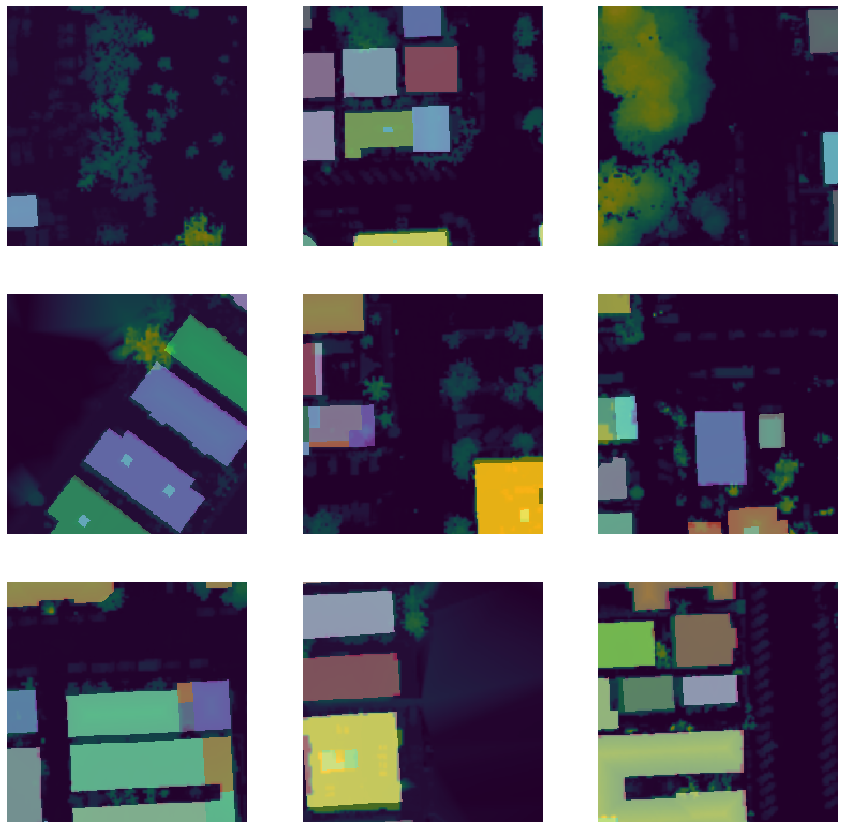

In [5]:
data.show_batch()

### Load model architecture

Here we use Mask R-CNN [1], a well-recognized instance algorithm, to detect roof segments (Figure 3). A Mask R-CNN model architecture and a pretrained model has already been predefined in `arcgis.learn`, so we can just define it with a single line. Please refer to the guide on our [developers' site](https://developers.arcgis.com/python/guide/geospatial-deep-learning/) for more information.

The idea of Mask R-CNN is to detect objects in an image while simultaneously generating a high-quality segmentation mask for each instance. In other words, it is like a combination of UNet and SSD and does two jobs in one go. This is also why it is relatively computationally more intensive.

In [6]:
model = MaskRCNN(data)

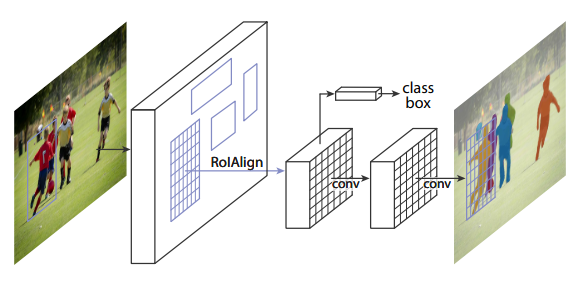
<center>Figure 3. Mask R-CNN framework for instance segmentation [1] </center>

### Find an optimal learning rate
[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. Python API provides a learning rate finder that automatically chooses the optimal learning rate for you.

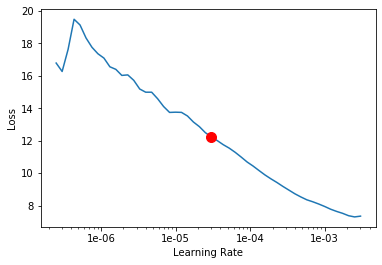

3.019951720402016e-05

In [5]:
# The users can visualize the learning rate of the model with comparative loss. 
model.lr_find()

### Fit the model

Let's train it for a few epochs with the learning rate we have found. For the sake of time, we can start with 20 epochs.

In [6]:
model.fit(epochs=20, lr=3.019951720402016e-05)

epoch,train_loss,valid_loss,time
0,4.552893,3.617720,01:13
1,2.919947,2.698832,01:17
2,2.405166,2.287111,01:23
3,2.020858,2.079069,01:25
4,1.923247,2.075449,01:27
5,1.756032,1.924104,01:28
6,1.660917,1.839138,01:29
7,1.538144,1.762277,01:29
8,1.644960,1.748547,01:30
9,1.469179,1.736558,01:31


### Visualize results in validation set
Now we have the model, let's look at how the model performs. There are 3 modes when visualizing the results.

- `bbox` - For visualizing only bounding boxes.
- `mask` - For visualizing only mask
- `bbox_mask` - For visualizing both mask and bounding boxes.

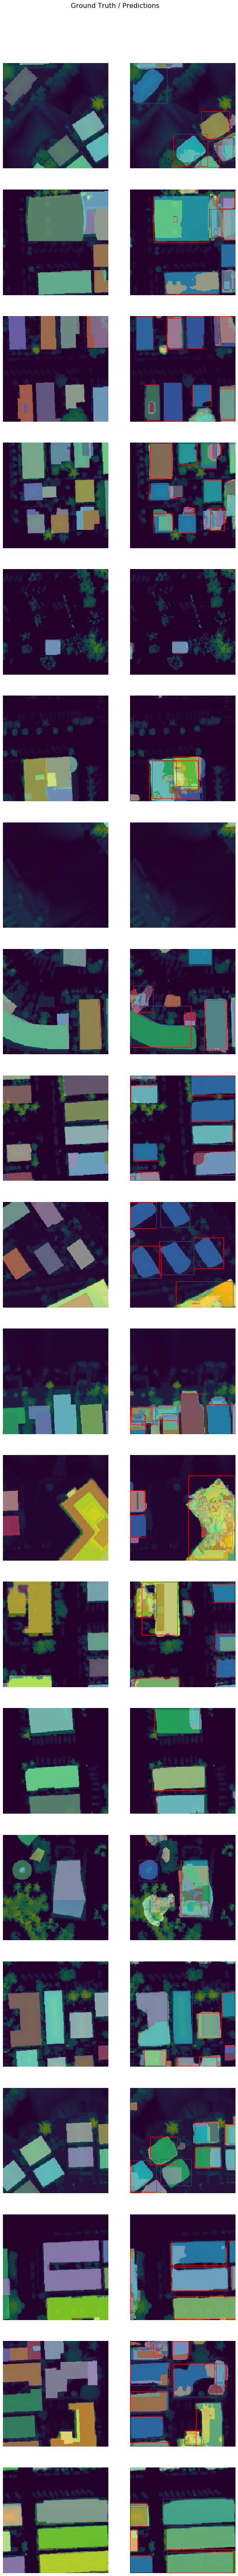

In [8]:
model.show_results(mode='bbox_mask', rows=20)

### Save the model

We will use the `save()` method to save the model and by default it will be saved to a folder 'models' inside our training data folder itself.

In [ ]:
model.save('20e')

As we can see, with only 20 epochs, we are already seeing promising results. Now let's train it for more epochs while unfreezing the model so we can train the backbone as well.

In [9]:
model.unfreeze()

In [10]:
model.fit(epochs=10, lr=3.019951720402016e-05)

epoch,train_loss,valid_loss,time
0,1.125096,1.676452,01:31
1,1.216572,1.686835,01:32
2,1.300244,1.700689,01:32
3,1.221825,1.647314,01:32
4,1.127060,1.672375,01:32
5,1.152627,1.678869,01:32
6,1.005214,1.710746,01:32
7,0.938052,1.774163,01:32
8,0.885974,1.869121,01:31
9,0.861661,1.896941,01:31


Note that the validation loss actually goes higher, but this doesn't necessarily mean the result is getting bad. Because our training data is also missing many buildings, the loss sometimes tells the actual model performance, so let's look at the actual results instead.

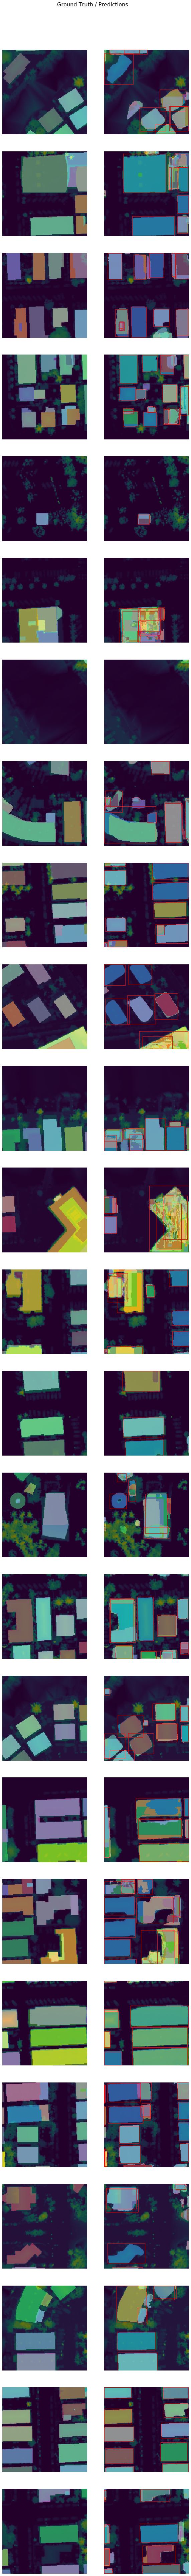

In [11]:
model.show_results(mode='bbox_mask', rows=25, box_threshold=0.5)

Just by visually inspecting the prediction images, the results have been improved. Further improvement can be achieved through more sophisticated hyperparameter tuning. Let's save the model for further training or inference later. The model should be saved into a models folder in your folder. By default, it will be saved into your `data_path` that you specified at the very beginning of this notebook.

In [ ]:
model.save('Unfreezed-10e')

## Next steps

The next step is to extrude object detection results in 3D using traditional Geoprocessing tools and Procedural rules. First, we used the “[Regularize Building Footprint](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/regularize-building-footprint.htm)” tool from the 3D Analyst toolbox to regularize raw detections. Next, we used surface elevation and DSM rasters to acquire the base elevation for each building segment, and calculate the roof ridge direction. The final step was calling the “[Features from CityEngine Rules](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/features-from-cityengine-rules.htm)” GP tool which applied a procedural rule to these polygons to achieve a final reconstruction of the 3D buildings.

## Conclusion
In this notebook, we have covered a lot of ground. In part 1, we discussed how to prepare and export training data from aerial Lidar data. In part 2, we demonstrated how to prepare the input data, train an instance segmentation model, visualize the results, as well as apply the model to an unseen image using the deep learning module in ArcGIS API for Python. 

## References
[1] He, K., Gkioxari, G., Dollár, P. and Girshick, R., 2017. Mask r-cnn. In Proceedings of the IEEE international conference on computer vision (pp. 2961-2969).